In [1]:
# Major sources of data and tools
import osmnx as ox
import networkx as nx

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.cm as cm
import matplotlib.colors as colors

# Simplification
import pandas as pd
import numpy as np
from shapely.geometry import LineString, Point

# Store computed centrality measures
import time
import pickle

# Compute information and straightness centrality
import geopy.distance

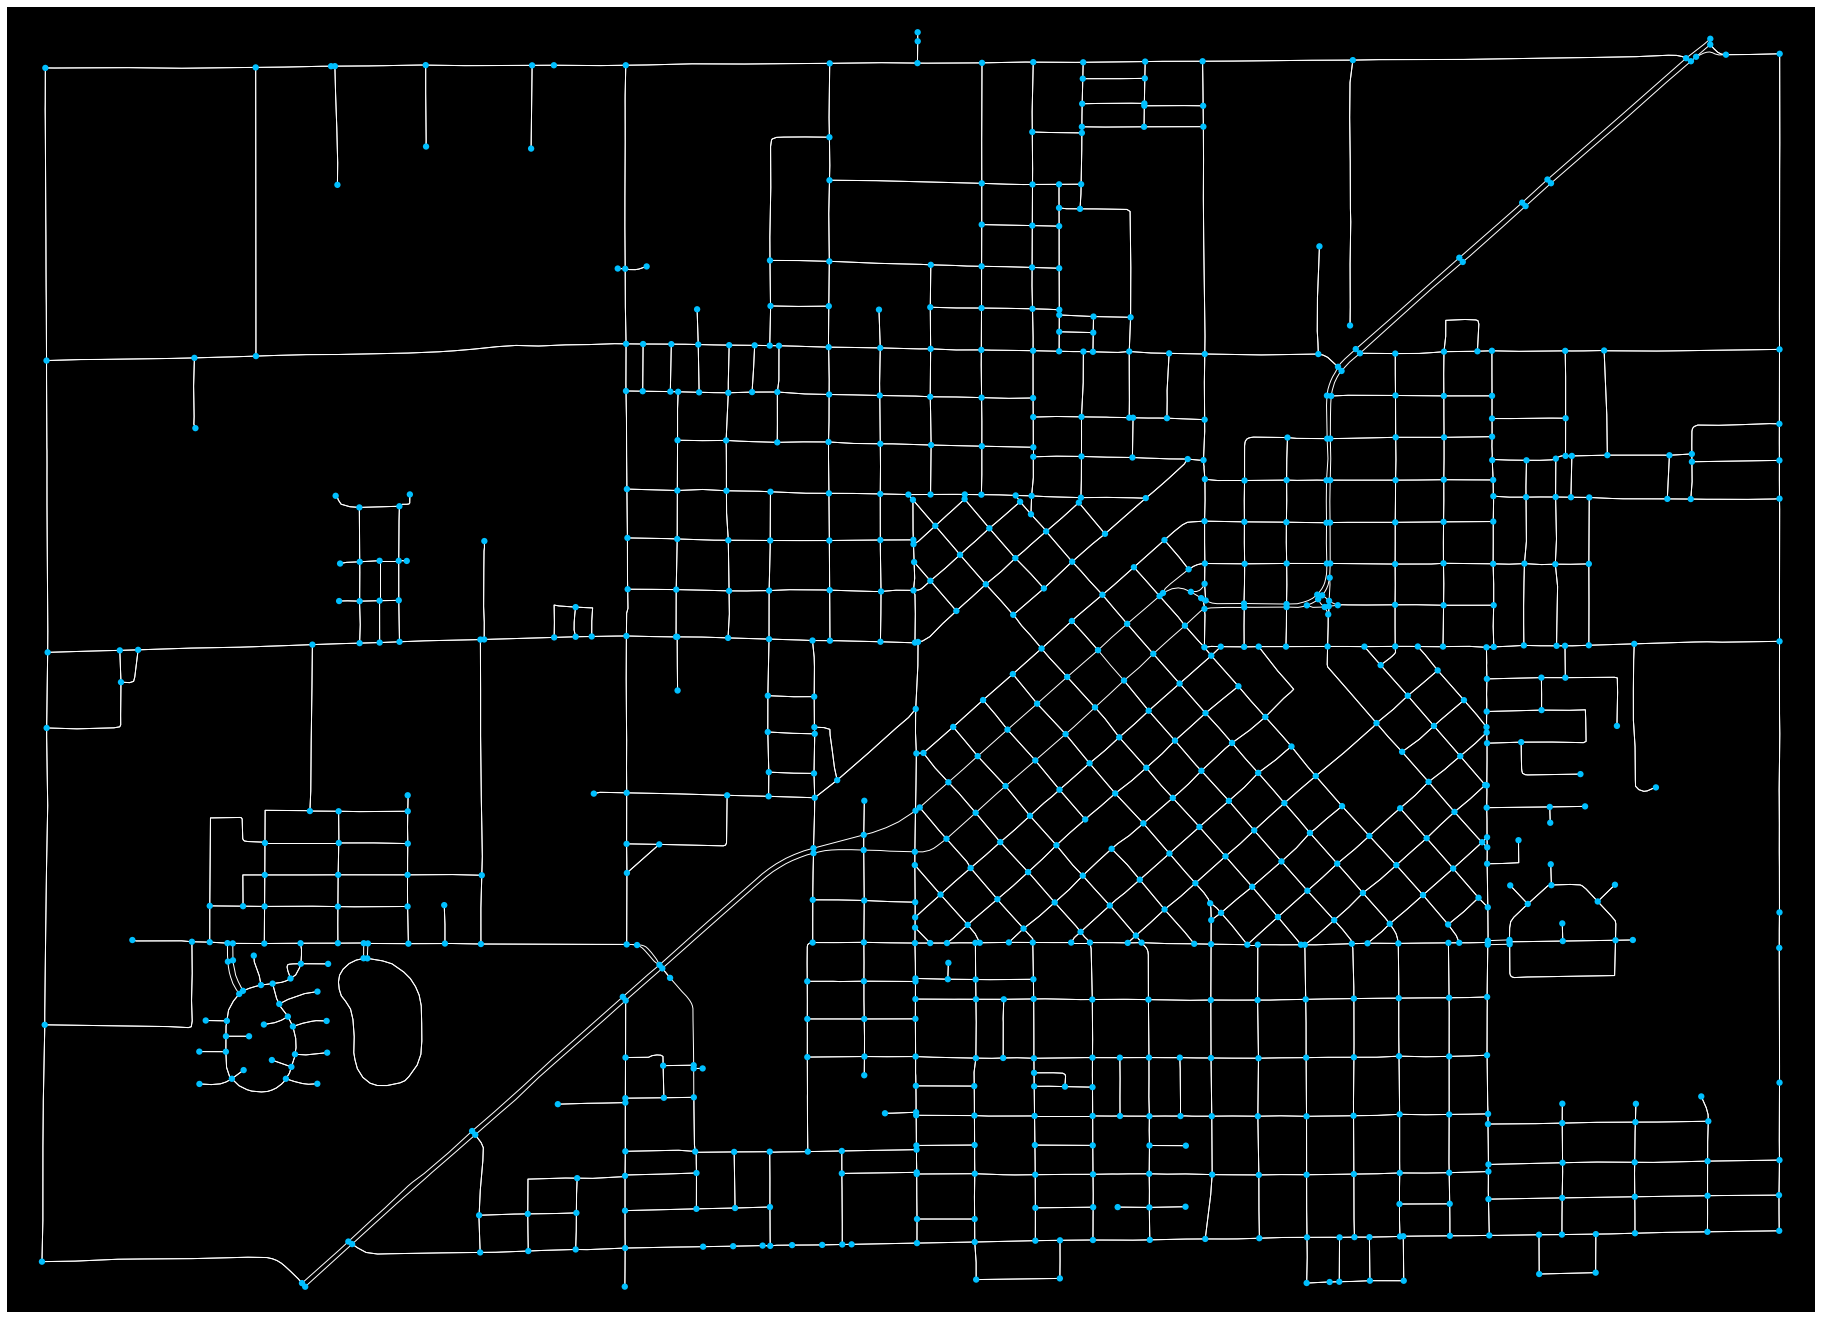

In [2]:
plt.ioff()
# get a graph for a city
north, west = 34.201816, -103.371467
south, east = 34.170154, -103.316182

city_name = 'Portales'
cent_dir = './centrality_measures/' + city_name + '/'

#rf = '["highway"~"motorway|motorway_link|primary|primary_link|secondary|secondary_link|tertiary|tertiary_link"]'

# load entire graph
G = ox.graph_from_bbox(north, south, east, west, network_type='drive')


# Plot a map
fig, ax = ox.plot_graph(G, figsize=(40, 24), node_color='deepskyblue',
                        node_size=40, edge_linewidth=1,edge_color='white', show=False, close=False, bgcolor='black')

plt.show()
plt.close('all')

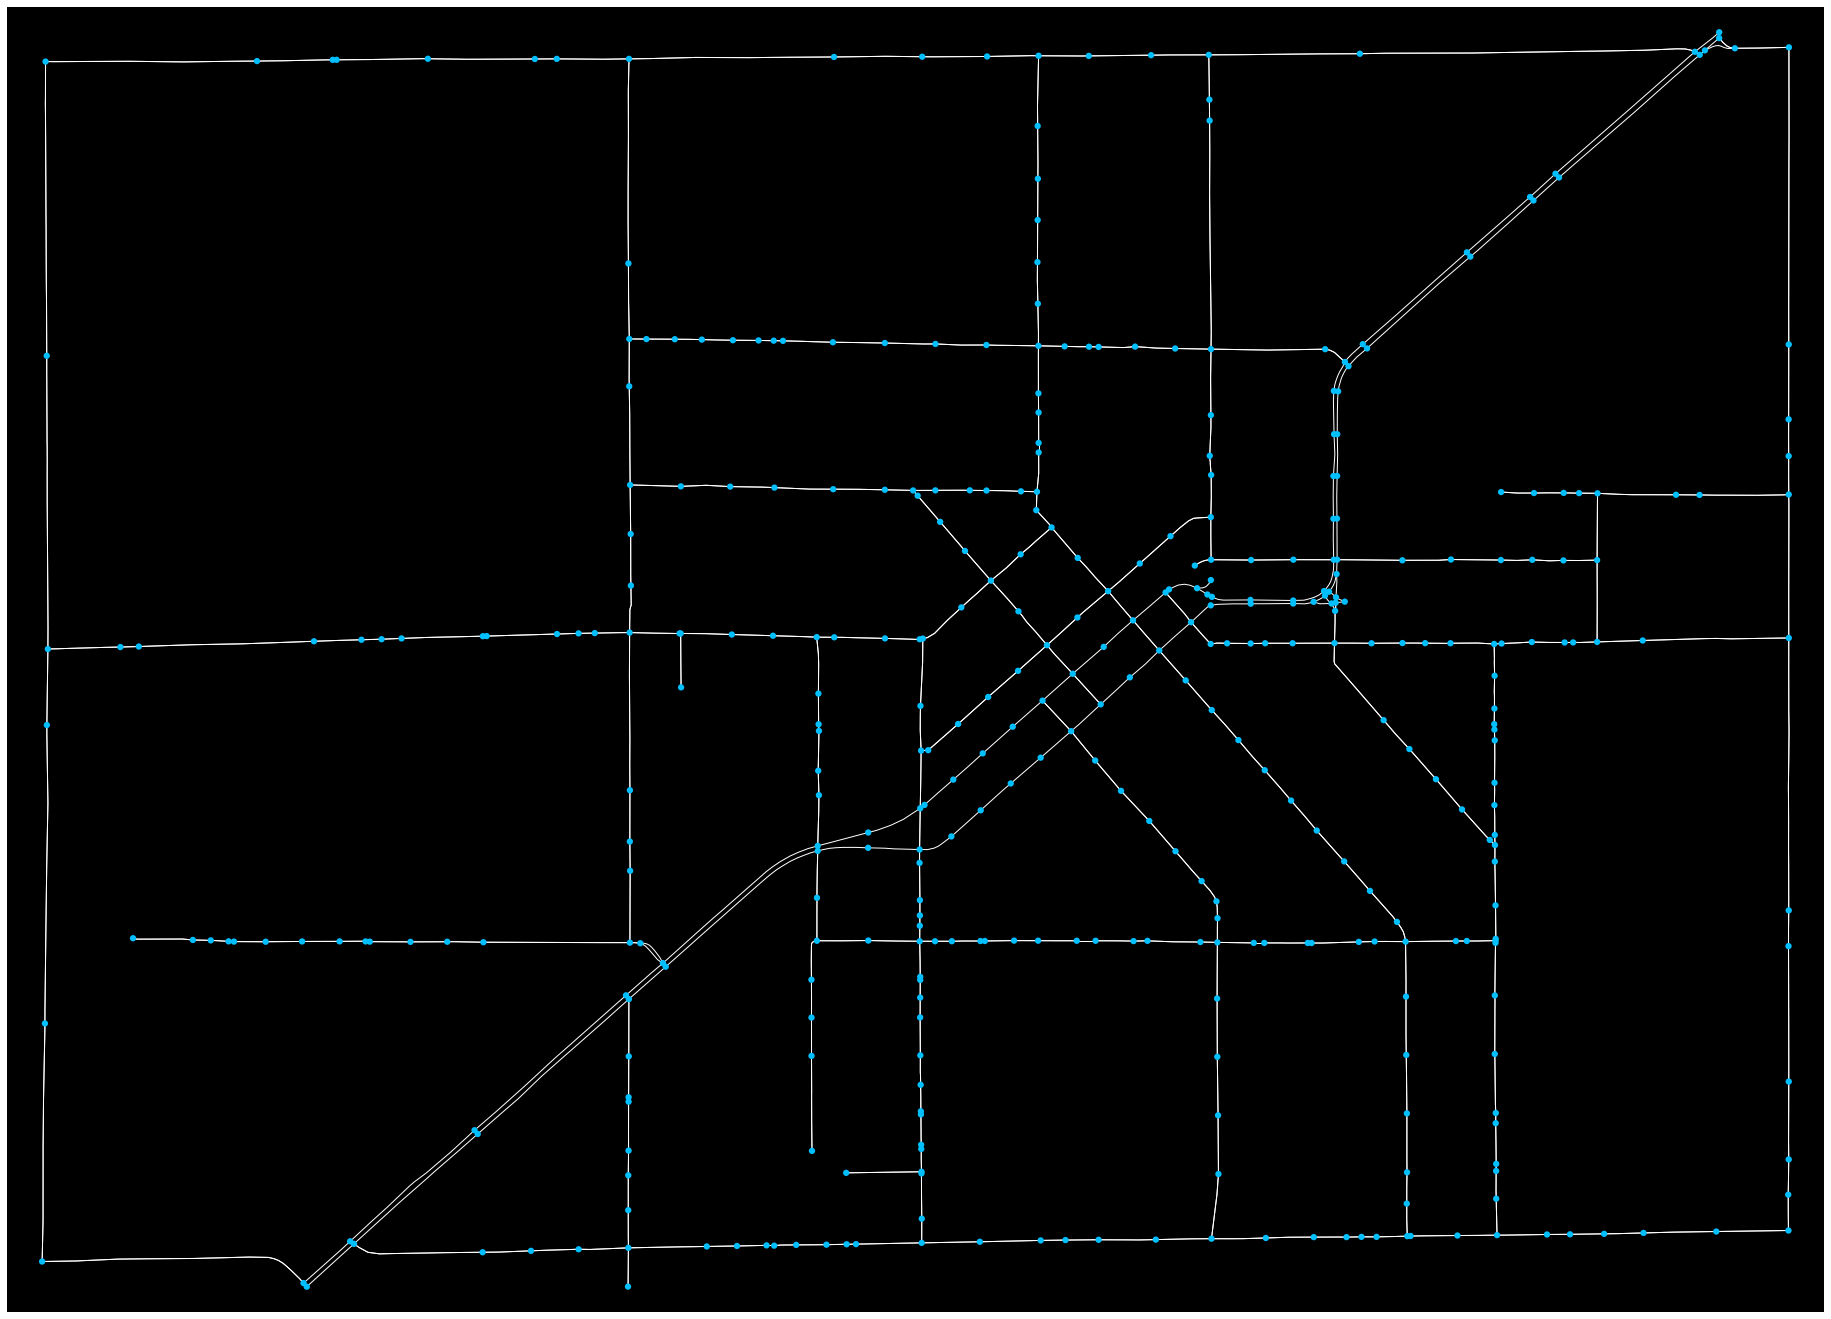

In [22]:
# load entire graph
G_wo_res = G.copy()

res_roads = []

for edge in G_wo_res.edges(keys=True, data=True):
    u,v,k,d = edge
    if d['highway'] == 'residential':
        res_roads.append((u, v, k))

G_wo_res.remove_edges_from(res_roads)

isolated_nodes = list(nx.isolates(G_wo_res))
G_wo_res.remove_nodes_from(isolated_nodes)

# Plot a map
fig, ax = ox.plot_graph(G_wo_res, figsize=(40, 24), node_color='deepskyblue',
                        node_size=40, edge_linewidth=1,edge_color='white', show=False, close=False, bgcolor='black')

plt.show()
plt.close('all')

In [98]:
# Show the basic statistics of the map
ox.basic_stats(G_wo_res)

{'n': 402,
 'm': 821,
 'k_avg': 4.08457711442786,
 'edge_length_total': 105536.81100000013,
 'edge_length_avg': 128.5466638246043,
 'streets_per_node_avg': 3.3681592039800994,
 'streets_per_node_counts': {0: 0, 1: 2, 2: 1, 3: 246, 4: 153},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.004975124378109453,
  2: 0.0024875621890547263,
  3: 0.6119402985074627,
  4: 0.3805970149253731},
 'intersection_count': 400,
 'street_length_total': 58596.637,
 'street_segment_count': 454,
 'street_length_avg': 129.06748237885463,
 'circuity_avg': 1.0019642203721937,
 'self_loop_proportion': 0.0}

In [191]:
road_priority = {
    'motorway': 0,
    'primary': 1,
    'secondary': 2,
    'tertiary': 3,
    'residential': 4,
    'motorway_link': 5,
    'primary_link': 6,
    'secondary_link': 7,
    'tertiary_link': 8,
    'unclassified': 9
}

for edge in G.edges:

    edge_type = G.edges[edge]['highway']

    if type(edge_type) is list:
        sorted_type = sorted(edge_type, reverse=False, key = lambda d: road_priority[d])
        edge_type = sorted_type[0]
        G.edges[edge]['highway'] = edge_type

In [97]:
# Show the basic statistics of the map
ox.basic_stats(G)

{'n': 794,
 'm': 2428,
 'k_avg': 6.1158690176322414,
 'edge_length_total': 303123.02500000043,
 'edge_length_avg': 124.84473846787498,
 'streets_per_node_avg': 3.239294710327456,
 'streets_per_node_counts': {0: 0, 1: 57, 2: 2, 3: 429, 4: 306},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.07178841309823678,
  2: 0.0025188916876574307,
  3: 0.5403022670025189,
  4: 0.3853904282115869},
 'intersection_count': 737,
 'street_length_total': 157912.4680000001,
 'street_segment_count': 1264,
 'street_length_avg': 124.93075000000009,
 'circuity_avg': 1.0220935862414817,
 'self_loop_proportion': 0.0}

In [4]:
def simplify(input_G):
    # define edge segment attributes to sum upon edge simplification
    attrs_to_sum = {"length", "travel_time"}
    
    # keep track of removed edges
    removed_edges = []
    removed_nodes = []
    
    acc_multi_edges = []
    acc_selfloops = []
    acc_dead_ends = []

    # make a copy to not mutate original graph object caller passed in
    G = input_G.copy()
     
    not_converged = True
    
    node_num = G.number_of_nodes()
    edge_num = G.number_of_edges()
    G_stat = (node_num, edge_num)
    
    cnt = 0
    
    print('Initial stat (nodes, edges):', G_stat)
    
    nx.set_node_attributes(G, 1, 'aggr_node_num')
           
    while not_converged:
        
        # keep track of removed edges in this iteration
        removed_edges_per_iteration = []
        
        ## Remove multi-edges ##
        multi_edges = []
        multi_edge_removed_pair = set()
        
        for u,v,k,d in G.edges(data=True, keys=True):
            if (u,v) not in multi_edge_removed_pair:
                all_edges_btwn_nodes = list(G.get_edge_data(u,v).items())
                edge_dat_sorted_by_length = sorted(all_edges_btwn_nodes, reverse=False, key= lambda d: d[1]['length'])
                shortest_edge_key = edge_dat_sorted_by_length[0][0]
                multi_edge_removed_pair.add((u,v))
                
                for key, data in G.get_edge_data(u,v).items():
                    if key != shortest_edge_key:
                        multi_edges.append((u, v, key))
        
        # Record which edge chunks are going to be removed at this iteration
        for edge in multi_edges:
            if 'consolidated_edges' in G.edges[edge]:
                cons_edges = G.edges[edge]['consolidated_edges']
                removed_edges_per_iteration = removed_edges_per_iteration + cons_edges
                ### test purpose
                acc_multi_edges = acc_multi_edges + cons_edges
            else:
                removed_edges_per_iteration.append(edge)
                ### test purpose
                acc_multi_edges.append(edge)
                    
        # remove all the edges whose key is not 0
        G.remove_edges_from(multi_edges)

        ## Remove selfloops ##
        selfloops = list(nx.selfloop_edges(G, keys=True))
        
        for edge in selfloops:               
            if 'consolidated_edges' in G.edges[edge]:
                cons_edges = G.edges[edge]['consolidated_edges']
                removed_edges_per_iteration = removed_edges_per_iteration + cons_edges
                ### test purpose
                acc_selfloops = acc_selfloops + cons_edges
            else:
                removed_edges_per_iteration.append(edge)
                ### test purpose
                acc_selfloops.append(edge)

        G.remove_edges_from(selfloops)
        
    
        ## Remove dead-ends ##
        for _ in range(0,20):
            dead_ends = []
            
            st_cnt = ox.utils_graph.count_streets_per_node(G, nodes=None)
            nx.set_node_attributes(G, st_cnt, 'street_count')

            rm = []

            for node in G.nodes:
                if G.nodes[node]['street_count'] == 1:
                    rm.append(node)
                    dead_ends = dead_ends + list(G.in_edges(node, keys=True)) + list(G.out_edges(node, keys=True))
                    
            dead_ends = list(set(dead_ends))
            
            for edge in dead_ends:
                if 'consolidated_edges' in G.edges[edge]:
                    cons_edges = G.edges[edge]['consolidated_edges']
                    removed_edges_per_iteration = removed_edges_per_iteration + cons_edges
                    ### test purpose
                    acc_dead_ends = acc_dead_ends + cons_edges
                else:
                    removed_edges_per_iteration.append(edge)
                    ### test purpose
                    acc_dead_ends.append(edge)
            
            # Add the number of aggregated nodes to its the only neighbor
            for node in rm:
                aggr_node_num = G.nodes[node]['aggr_node_num']
                
                suc = list(G.successors(node))  #  edge from node to neighbors 
                pre_suc = list(G.predecessors(node))  #  edge from neighbors to node
                
                if len(suc) != 0:
                    neighbor_node = suc[0]
                else:
                    neighbor_node = pre_suc[0]
                                
                G.nodes[neighbor_node]['aggr_node_num'] += aggr_node_num
            
            G.remove_nodes_from(rm)
            removed_nodes += rm
            
        ## Remove interstitial nodes ##
        all_nodes_to_remove = []
        all_edges_to_add = []
        aggr_node_num_to_be_summed = []
        
        # generate each path that needs to be simplified
        for path in ox.simplification._get_paths_to_simplify(G, strict=True):

            # add the interstitial edges we're removing to a list so we can retain
            # their spatial geometry
            path_attributes = dict()
            edges_in_path = []
            
            path_aggr_node_num = 0
            org_node = path[0]
            dst_node = path[-1]
            
            for node in path[1:-1]: # interstitial nodes
                node_aggr_node_num = G.nodes[node]['aggr_node_num']
                path_aggr_node_num += node_aggr_node_num
            
            end_points = {org_node, dst_node}
            interstitial_nodes = set(path[1:-1])
            
            if org_node == dst_node:
                path_aggr_node_num = 2 * path_aggr_node_num
                
            nodes_on_path = (end_points, interstitial_nodes)
            nodes_on_path_with_aggr_node_num = (nodes_on_path, path_aggr_node_num)
            
            # there may be reverse path that goes through the same nodes
            # avoid path_aggr_node_num being summed twice
            if nodes_on_path_with_aggr_node_num not in aggr_node_num_to_be_summed:
                aggr_node_num_to_be_summed.append(nodes_on_path_with_aggr_node_num)
            
            
            for u, v in zip(path[:-1], path[1:]):
                
                # get edge between these nodes. Multi-edges do not exist since already removed
                edge_key_and_data = tuple(G.get_edge_data(u, v).items())[0]
                edge_key = edge_key_and_data[0]
                exact_edge = (u,v, edge_key)
                edge_data = edge_key_and_data[1]
                edges_in_path.append(exact_edge)
                
                for attr in edge_data:
                    if attr in path_attributes:
                        # if this key already exists in the dict, append it to the
                        # value list
                        dat_val = edge_data[attr]
                        if type(dat_val) == list:
                            path_attributes[attr] = path_attributes[attr] + edge_data[attr]
                        else:
                            path_attributes[attr].append(edge_data[attr])
                    else:
                        # if this key doesn't already exist, set the value to a list
                        # containing the one value
                        dat_val = edge_data[attr]
                        if type(dat_val) == list:
                            path_attributes[attr] = edge_data[attr]
                        else:
                            path_attributes[attr] = [edge_data[attr]]
                
            # consolidate the path's edge segments' attribute values
            for attr in path_attributes:
                if attr in attrs_to_sum:
                    # if this attribute must be summed, sum it now
                    path_attributes[attr] = sum(path_attributes[attr])
                elif (attr != "geometry") and len(set(path_attributes[attr])) == 1:
                    # if there's only 1 unique value in this attribute list,
                    # consolidate it to the single value (the zero-th):
                    path_attributes[attr] = path_attributes[attr][0]
                elif attr != "geometry":
                    # otherwise, if there are multiple values, keep one of each
                    path_attributes[attr] = list(set(path_attributes[attr]))
            
            # Check consolidated edges are all in the 'consolidated_edges'
            if 'consolidated_edges' not in path_attributes:
                # none of the edges in path is previously consolidated
                # all the exact edges in the path is added to 'consolidated edges'
                path_attributes['consolidated_edges'] = edges_in_path
            else:
                # at least one of the edges in path is previously consolidated
                # previously not consolidated edges need to be added to 'consolidated edges'
                for edge in edges_in_path:
                    if edge in input_G.edges:
                        path_attributes['consolidated_edges'].append(edge)
                                               
            # construct the new consolidated edge's geometry for this path
            if 'geometry' not in path_attributes:
                path_attributes["geometry"] = LineString(
                    [Point((G.nodes[node]["x"], G.nodes[node]["y"])) for node in path]
                )
            else:
                points = []
                geometry = path_attributes['geometry']

                # Gather geometry dataframes in a list
                gm_df = []
                for gm in geometry:
                    x,y = gm.coords.xy
                    df = pd.DataFrame({'x':x,'y':y})
                    gm_df.append(df)

                for node in path:
                    node_x = G.nodes[node]['x']
                    node_y = G.nodes[node]['y']
                    node_coord = (node_x, node_y)
                    node_point = Point(node_coord)
                    #if node_point in points: continue

                    used_df_idx = [] # Prevent using duplicate geometry in reverse=order
                    node_belong_to_gm = False

                    for i, df in enumerate(gm_df):
                        # check if this node has geometry
                        has_gm = ((df['x'] == node_x) & (df['y'] == node_y))

                        # if geometry exists, add all the points in it
                        if has_gm.loc[has_gm.index[0]] and i not in used_df_idx:
                            node_belong_to_gm = True
                            used_df_idx.append(i)
                            for idx, row in df.iterrows():
                                x_coord = row['x']
                                y_coord = row['y']
                                geo_point = Point((x_coord, y_coord))
                                if geo_point not in points: points.append(geo_point)
                        elif has_gm.loc[has_gm.index[-1]] and i not in used_df_idx:
                            node_belong_to_gm = True
                            used_df_idx.append(i)
                            df = df[::-1]
                            for idx, row in df.iterrows():
                                x_coord = row['x']
                                y_coord = row['y']
                                geo_point = Point((x_coord, y_coord))
                                if geo_point not in points: points.append(geo_point)

                    # for node without geometry, simply add its single point
                    if not node_belong_to_gm:
                        points.append(node_point)

                path_attributes["geometry"] = LineString(points)

            # add the nodes and edge to their lists for processing at the end
            all_nodes_to_remove.extend(path[1:-1])
            all_edges_to_add.append(
                {"origin": path[0], "destination": path[-1], "attr_dict": path_attributes}
            )

        # for each edge to add in the list we assembled, create a new edge between
        # the origin and destination
        for edge in all_edges_to_add:
            G.add_edge(edge["origin"], edge["destination"], **edge["attr_dict"])
            
        # Add half of the path_aggr_node_num to each end point of that path
        for nodes_on_path, path_aggr_node_num in aggr_node_num_to_be_summed:
            end_points, interstitial_nodes = nodes_on_path
            for node in end_points:
                G.nodes[node]['aggr_node_num'] += (path_aggr_node_num / 2)

        # finally remove all the interstitial nodes between the new edges
        G.remove_nodes_from(set(all_nodes_to_remove))
        removed_nodes += list(set(all_nodes_to_remove))
        
        # check convergence
        current_node_num = G.number_of_nodes()
        current_edge_num = G.number_of_edges()
        current_stat = (current_node_num, current_edge_num)
        
        if G_stat == current_stat:
            not_converged = False
            break
        else:           
            G_stat = current_stat
            removed_edges.append(removed_edges_per_iteration)
            cnt += 1
        
        print('Stat at iteration', cnt, '(nodes, edges):', G_stat)
            
    print('Graph converged at iteration', cnt)
        
    return G, removed_edges, removed_nodes, (acc_multi_edges, acc_selfloops, acc_dead_ends)

Initial stat (nodes, edges): (794, 2428)
Stat at iteration 1 (nodes, edges): (665, 2165)
Graph converged at iteration 1


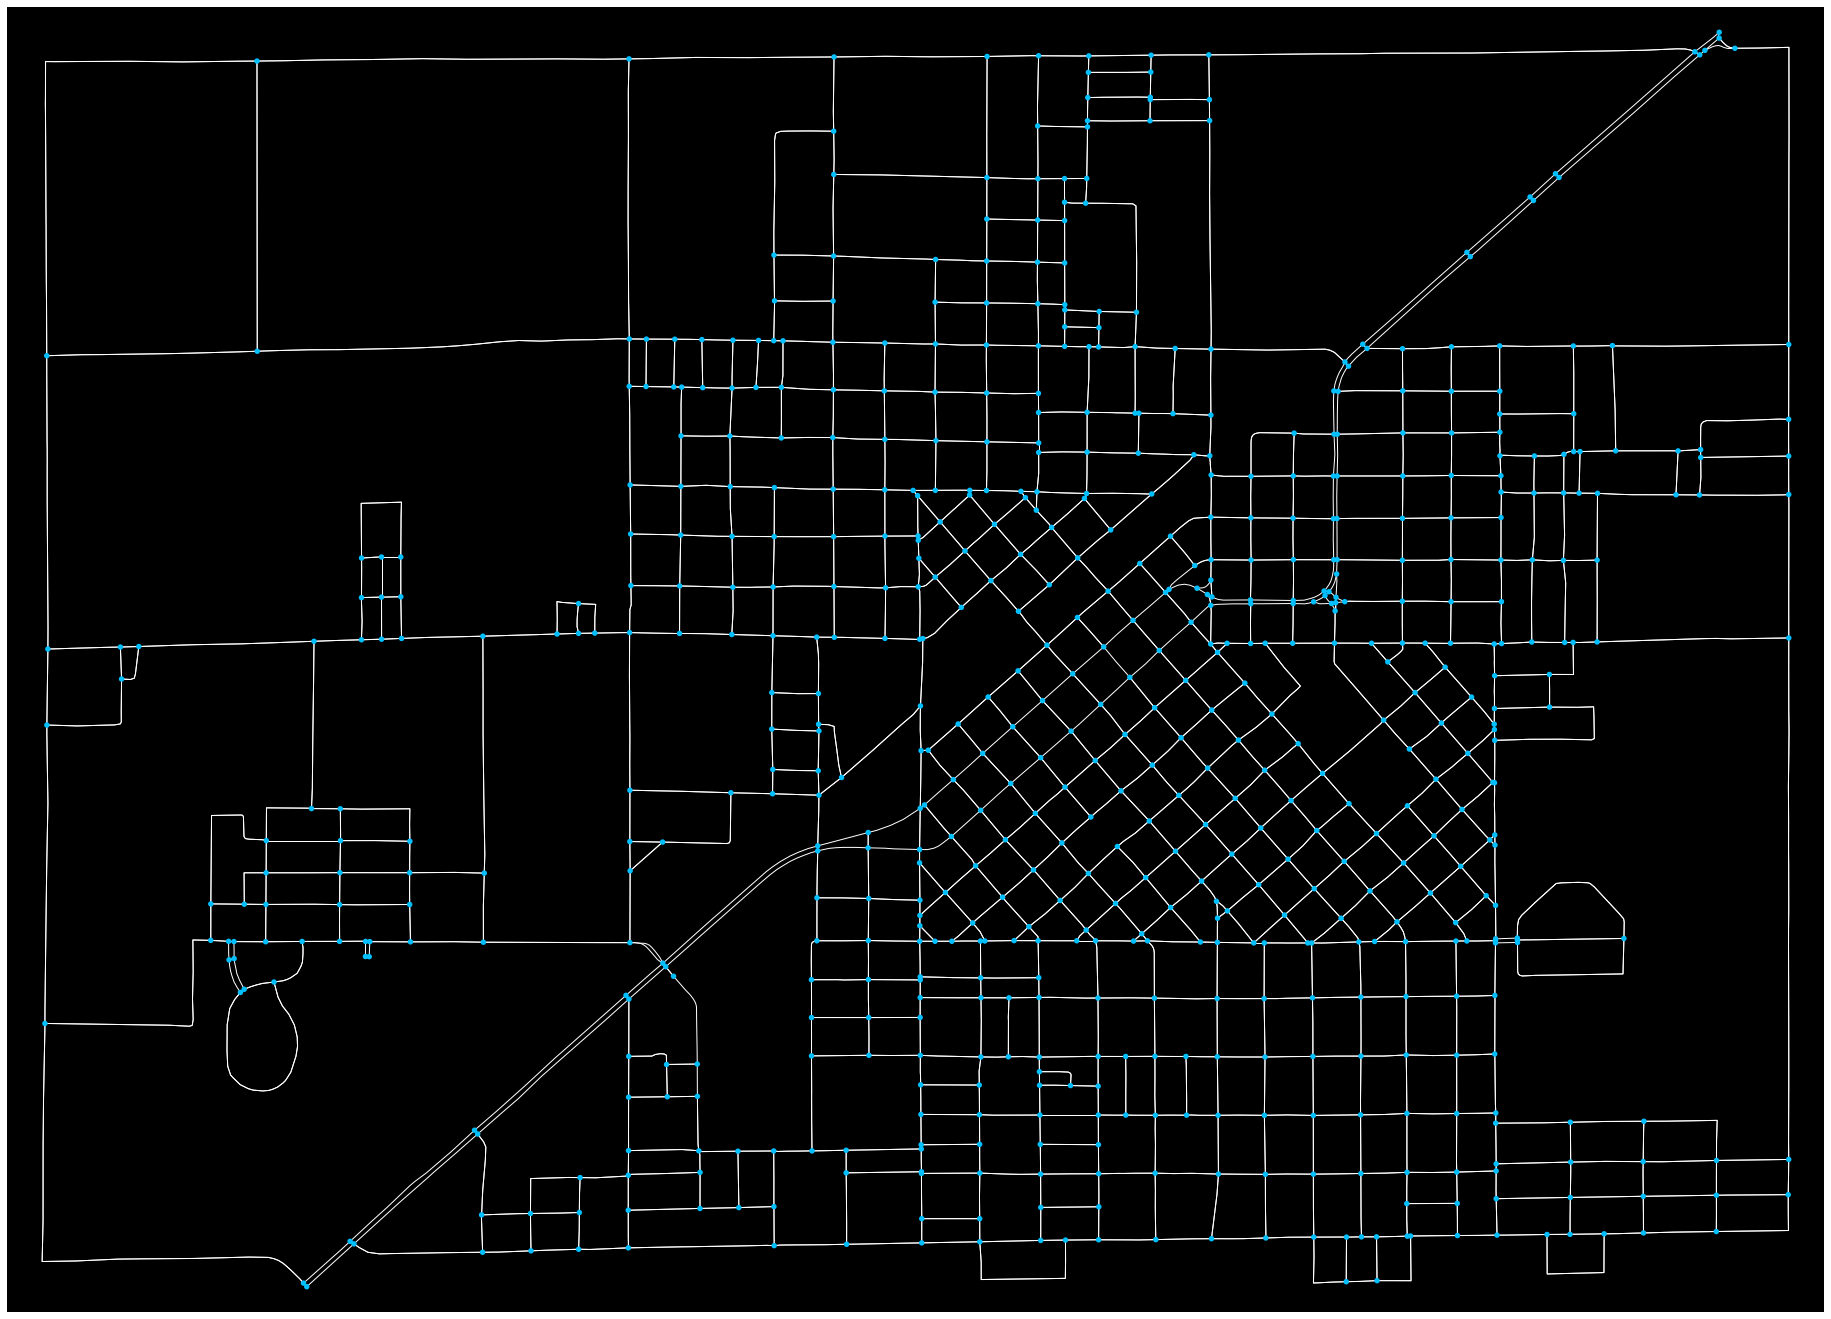

In [106]:
G1, removed_edges, removed_nodes, removed_cat = simplify(G)

# Plot a map
fig, ax = ox.plot_graph(G1, figsize=(40, 24), node_color='deepskyblue',
                        node_size=30, edge_linewidth=1,edge_color='white', show=False, close=False, bgcolor='black')

plt.show()
plt.close('all')

Sum of aggr_node_num: 794.0


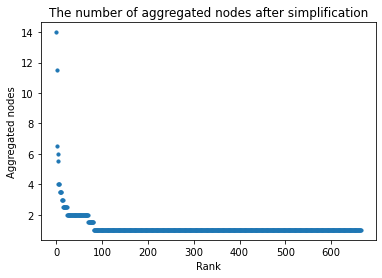

In [36]:
vals = []
acc = 0

for node in G1.nodes:
    val = G1.nodes[node]['aggr_node_num']
    vals.append(val)
    acc += val

print('Sum of aggr_node_num:', acc)
vals = sorted(vals, reverse=True)
y = [i for i in range(0, len(vals))]

#vals = [val ** 0.1 for val in vals]

plt.scatter(y, vals, s=10)
plt.title('The number of aggregated nodes after simplification')
plt.xlabel('Rank')
plt.ylabel('Aggregated nodes')

plt.show()
plt.close('all')

In [108]:
def plot_graph_highlight_nodes(
    G,
    ax=None,
    figsize=(8, 8),
    bgcolor="#111111",
    node_color="w",
    node_size=15,
    node_alpha=None,
    node_edgecolor="none",
    node_zorder=1,
    edge_color="#999999",
    edge_linewidth=1,
    edge_alpha=None,
    show=True,
    close=False,
    save=False,
    filepath=None,
    dpi=300,
    bbox=None,
    highlight=None
):

    max_node_size = max(node_size) if hasattr(node_size, "__iter__") else node_size
    max_edge_lw = max(edge_linewidth) if hasattr(edge_linewidth, "__iter__") else edge_linewidth
    if max_node_size <= 0 and max_edge_lw <= 0:  # pragma: no cover
        raise ValueError("Either node_size or edge_linewidth must be > 0 to plot something.")

    # create fig, ax as needed
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize, facecolor=bgcolor, frameon=False)
        ax.set_facecolor(bgcolor)
    else:
        fig = ax.figure

    if max_edge_lw > 0:       
        # plot edges that remaining after simplification
        removed_edges = []
        dup_edge_color = None
        for u,v,k,d in G.edges(data=True, keys=True):
            if 'rm_iter' in d and d['rm_iter'] != 0:
                removed_edges.append((u,v,k))
            elif 'rm_cat' in d and d['rm_iter'] != 0:
                removed_edges.append((u,v,k))
            else:
                dup_edge_color = edge_color[u][v][k]
        
        dup_G = G.copy()        
        dup_G.remove_edges_from(removed_edges)
        gdf_edges = ox.utils_graph.graph_to_gdfs(dup_G, nodes=False)["geometry"]
        ax = gdf_edges.plot(ax=ax, color=dup_edge_color, lw=edge_linewidth+0.05, alpha=edge_alpha, zorder=1)
        
        # plot the edges' geometries
        gdf_edges = ox.utils_graph.graph_to_gdfs(G, nodes=False)["geometry"]
        ax = gdf_edges.plot(ax=ax, color=edge_color, lw=edge_linewidth, alpha=edge_alpha, zorder=0)
        
    if max_node_size > 0:
        # scatter plot the nodes' x/y coordinates
        gdf_nodes = ox.utils_graph.graph_to_gdfs(G, edges=False, node_geometry=False)[["x", "y"]]
        aggr_node_num = []
        for i, row in gdf_nodes.iterrows():
            aggr_node_num.append(G.nodes[i]['aggr_node_num'])

        gdf_nodes['aggr'] = aggr_node_num
        
        rest_nodes = [node for node in G.nodes if node not in highlight]
        rest_node_color = node_color.drop(removed_nodes)
                
        rest_nodes_coords = gdf_nodes.loc[rest_nodes]
        highlight_nodes_coords = gdf_nodes.loc[highlight]
        
        x = []
        y = []
        c = []
        aggr = []
        
        for idx, row in rest_nodes_coords.iterrows():
            x.append(row['x'])
            y.append(row['y'])
            c.append(mpl.colors.to_hex(rest_node_color[idx]))
            aggr.append(row['aggr'])
            
        order = np.argsort(aggr)
        
        ax.scatter(
            x=highlight_nodes_coords["x"],
            y=highlight_nodes_coords["y"],
            s=node_size,
            c='lightgrey',
            alpha=node_alpha,
            edgecolor='black',
            zorder=node_zorder,
            linewidth=0.3,
            marker='^',
        )
        
        for idx in order:
            ax.scatter(
                x[idx],
                y[idx],
                s=node_size,
                c=c[idx],
                alpha=node_alpha,
                edgecolor=node_edgecolor,
                zorder=node_zorder,
                linewidth=0.3,
            )            

    # get spatial extents from bbox parameter or the edges' geometries
    padding = 0
    if bbox is None:
        try:
            west, south, east, north = gdf_edges.total_bounds
        except NameError:
            west, south = gdf_nodes.min()
            east, north = gdf_nodes.max()
        bbox = north, south, east, west
        padding = 0.02  # pad 2% to not cut off peripheral nodes' circles

    # configure axis appearance, save/show figure as specified, and return
    ax = ox.plot._config_ax(ax, G.graph["crs"], bbox, padding)
    fig, ax = ox.plot._save_and_show(fig, ax, save, show, close, filepath, dpi)
    
    return fig, ax

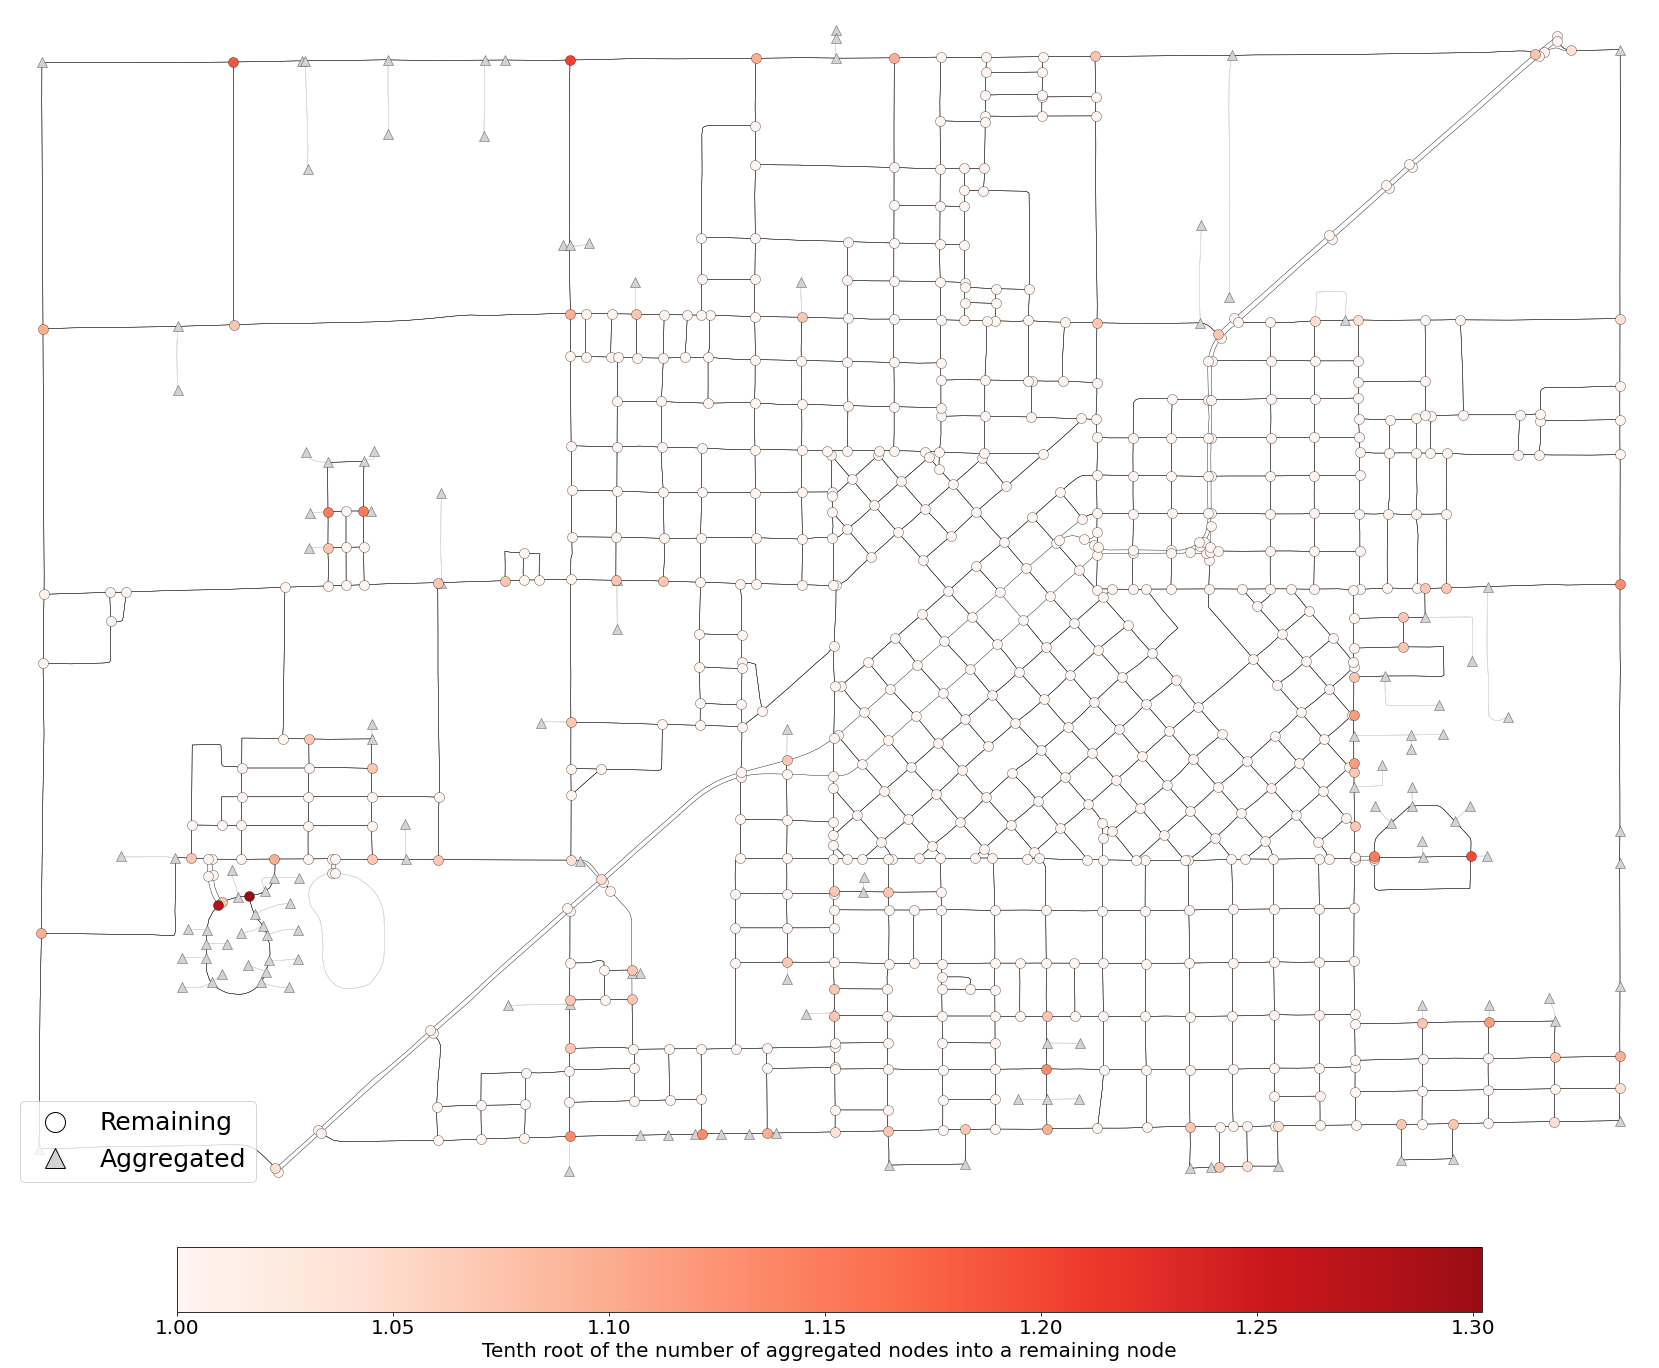

In [110]:
nx.set_node_attributes(G, 1, 'aggr_node_num')
nx.set_edge_attributes(G, 1, 'rm_iter')

for idx, removed_edge_list in enumerate(removed_edges):
    for removed_edge in removed_edge_list:
        G.edges[removed_edge]['rm_iter'] = 0
        
ec = ox.plot.get_edge_colors_by_attr(G, "rm_iter", cmap='Greys', start=0.25, stop=1, na_color='none')

for node in G1.nodes:
    root_aggr_node_num = G1.nodes[node]['aggr_node_num'] ** 0.1
    G.nodes[node]['aggr_node_num'] = root_aggr_node_num

# Plot a map that represents the betweenness centrality of each node
aggr_num_nc = ox.plot.get_node_colors_by_attr(G, "aggr_node_num", cmap='Reds', start=0, stop=0.9, na_color='none')


aggr_num_fig, aggr_num_ax = plot_graph_highlight_nodes(G, figsize=(40,24), node_color=aggr_num_nc, node_size=100,
                                edge_linewidth=0.4, edge_color=ec, show=False, close=False,
                                node_edgecolor='black', bgcolor='white', highlight = removed_nodes)

white_circle = mlines.Line2D([], [], color='white', marker='o',
                             markersize=20, markeredgewidth=1, markeredgecolor='k',
                             linestyle='None', label='Remaining')
grey_triangle = mlines.Line2D([], [], color='lightgrey', marker='^',
                             markersize=20, markeredgewidth=1, markeredgecolor='k',
                              linestyle='None', label='Aggregated')

plt.legend(handles=[white_circle, grey_triangle], prop={'size': 25})

aggr = nx.get_node_attributes(G, 'aggr_node_num')
max_aggr = max(aggr.values())
min_aggr = min(aggr.values())

# Add a color legend
cmap = plt.cm.get_cmap('Reds')
trunc_min, trunc_max = 0, 0.9

new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=trunc_min, b=trunc_max),
    cmap(np.linspace(trunc_min, trunc_max, 1000)))

norm = plt.Normalize(vmin=min_aggr, vmax=max_aggr)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=new_cmap)
sm.set_array([])

cb = aggr_num_fig.colorbar(sm, fraction=0.05, pad=0.04, orientation='horizontal')
cb.set_label('Tenth root of the number of aggregated nodes into a remaining node', fontsize = 20)
cb.ax.tick_params(labelsize=20)

plt.show()
plt.close('all')

In [42]:
def plot_graph(
    G,
    ax=None,
    figsize=(8, 8),
    bgcolor="#111111",
    node_color="w",
    node_size=15,
    node_alpha=None,
    node_edgecolor="none",
    node_zorder=1,
    edge_color="#999999",
    edge_linewidth=1,
    edge_alpha=None,
    show=True,
    close=False,
    save=False,
    filepath=None,
    dpi=300,
    bbox=None,
):

    max_node_size = max(node_size) if hasattr(node_size, "__iter__") else node_size
    max_edge_lw = max(edge_linewidth) if hasattr(edge_linewidth, "__iter__") else edge_linewidth
    if max_node_size <= 0 and max_edge_lw <= 0:  # pragma: no cover
        raise ValueError("Either node_size or edge_linewidth must be > 0 to plot something.")

    # create fig, ax as needed
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize, facecolor=bgcolor, frameon=False)
        ax.set_facecolor(bgcolor)
    else:
        fig = ax.figure

    if max_edge_lw > 0:       
        # plot edges that remaining after simplification
        removed_edges = []
        dup_edge_color = None
        for u,v,k,d in G.edges(data=True, keys=True):
            if 'rm_iter' in d and d['rm_iter'] != 0:
                removed_edges.append((u,v,k))
            elif 'rm_cat' in d and d['rm_iter'] != 0:
                removed_edges.append((u,v,k))
            else:
                dup_edge_color = edge_color[u][v][k]
        
        dup_G = G.copy()        
        dup_G.remove_edges_from(removed_edges)
        gdf_edges = ox.utils_graph.graph_to_gdfs(dup_G, nodes=False)["geometry"]
        ax = gdf_edges.plot(ax=ax, color=dup_edge_color, lw=edge_linewidth, alpha=edge_alpha, zorder=1)
        
        # plot the edges' geometries
        gdf_edges = ox.utils_graph.graph_to_gdfs(G, nodes=False)["geometry"]
        ax = gdf_edges.plot(ax=ax, color=edge_color, lw=edge_linewidth, alpha=edge_alpha, zorder=0)

    if max_node_size > 0:
        # scatter plot the nodes' x/y coordinates
        gdf_nodes = ox.utils_graph.graph_to_gdfs(G, edges=False, node_geometry=False)[["x", "y"]]
        ax.scatter(
            x=gdf_nodes["x"],
            y=gdf_nodes["y"],
            s=node_size,
            c=node_color,
            alpha=node_alpha,
            edgecolor=node_edgecolor,
            zorder=node_zorder,
        )

    # get spatial extents from bbox parameter or the edges' geometries
    padding = 0
    if bbox is None:
        try:
            west, south, east, north = gdf_edges.total_bounds
        except NameError:
            west, south = gdf_nodes.min()
            east, north = gdf_nodes.max()
        bbox = north, south, east, west
        padding = 0.02  # pad 2% to not cut off peripheral nodes' circles

    # configure axis appearance, save/show figure as specified, and return
    ax = ox.plot._config_ax(ax, G.graph["crs"], bbox, padding)
    fig, ax = ox.plot._save_and_show(fig, ax, save, show, close, filepath, dpi)

    return fig, ax

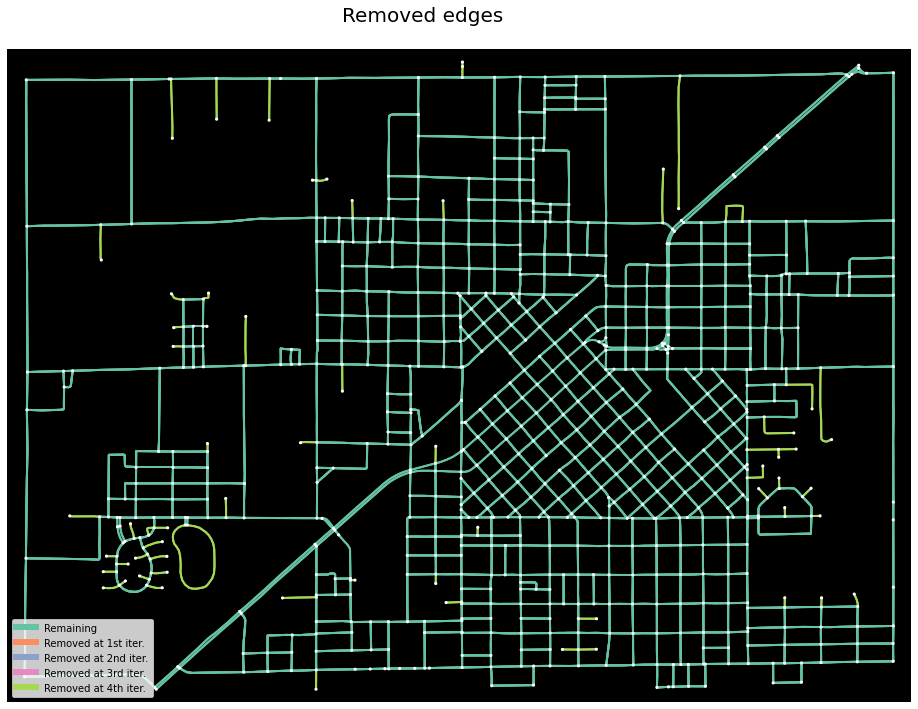

In [43]:
# Plot edge types on the map
removed_edge_dic = {}
nx.set_edge_attributes(G, 0, 'rm_iter')

for idx, removed_edge_list in enumerate(removed_edges):
    idx += 1
    for removed_edge in removed_edge_list:
        G.edges[removed_edge]['rm_iter'] = idx
           
# Plot a map that represents the type of each edge
ec = ox.plot.get_edge_colors_by_attr(G, "rm_iter", cmap='Set2', num_bins=5, start=0, stop=0.624, na_color='none')
rm_fig, rm_ax = plot_graph(G, figsize=(40, 12), node_color='white', node_size=10,
                                          edge_linewidth=2, edge_color=ec, show=False, close=False, bgcolor='black')

rm_fig.suptitle(t='Removed edges', y=0.93, size=20)
   
# Add legend
cmap = plt.cm.get_cmap('Set2')

line_remained, = plt.plot([0, 0, 0], label='Remaining', c=cmap(0), linewidth = 6)
line_1st, = plt.plot([0, 0, 0], label='Removed at 1st iter.', c=cmap(0.125), linewidth = 6)
line_2nd, = plt.plot([0, 0, 0], label='Removed at 2nd iter.', c=cmap(0.250), linewidth = 6)
line_3rd, = plt.plot([0, 0, 0], label='Removed at 3rd iter.', c=cmap(0.375), linewidth = 6)
line_4th, = plt.plot([0, 0, 0], label='Removed at 4th iter.', c=cmap(0.500), linewidth = 6)

plt.legend([line_remained, line_1st,
            line_2nd, line_3rd, line_4th],
           ['Remaining', 'Removed at 1st iter.',
            'Removed at 2nd iter.', 'Removed at 3rd iter.', 'Removed at 4th iter.'],
            prop={'size': 10})

plt.show()
plt.close('all')

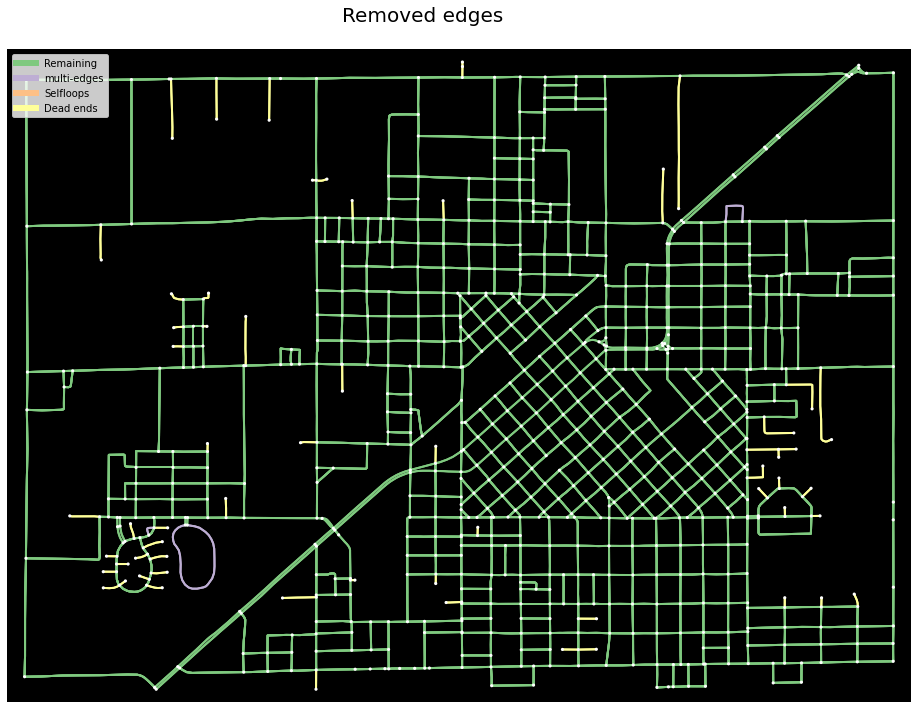

In [44]:
# Plot edge types on the map

nx.set_edge_attributes(G, 0, 'rm_cat')

for idx, removed_edge_list in enumerate(removed_cat):
    idx += 1
    for removed_edge in removed_edge_list:
        G.edges[removed_edge]['rm_cat'] = idx
               
# Plot a map that represents the type of each edge
ec = ox.plot.get_edge_colors_by_attr(G, "rm_cat", cmap='Accent', num_bins=4, start=0, stop=0.49, na_color='none')
rm_fig, rm_ax = plot_graph(G, figsize=(40, 12), node_color='white', node_size=10,
                                          edge_linewidth=2, edge_color=ec, show=False, close=False, bgcolor='black')

rm_fig.suptitle(t='Removed edges', y=0.93, size=20)
   
# Add legend
cmap = plt.cm.get_cmap('Accent')

line_remained, = plt.plot([0, 0, 0], label='Remaining', c=cmap(0), linewidth = 6)
line_1st, = plt.plot([0, 0, 0], label='multi-edges', c=cmap(0.125), linewidth = 6)
line_2nd, = plt.plot([0, 0, 0], label='selfloops', c=cmap(0.250), linewidth = 6)
line_3rd, = plt.plot([0, 0, 0], label='dead_ends', c=cmap(0.375), linewidth = 6)

plt.legend([line_remained, line_1st,
            line_2nd, line_3rd],
           ['Remaining', 'multi-edges',
            'Selfloops', 'Dead ends'],
            prop={'size': 10})

plt.show()
plt.close('all')

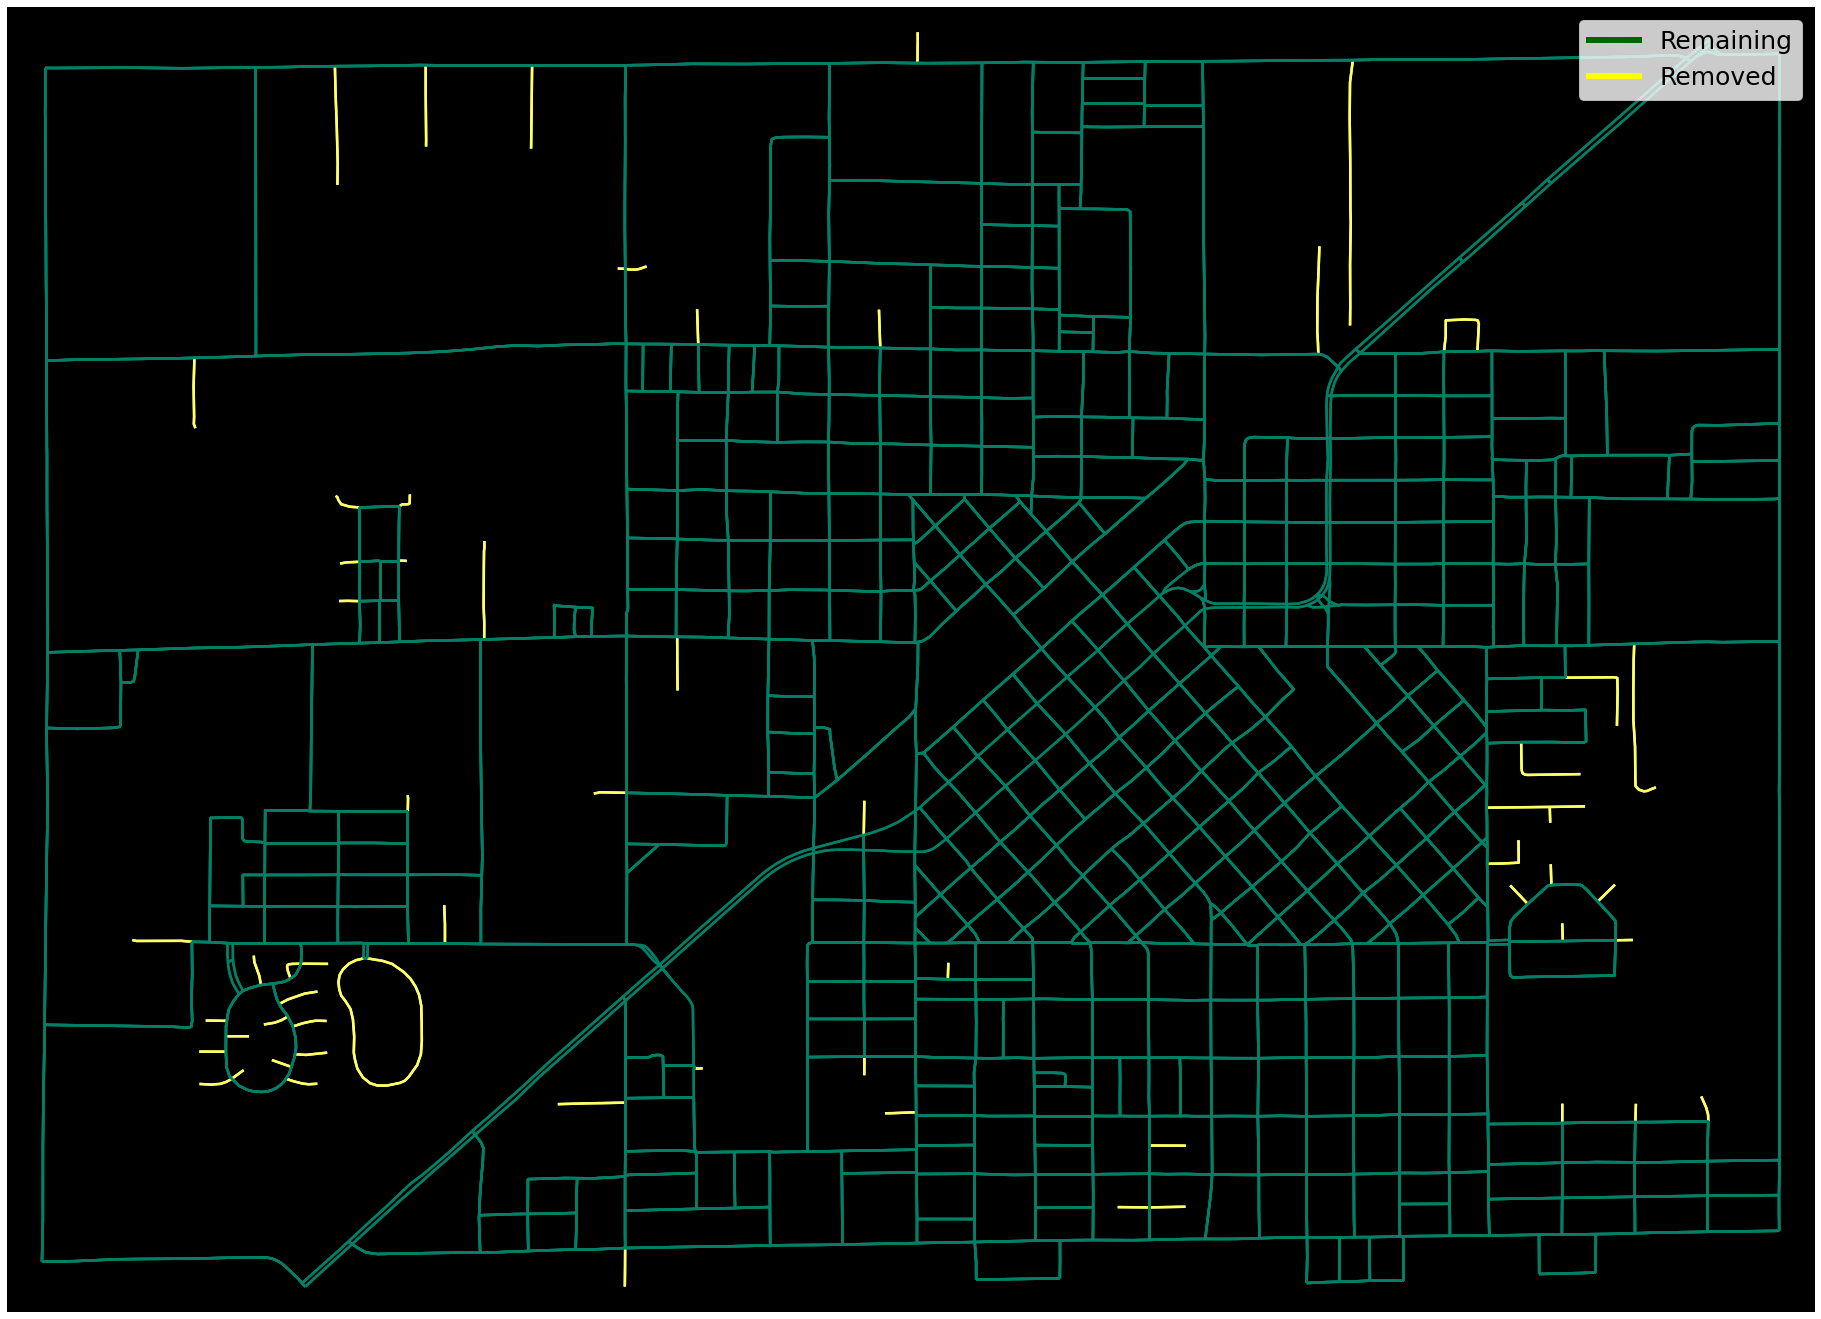

In [45]:
# Plot edge types on the map
nx.set_edge_attributes(G, 0, 'rm_iter')

for idx, removed_edge_list in enumerate(removed_edges):
    for removed_edge in removed_edge_list:
        G.edges[removed_edge]['rm_iter'] = 1

# Get edge colors based on removal
ec = ox.plot.get_edge_colors_by_attr(G, 'rm_iter', num_bins=None, cmap='summer',
                                     start=0, stop=1, na_color='none', equal_size=False)

fig, ax = plot_graph(G, figsize=(40,24), node_color='deepskyblue', node_size=0,
                        edge_linewidth=2.5, edge_color=ec, show=False, close=False, bgcolor='k')

line_up, = plt.plot([10, 20, 30], label='One', c='darkgreen', linewidth = 6)
line_down, = plt.plot([30, 20, 10], label='Two', c='yellow', linewidth = 6)
plt.legend([line_up, line_down], ['Remaining', 'Removed'], prop={'size': 25})

plt.show()

{'tertiary': 46, 'residential': 195, 'secondary': 14, 'primary': 4, 'living_street': 2, 'unclassified': 2}


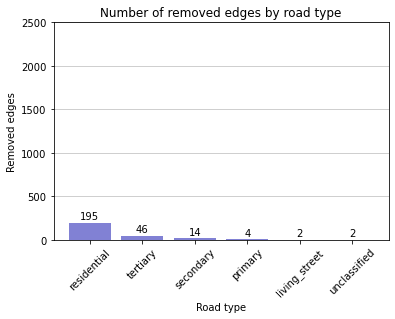

In [46]:
removed_count = {}

road_priority = {'motorway': 1,
                'motorway_link': 2,
                'primary': 3,
                'primary_link': 4,
                'secondary': 5,
                'secondary_link': 6,
                'tertiary': 7,
                'tertiary_link': 8,
                'residential': 9,
                'unclassified': 10}

left_edges = []
removed_edges = []

for u,v,k,d in G1.edges(keys=True, data=True):
    if 'consolidated_edges' in d:        
        # decrease removed_count since a single concatenated edge added instead of consolidated edges
        road_type = d['highway']
        if type(road_type) == list:
            priorities = []
            for rt in road_type:
                priorities.append(road_priority[rt])
            priority = min(priorities)

            for rt, priority_val in road_priority.items():
                if priority == priority_val: road_type = rt

        if road_type in removed_count:
            removed_count[road_type] -= 1
        else:
            removed_count[road_type] = -1 
    else:
        left_edges.append((u,v,k))
        
for edge in G.edges(keys=True):
    if edge not in left_edges:
        removed_edges.append(edge)
        
for removed_edge in removed_edges:
    road_type = G.edges[removed_edge]['highway']
    if type(road_type) == list:
        priorities = []
        for rt in road_type:
            priorities.append(road_priority[rt])
        priority = min(priorities)

        for pair in road_priority.items():
            if priority == pair[1]: road_type = pair[0]

    if road_type in removed_count:
        removed_count[road_type] += 1
    else:
        removed_count[road_type] = 1
            
print(removed_count)

# data set
rm_count_by_type = removed_count.items()
rm_count_by_type = sorted(rm_count_by_type, reverse=True, key = lambda d: d[1])

objects = [d[0] for d in rm_count_by_type]
y_pos = np.arange(len(objects))
performance = [d[1] for d in rm_count_by_type]

bar_container = plt.bar(y_pos, performance, align='center', color='#0504aa', alpha=0.5)
plt.xticks(y_pos, objects, rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Road type')
plt.ylabel('Removed edges')
plt.ylim(top=2500)
plt.title('Number of removed edges by road type')

# Make some labels.
rects = bar_container.patches
labels = ["%d" % i for i in performance]
  
for rect, label in zip(rects, labels):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height+15, label,
            ha='center', va='bottom')
    
plt.show()

# Note: This does not include the number of consolidated edges by removing interstitial nodes

### Estimate $C^B$ of "original" network from "simplified" network
Standard $C^B$ of an edge $e$ is computed as follows:

$$ C^B(e) = \sum_{s,t \in V} \frac{\sigma(s,t|e)}{\sigma(s,t)}	 $$

Where $V$ is the set of nodes in a graph, $\sigma(s,t)$ is the number of shortest paths between an OD pair $(s,t)$, and $\sigma(s,t|e)$ is the number of those paths that passing through edge $e$. However, in simplified graph, many nodes are removed and the set of nodes $V'$ has much less nodes than the node set $V$ in the original graph, resulting in slightly different $C^B$ distribution. To estimate $C^B$ distribution of the original network using simplified network, we use the node attribute `aggr_node_num`.

In simplification process, `aggr_node_num` value moves from nodes being removed to their nearest nodes, which causes remaining nodes in largely simplified area have high value of `aggr_node_num`. It implies that `aggr_node_num` of a node intuitively represents that how many nodes are collapsed to the node. From the locality and the fact that removed components in the simplified graph do not provide path to other components, we can assume that all the shortest paths from the nodes collapsed into node $s$ to node $t$ pass through node $s$. This assumption allow us to estimate $C^B$ distribution of the original network using the simplified network and `aggr_node_num` attributes as follows:

$$ C^B_{est}(e) = \sum_{s,t \in V'} \frac{\sigma(s,t|e)}{\sigma(s,t)} \times aggr_s \times aggr_t	 $$

Where $V'$ is the set of nodes in the simplified graph, and aggr is the value of `aggr_node_num` of a node.

In [47]:
## Compute betweenness centrality weighted by 'length' and 'aggr_node_num'              
def accumulate_sigma(G, all_paths, bc_dic, multiple, weight='length'):
    path_num = len(all_paths)
    
    for path in all_paths:
        for u, v in zip(path[:-1], path[1:]):
            all_edges_btwn_nodes = list(G.get_edge_data(u,v).items())
            edge_dat_sorted_by_length = sorted(all_edges_btwn_nodes, reverse=False, key= lambda d: d[1][weight])
            shortest_edge_key = edge_dat_sorted_by_length[0][0]
            shortest_edge = (u, v, shortest_edge_key)

            bc_dic[shortest_edge] += multiple / path_num
        
def estimated_betweenness_centrality(G, weight='length', normalize='True'):
    
    nodes = G.nodes
    n = G.number_of_nodes()
    print('Compute betweenness centrality in the input graph with', n, 'nodes')
    
    total_start_time = time.time()
    
    betweenness_centrality = dict.fromkeys(G.edges, 0)    
    
    for idx, u in enumerate(nodes):
        print('Working node number:', idx+1)    
        start_time = time.time()
        aggr_on_u = G.nodes[u]['aggr_node_num']
        
        for v in nodes:
            aggr_on_v = G.nodes[v]['aggr_node_num']
            if u != v:
                try:
                    multiple = aggr_on_u * aggr_on_v
                    all_paths = list(nx.all_shortest_paths(G, u, v, weight=weight))
                    accumulate_sigma(G, all_paths, betweenness_centrality, multiple, weight=weight)
                except Exception:
                    pass # there node v may not be reachable from node u
                
        end_time = time.time()
        if idx == 0:
            elapsed_time = end_time - start_time
            print('Estimated time to finish:', elapsed_time * (n-1))
    
    if normalize:
        for edge in betweenness_centrality:
            denominator = n * (n-1)
            betweenness_centrality[edge] = betweenness_centrality[edge] / denominator                
            
    total_end_time = time.time()
    total_elapsed_time = total_end_time - total_start_time
    
    print('Elapsed time for the computation: ', total_elapsed_time)
    
    return betweenness_centrality

In [48]:
bc = estimated_betweenness_centrality(G1, weight='length', normalize='True')

Compute betweenness centrality in the input graph with 665 nodes
Working node number: 1
Estimated time to finish: 1568.823450088501
Working node number: 2
Working node number: 3
Working node number: 4
Working node number: 5
Working node number: 6
Working node number: 7
Working node number: 8
Working node number: 9
Working node number: 10
Working node number: 11
Working node number: 12
Working node number: 13
Working node number: 14
Working node number: 15
Working node number: 16
Working node number: 17
Working node number: 18
Working node number: 19
Working node number: 20
Working node number: 21
Working node number: 22
Working node number: 23
Working node number: 24
Working node number: 25
Working node number: 26
Working node number: 27
Working node number: 28
Working node number: 29
Working node number: 30
Working node number: 31
Working node number: 32
Working node number: 33
Working node number: 34
Working node number: 35
Working node number: 36
Working node number: 37
Working node

In [49]:
# create a binary pickle file 
fname = cent_dir + 'bc_simplified_with_aggr_num.pkl'

f = open(fname,"wb")
pickle.dump(bc,f)

# close file
f.close()

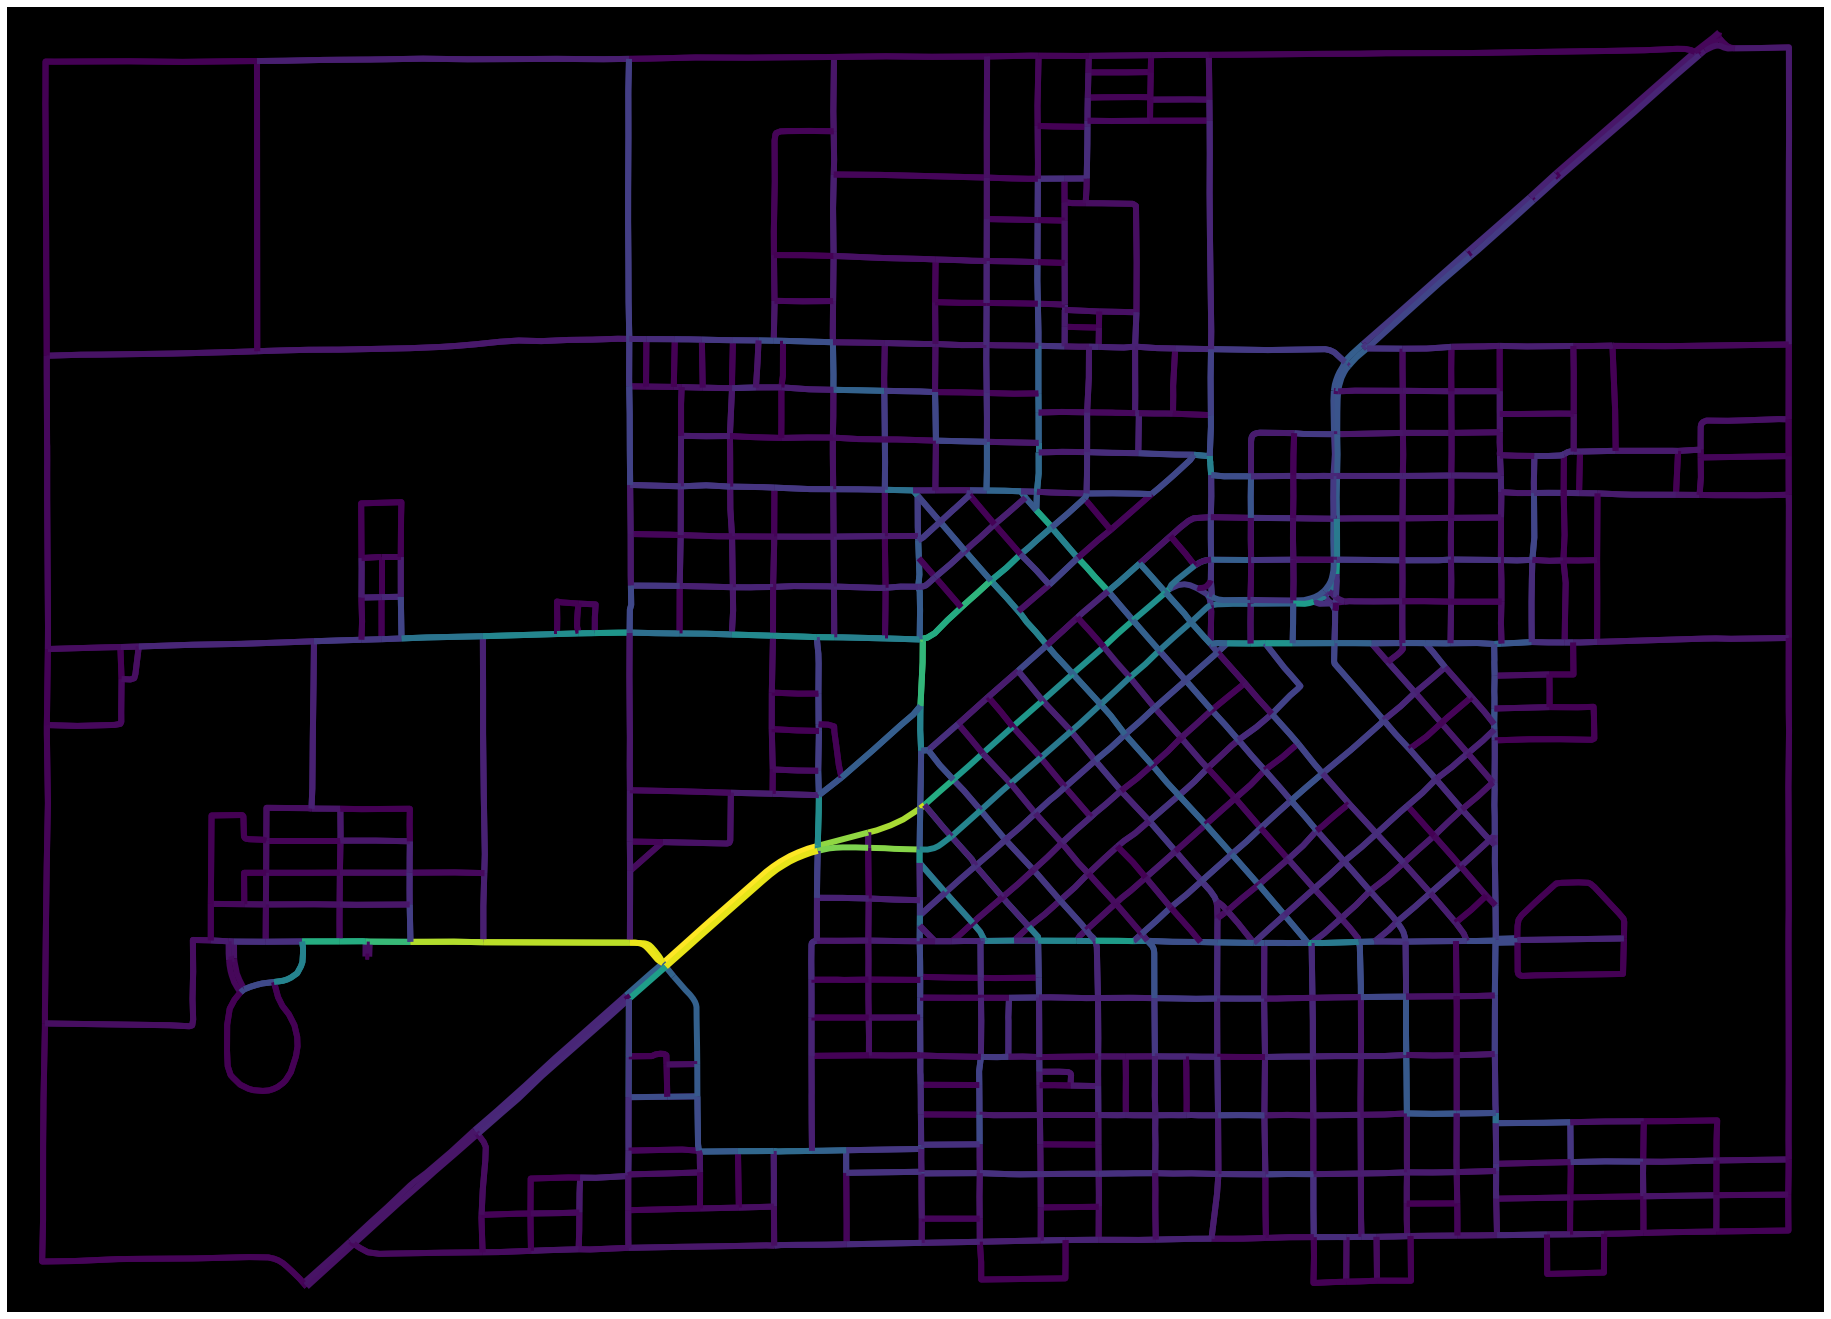

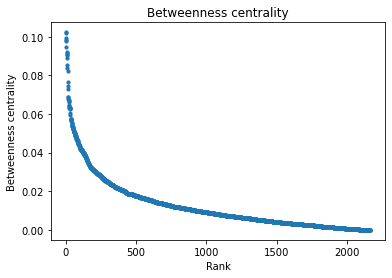

In [102]:
# load data from a binary pickle file 
fname = cent_dir + 'bc_simplified_with_aggr_num.pkl'
rf = open(fname,"rb")
bc = pickle.load(rf)
rf.close()

nx.set_edge_attributes(G1, bc, "betweenness_centrality")

bet_edge_col = ox.plot.get_edge_colors_by_attr(G1, "betweenness_centrality", cmap='viridis', start=0, stop=1, na_color='none')
bet_fig, bet_ax = ox.plot_graph(G1, figsize=(40,24), node_color='b', node_size=0,
                                edge_linewidth=6, edge_color=bet_edge_col, show=False, close=False, bgcolor='black')

"""
# Add a legend
cmap = plt.cm.get_cmap('viridis')
norm = plt.Normalize(vmin=min(bc.values()), vmax=max(bc.values()))
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cb = bet_fig.colorbar(sm, fraction=0.05, pad=0.04, orientation='horizontal')
cb.set_label('Betweenness centrality', fontsize = 20)
cb.ax.tick_params(labelsize=20)

bet_fig.suptitle(t='Betweenneess centrality in simplified network (w/ aggr_num)', y=0.93, size=40)
"""
plt.show()
plt.close('all')

bc_vals = sorted(bc.values(), reverse=True)
x = [i for i in range(0, len(bc_vals))]

plt.scatter(x, bc_vals, s=10)
plt.title('Betweenness centrality')
plt.xlabel('Rank')
plt.ylabel('Betweenness centrality')

plt.show()
plt.close('all')

Below code shows standard $C^B$ distribution in simplified graph

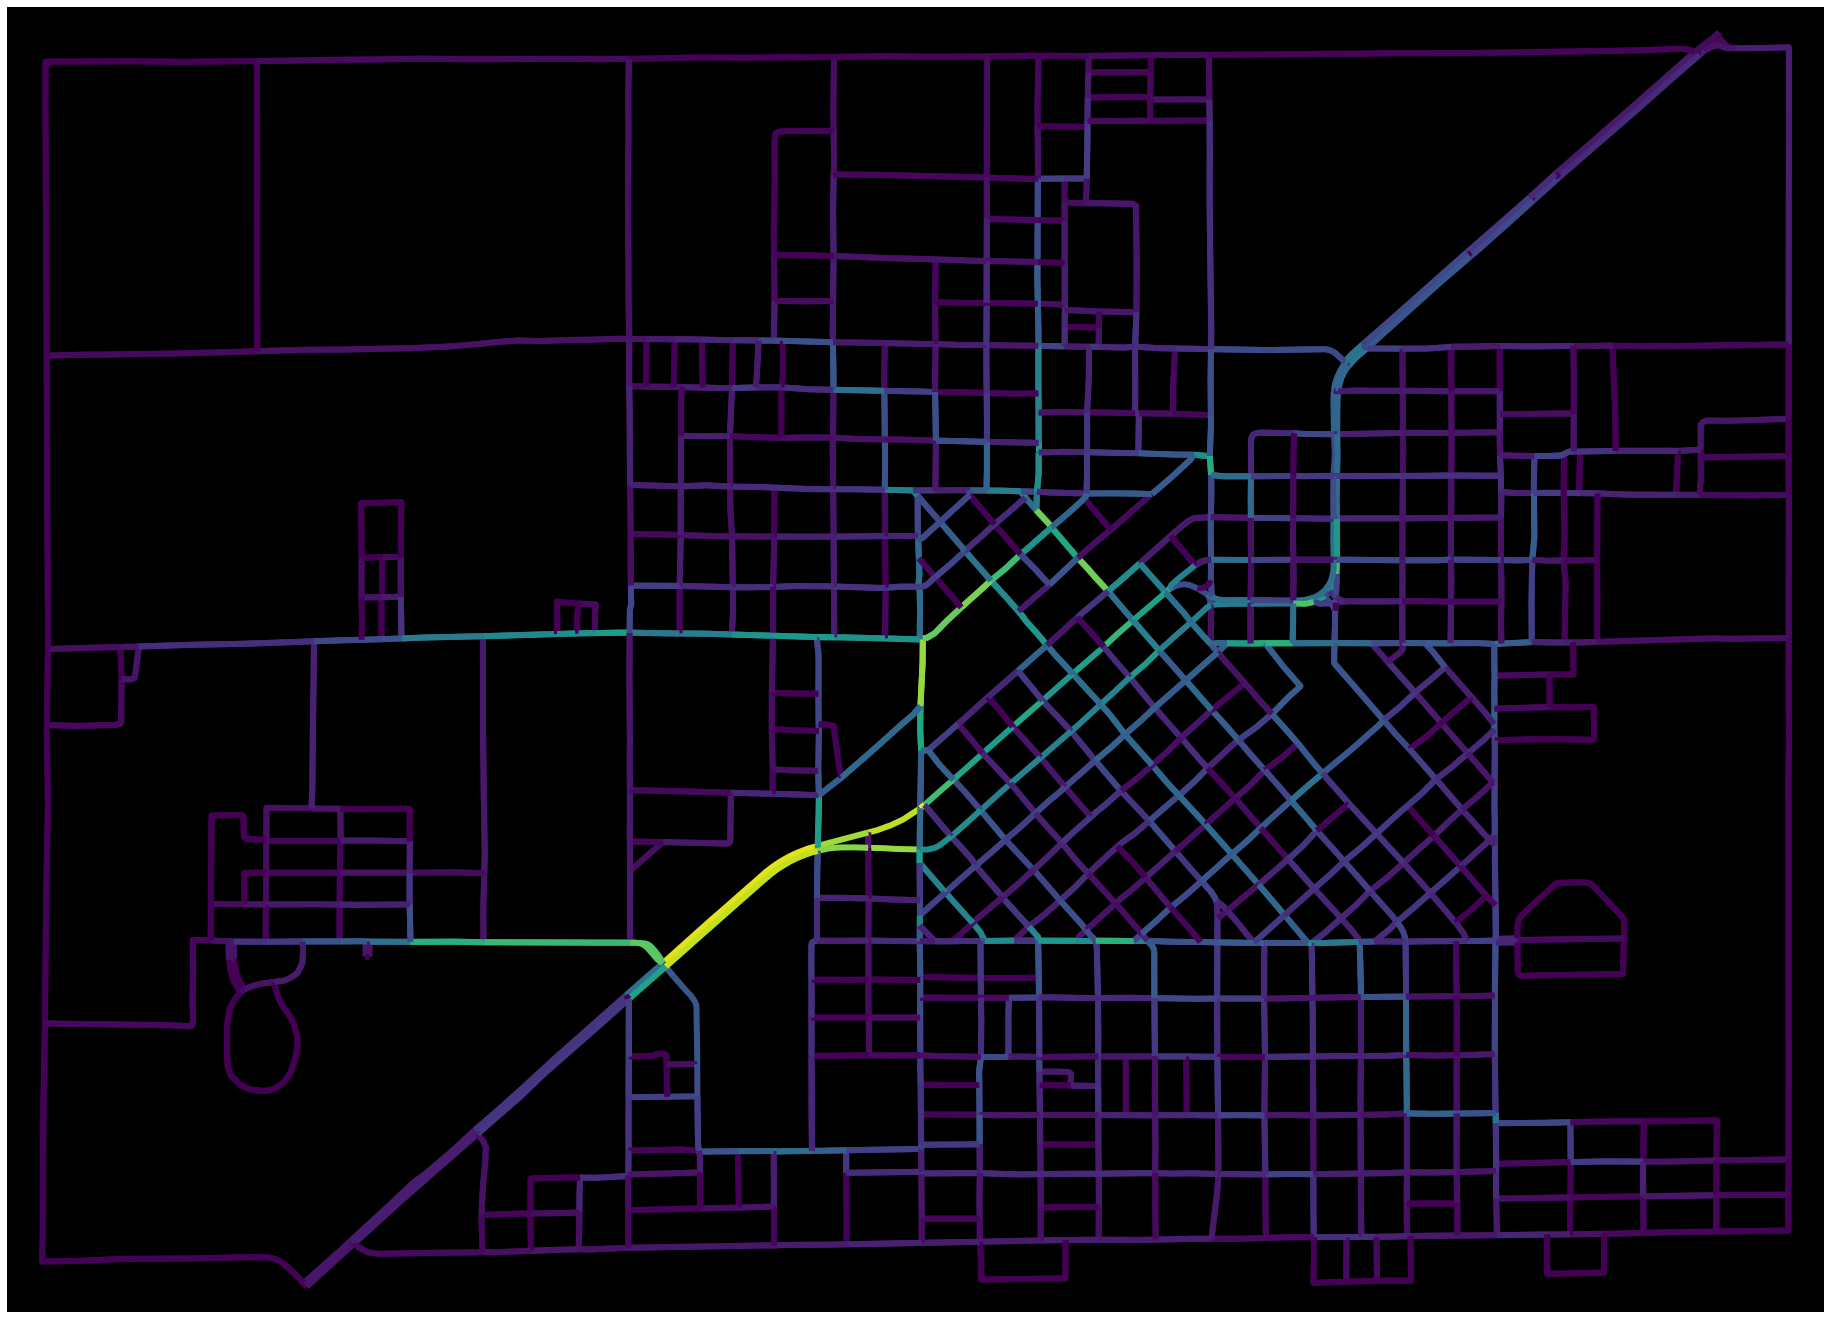

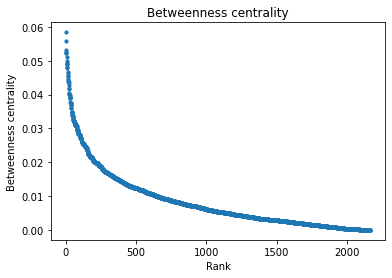

In [103]:
# Get betweenness centrality of each edge
G2 = nx.DiGraph(G1)
bet_cent=nx.edge_betweenness_centrality(G2, weight='length')

# Add betweenness centrality to edge attribute
formatted_bet_cent = {}
for (u, v), value in bet_cent.items():
    keys = list(G1.get_edge_data(u,v).keys())
    if len(keys) != 1: raise ValueError('Simplified graph has multi-edge')
    key = keys[0]
    formatted_bet_cent[(u, v, key)] = value

#nx.set_edge_attributes(G1, 0, "betweenness_centrality")
nx.set_edge_attributes(G1, formatted_bet_cent, "betweenness_centrality")
bc = nx.get_edge_attributes(G1, 'betweenness_centrality')

bet_edge_col = ox.plot.get_edge_colors_by_attr(G1, "betweenness_centrality", cmap='viridis', start=0, stop=1, na_color='none')
bet_fig, bet_ax = ox.plot_graph(G1, figsize=(40,24), node_color='b', node_size=0,
                                edge_linewidth=6, edge_color=bet_edge_col, show=False, close=False, bgcolor='black')

"""
# Add a legend
cmap = plt.cm.get_cmap('viridis')
norm = plt.Normalize(vmin=min(bc.values()), vmax=max(bc.values()))
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cb = bet_fig.colorbar(sm, fraction=0.05, pad=0.04, orientation='horizontal')
cb.set_label('Betweenness centrality', fontsize = 20)
cb.ax.tick_params(labelsize=20)

bet_fig.suptitle(t='Betweenneess centrality in simplified network', y=0.93, size=40)
"""
plt.show()
plt.close('all')

bc_vals = sorted(bc.values(), reverse=True)
x = [i for i in range(0, len(bc_vals))]

plt.scatter(x, bc_vals, s=10)
plt.title('Betweenness centrality')
plt.xlabel('Rank')
plt.ylabel('Betweenness centrality')

plt.show()
plt.close('all')

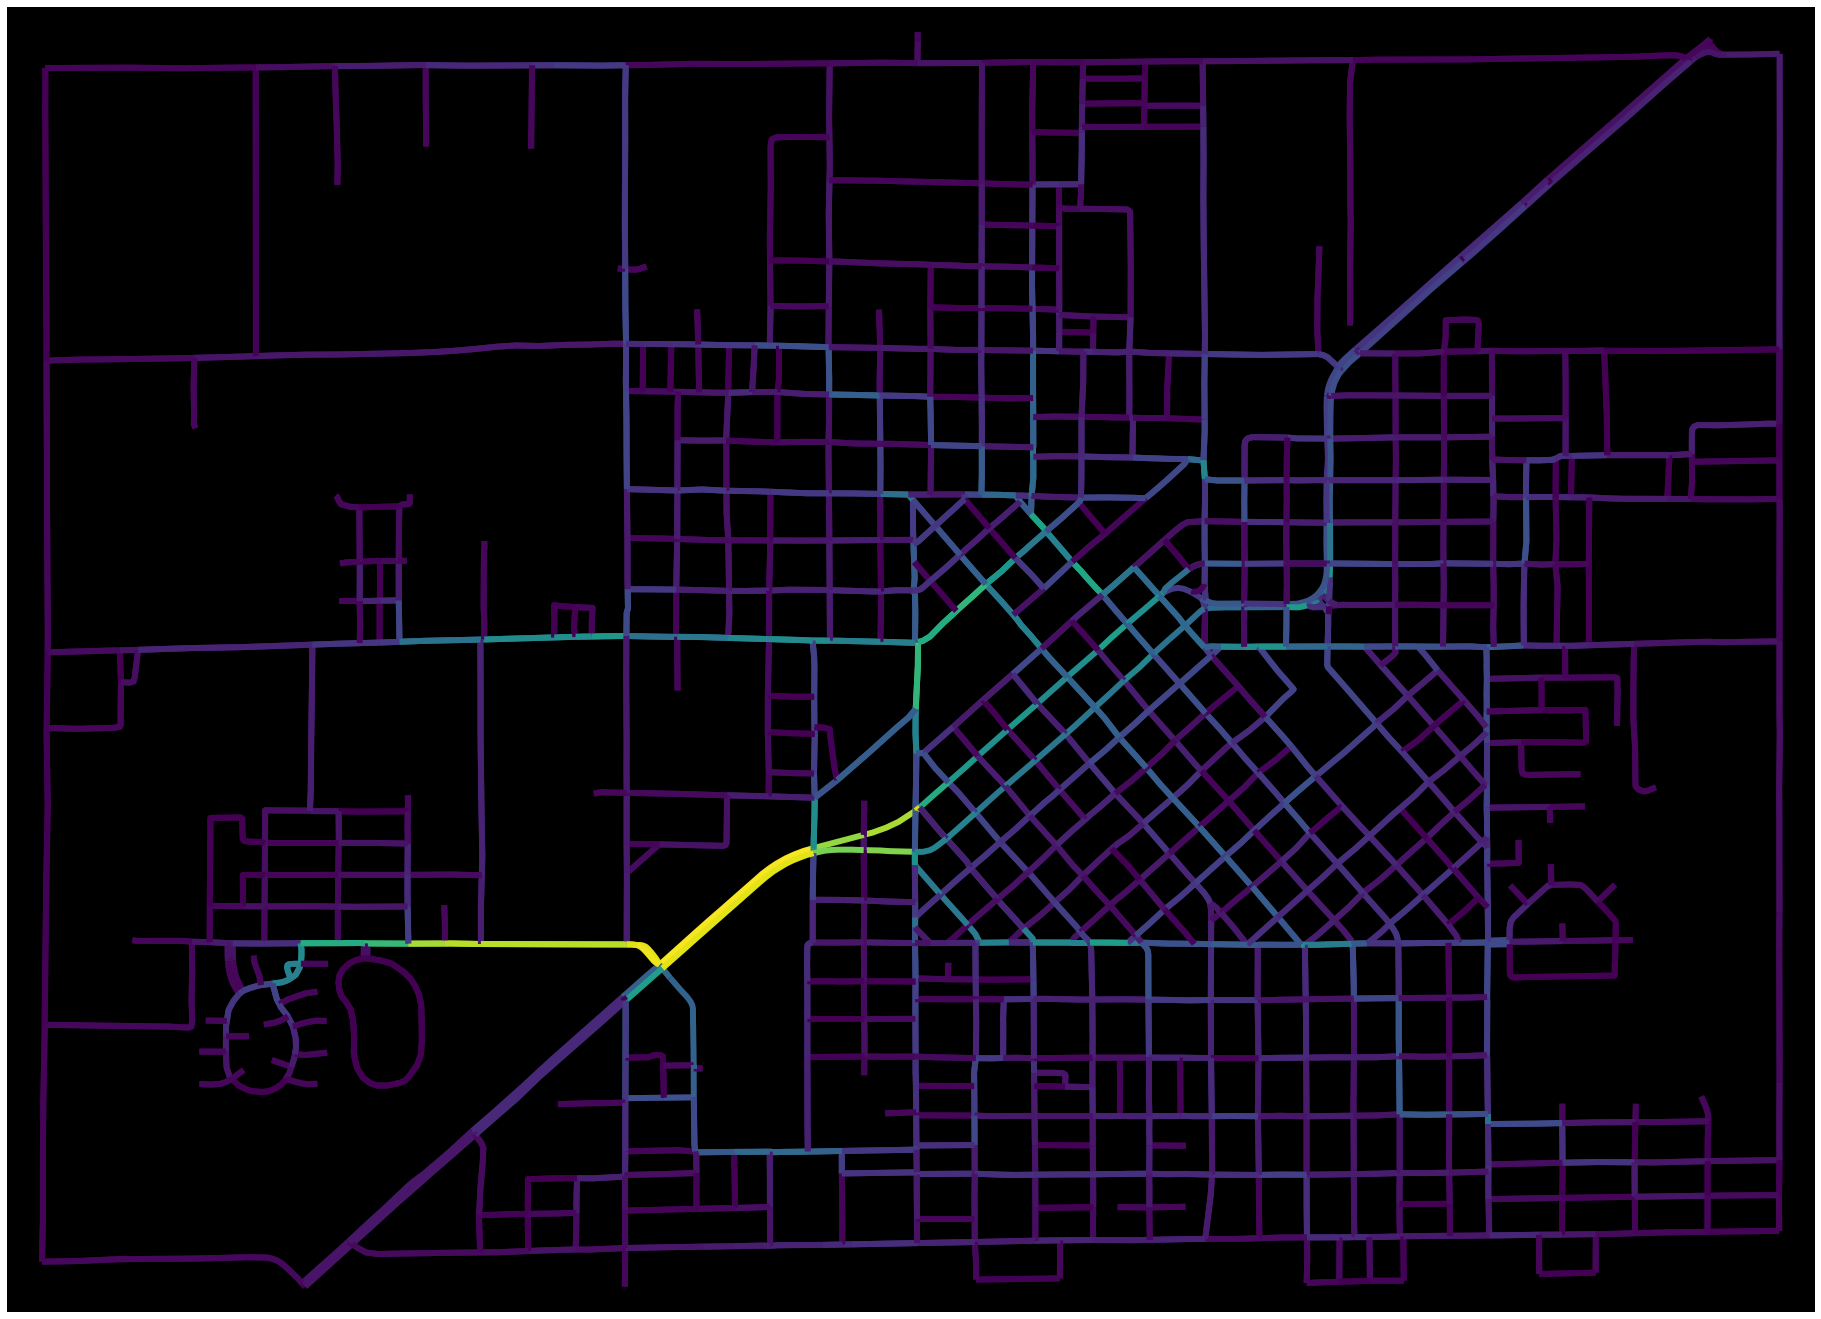

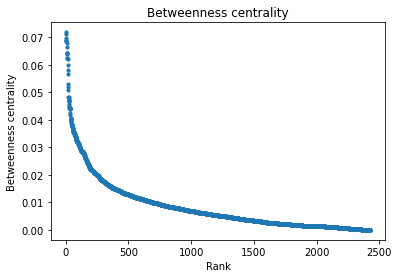

In [53]:
# Get betweenness centrality of each edge
G2 = nx.DiGraph(G)
bet_cent=nx.edge_betweenness_centrality(G2, weight='length')

# Add betweenness centrality to edge attribute
formatted_bet_cent = {}
for (u, v), value in bet_cent.items():
    formatted_bet_cent[(u, v, 0)] = value

# Fill missing values for multi-edges
for (u,v,k) in G.edges:    
    if not (u,v,k) in formatted_bet_cent:
        formatted_bet_cent[(u,v,k)] = formatted_bet_cent[(u,v,0)]

nx.set_edge_attributes(G, 0, "betweenness_centrality")
nx.set_edge_attributes(G, formatted_bet_cent, "betweenness_centrality")
bc = nx.get_edge_attributes(G, 'betweenness_centrality')

bet_edge_col = ox.plot.get_edge_colors_by_attr(G, "betweenness_centrality", cmap='viridis', start=0, stop=1, na_color='none')
bet_fig, bet_ax = ox.plot_graph(G, figsize=(40,24), node_color='b', node_size=0,
                                edge_linewidth=6, edge_color=bet_edge_col, show=False, close=False, bgcolor='black')

"""
# Add a legend
cmap = plt.cm.get_cmap('viridis')
norm = plt.Normalize(vmin=min(bc.values()), vmax=max(bc.values()))
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cb = bet_fig.colorbar(sm, fraction=0.05, pad=0.04, orientation='horizontal')
cb.set_label('Betweenness centrality', fontsize = 20)
cb.ax.tick_params(labelsize=20)

bet_fig.suptitle(t='Betweenneess centrality in original network', y=0.93, size=40)
"""

plt.show()
plt.close('all')

bc_vals = sorted(bc.values(), reverse=True)
x = [i for i in range(0, len(bc_vals))]

plt.scatter(x, bc_vals, s=10)
plt.title('Betweenness centrality')
plt.xlabel('Rank')
plt.ylabel('Betweenness centrality')

plt.show()
plt.close('all')

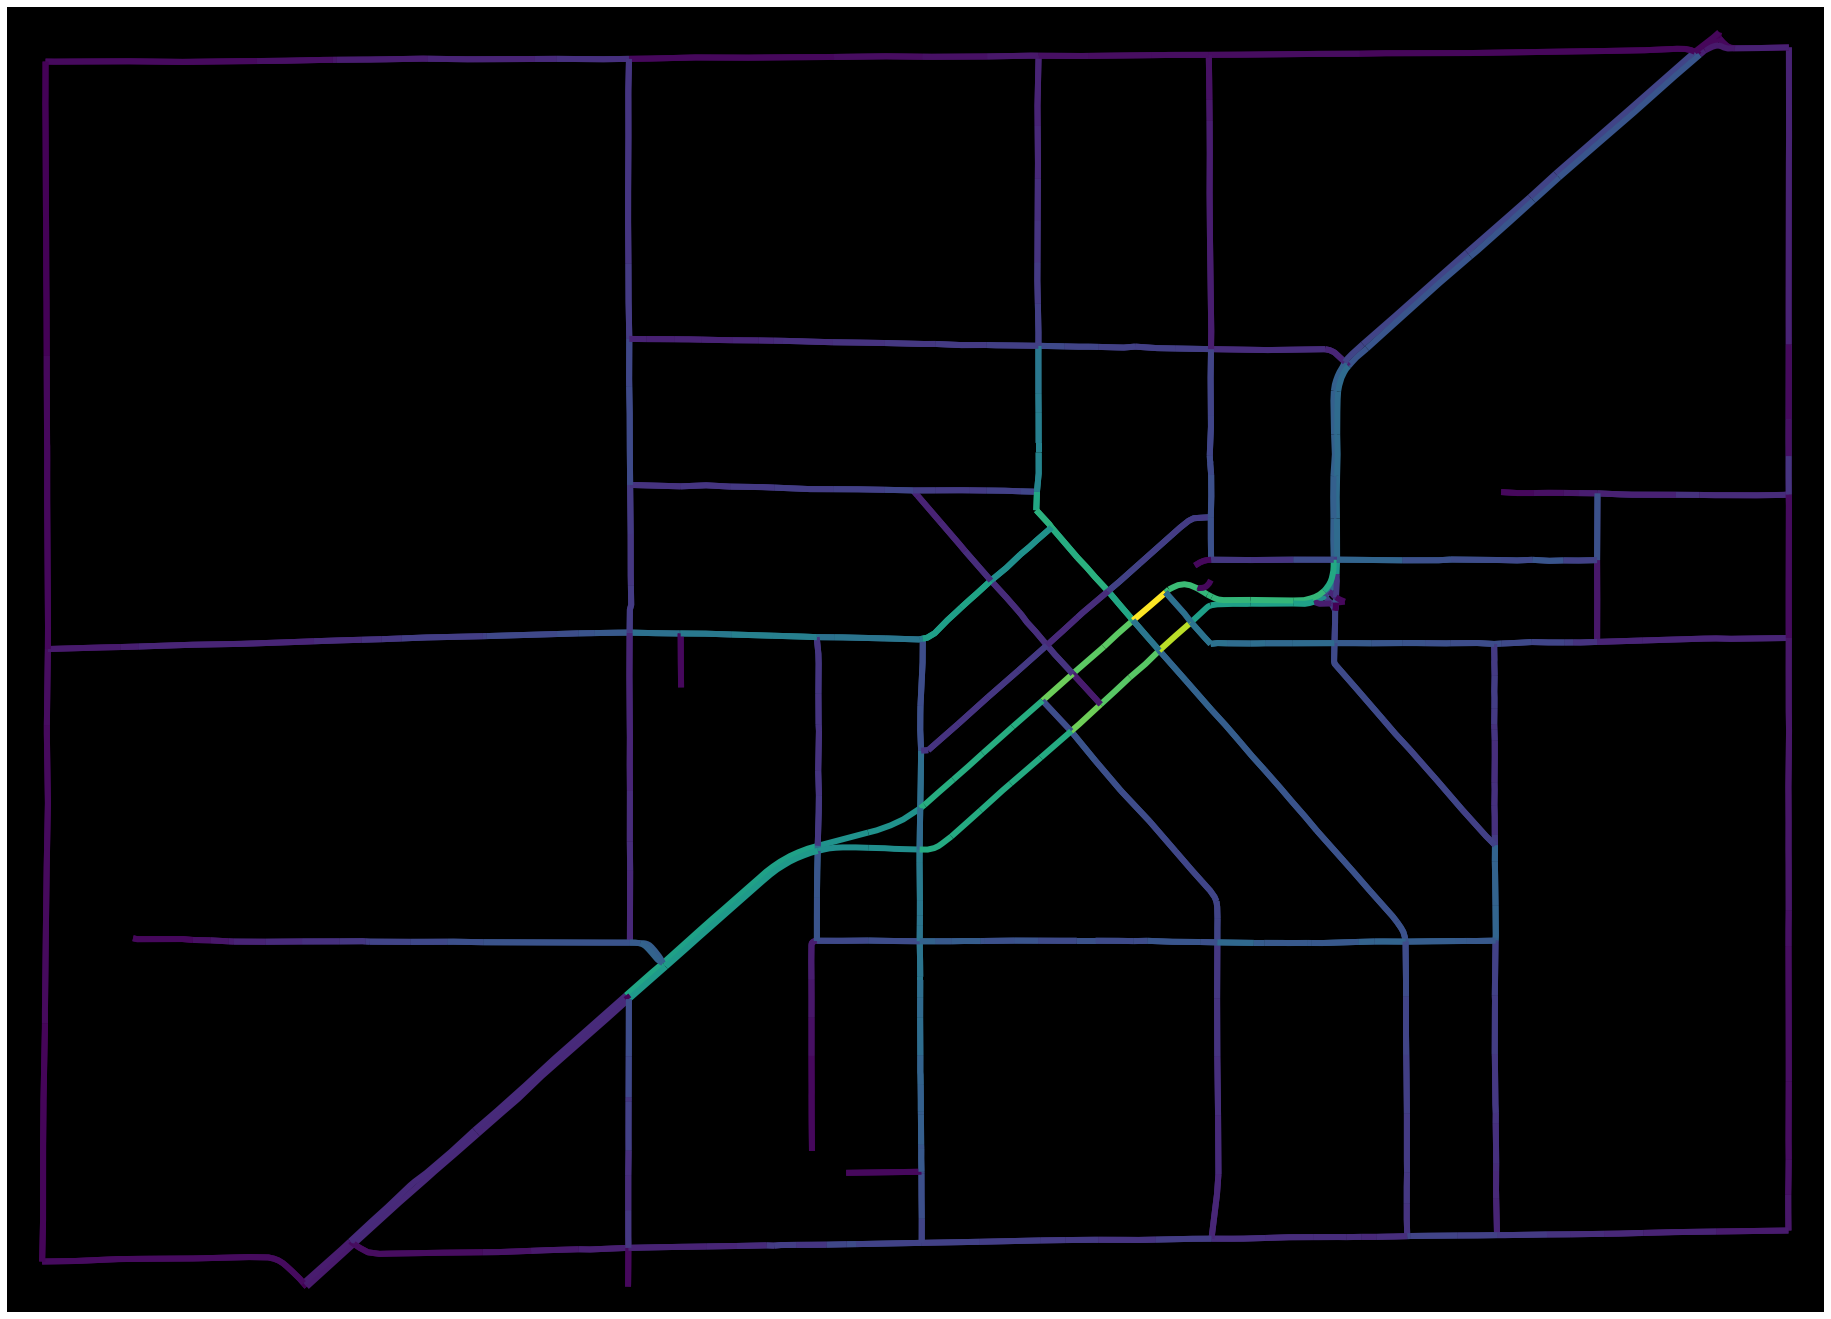

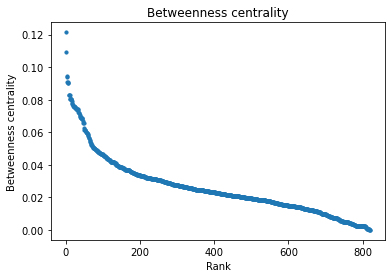

In [55]:
# Get betweenness centrality of each edge
G2 = nx.DiGraph(G_wo_res)
bet_cent=nx.edge_betweenness_centrality(G2, weight='length')

# Add betweenness centrality to edge attribute
formatted_bet_cent = {}
for (u, v), value in bet_cent.items():
    formatted_bet_cent[(u, v, 0)] = value

# Fill missing values for multi-edges
for (u,v,k) in G_wo_res.edges:    
    if not (u,v,k) in formatted_bet_cent:
        formatted_bet_cent[(u,v,k)] = formatted_bet_cent[(u,v,0)]

nx.set_edge_attributes(G_wo_res, formatted_bet_cent, "betweenness_centrality")
bc = nx.get_edge_attributes(G_wo_res, 'betweenness_centrality')

bet_edge_col = ox.plot.get_edge_colors_by_attr(G_wo_res, "betweenness_centrality", cmap='viridis', start=0, stop=1, na_color='none')
bet_fig, bet_ax = ox.plot_graph(G_wo_res, figsize=(40,24), node_color='b', node_size=0,
                                edge_linewidth=6, edge_color=bet_edge_col, show=False, close=False, bgcolor='black')

"""
# Add a legend
cmap = plt.cm.get_cmap('viridis')
norm = plt.Normalize(vmin=min(bc.values()), vmax=max(bc.values()))
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cb = bet_fig.colorbar(sm, fraction=0.05, pad=0.04, orientation='horizontal')
cb.set_label('Betweenness centrality', fontsize = 20)
cb.ax.tick_params(labelsize=20)

bet_fig.suptitle(t='Betweenneess centrality in original network', y=0.93, size=40)
"""

plt.show()
plt.close('all')

bc_vals = sorted(bc.values(), reverse=True)
x = [i for i in range(0, len(bc_vals))]

plt.scatter(x, bc_vals, s=10)
plt.title('Betweenness centrality')
plt.xlabel('Rank')
plt.ylabel('Betweenness centrality')

plt.show()
plt.close('all')

In [57]:
# load data from binary pickle files
fname = cent_dir + 'bc_original.pkl'
rf = open(fname,"rb")
bc_org = pickle.load(rf)
rf.close()

fname = cent_dir + 'bc_simplified.pkl'
rf = open(fname,"rb")
bc_simple = pickle.load(rf)
rf.close()

fname = cent_dir + 'bc_simplified_with_aggr_num.pkl'
rf = open(fname,"rb")
bc_simple_aggr = pickle.load(rf)
rf.close()

def get_bc_for_simple_graph(org_bc_dic, simple_G, edge):
    u,v,k = edge
    edge_data = simple_G.get_edge_data(u,v,k)
    edge_betweenness_centrality = 0
    
    if 'consolidated_edges' in edge_data:
        """ # average value for consolidated edges
        for edge_segment in edge_data['consolidated_edges']:
            edge_betweenness_centrality += org_bc_dic[edge_segment]
        edge_betweenness_centrality = edge_betweenness_centrality / len(edge_data['consolidated_edges'])
        """
        # maximum value for consolidated edges
        consolidated_edge_vals = []
        for edge_segment in edge_data['consolidated_edges']:
            consolidated_edge_vals.append(org_bc_dic[edge_segment])
        edge_betweenness_centrality = max(consolidated_edge_vals)
    else:
        edge_betweenness_centrality = org_bc_dic[edge]
    
    return edge_betweenness_centrality

bc_data = {edge: [] for edge in G1.edges(keys=True)}

for edge in bc_data:
    bc_data[edge].append(get_bc_for_simple_graph(bc_org, G1, edge))
    bc_data[edge].append(bc_simple[edge])
    bc_data[edge].append(bc_simple_aggr[edge])

bc_df = pd.DataFrame.from_dict(bc_data, orient='index', columns=['org', 'simple', 'simple_aggr'])
display(bc_df)

org    simple  simple_aggr
(143349350, 143349364, 0)   0.002889  0.003331     0.004133
(143349350, 143383314, 0)   0.010860  0.012517     0.015740
(143349350, 143462244, 0)   0.024331  0.024167     0.035307
(143349364, 143349350, 0)   0.011098  0.012825     0.016069
(143349364, 143447714, 0)   0.011233  0.012501     0.016080
...                              ...       ...          ...
(3238913059, 143461315, 0)  0.003356  0.003956     0.005065
(4134309989, 143351985, 0)  0.001474  0.001689     0.002074
(4134309989, 143351970, 0)  0.002149  0.002412     0.003029
(4134309989, 143352236, 0)  0.033516  0.029489     0.048003
(4134309989, 143351813, 0)  0.034043  0.030947     0.048647

[2165 rows x 3 columns]

In [58]:
bc_df.corr(method='pearson')

org    simple  simple_aggr
org          1.000000  0.949129     0.996394
simple       0.949129  1.000000     0.953617
simple_aggr  0.996394  0.953617     1.000000

In [59]:
bc_df.corr(method='spearman')

org    simple  simple_aggr
org          1.000000  0.956242     0.985211
simple       0.956242  1.000000     0.970790
simple_aggr  0.985211  0.970790     1.000000

In [60]:
# Compare org network and network omitted all the residential roads
fname = cent_dir + 'bc_res_omitted.pkl'
rf = open(fname,"rb")
bc_res_omitted = pickle.load(rf)
rf.close()

bc_data = {edge: [] for edge in G_wo_res.edges(keys=True)}

for edge in bc_data:
    bc_data[edge].append(bc_org[edge])
    bc_data[edge].append(bc_res_omitted[edge])

bc_df = pd.DataFrame.from_dict(bc_data, orient='index', columns=['org', 'res_omitted'])
display(bc_df)

org  res_omitted
(143349350, 143462244, 0)    0.024331     0.068529
(143349364, 143447714, 0)    0.011233     0.080415
(143349368, 143349364, 0)    0.019444     0.080427
(143349370, 143447714, 0)    0.000862     0.002481
(143349374, 143462253, 0)    0.002625     0.028077
...                               ...          ...
(3641572207, 143461931, 0)   0.027767     0.047946
(3641572207, 3641572205, 0)  0.001259     0.002488
(3641572207, 143352236, 0)   0.028470     0.048945
(4134309989, 143352236, 0)   0.033516     0.052413
(4134309989, 143351813, 0)   0.034043     0.052121

[821 rows x 2 columns]

In [61]:
bc_df.corr(method='pearson')

org  res_omitted
org          1.000000     0.593178
res_omitted  0.593178     1.000000

In [62]:
bc_df.corr(method='spearman')

org  res_omitted
org          1.000000     0.686913
res_omitted  0.686913     1.000000

In [7]:
## Information centrality, weight as edge length ##

# dictionary for euclidean distance between two nodes
eucDis_dic = {}

# Get euc_distances in the original graph
for src in G.nodes:
    for dst in G.nodes:
        if src != dst:
            pair = (src, dst)
            if pair not in eucDis_dic:
                src_x = G.nodes[src]['x']
                src_y = G.nodes[src]['y']
                src_coord = (src_y, src_x) # lat, long
                
                dst_x = G.nodes[dst]['x']
                dst_y = G.nodes[dst]['y']
                dst_coord = (dst_y, dst_x) # lat, long
                
                eu_d = geopy.distance.distance(src_coord, dst_coord).m # distance in meter
                
                r_pair = (dst, src)
                
                # order does not matter in euclidean distance 
                eucDis_dic[pair] = eu_d
                eucDis_dic[r_pair] = eu_d

In [8]:
path_len = nx.shortest_path_length(G, weight='length')
num_node = G.number_of_nodes()

# Compute the efficiency of the original graph (before cutting any edge)
eff = 0
for src, len_dic in path_len:
    for dst in len_dic:
        if src!= dst:
            eu_d = eucDis_dic[(src, dst)]
            d = len_dic[dst]
            eff += (eu_d/d) / (num_node *(num_node-1))
            
print(eff)

0.810829070643858


In [9]:
# Define a function that comptute info. cent. of each edge
def info_cent(org_G_eff, input_G):
    count=1
    
    num_node = input_G.number_of_nodes()
    num_edge = input_G.number_of_edges()
    
    print('Compute information centrality in the input graph with', num_edge, 'edges')
    total_start_time = time.time()
    
    for u,v,k in input_G.edges:
        print('Working on edge', count)
        start_time = time.time()
        
        cut_G = input_G.copy()
        cut_G.remove_edge(u,v,k)
        
        path_len = nx.shortest_path_length(cut_G, weight='length')

        cut_G_eff = 0
        for src, len_dic in path_len:
            for dst in len_dic:
                if src!= dst:
                    eu_d = eucDis_dic[(src, dst)]
                    d = len_dic[dst]
                    cut_G_eff += (eu_d/d) / (num_node *(num_node-1))
        input_G.edges[(u,v,k)]['info_cent'] = (org_G_eff - cut_G_eff) / org_G_eff
        
        end_time = time.time()
        if count == 1:
            elapsed_time = end_time - start_time
            print('Estimated time cost to finish:', elapsed_time * num_edge, 'seconds')
        count += 1
        
    total_end_time = time.time()
    total_elapsed_time = total_end_time - total_start_time
    
    print('Elapsed time for the computation: ', total_elapsed_time, 'seconds')

In [10]:
# Measure edge information centrality of the original graph
info_cent(eff, G)

Compute information centrality in the input graph with 2428 edges
Working on edge 1
Estimated time cost to finish: 10626.514534950256 seconds
Working on edge 2
Working on edge 3
Working on edge 4
Working on edge 5
Working on edge 6
Working on edge 7
Working on edge 8
Working on edge 9
Working on edge 10
Working on edge 11
Working on edge 12
Working on edge 13
Working on edge 14
Working on edge 15
Working on edge 16
Working on edge 17
Working on edge 18
Working on edge 19
Working on edge 20
Working on edge 21
Working on edge 22
Working on edge 23
Working on edge 24
Working on edge 25
Working on edge 26
Working on edge 27
Working on edge 28
Working on edge 29
Working on edge 30
Working on edge 31
Working on edge 32
Working on edge 33
Working on edge 34
Working on edge 35
Working on edge 36
Working on edge 37
Working on edge 38
Working on edge 39
Working on edge 40
Working on edge 41
Working on edge 42
Working on edge 43
Working on edge 44
Working on edge 45
Working on edge 46
Working on 

In [11]:
# define dictionary
ic_org = nx.get_edge_attributes(G, 'info_cent')

# create a binary pickle file 
f = open("centrality_measures\ic_original.pkl","wb")
pickle.dump(ic_org,f)

# close file
f.close()

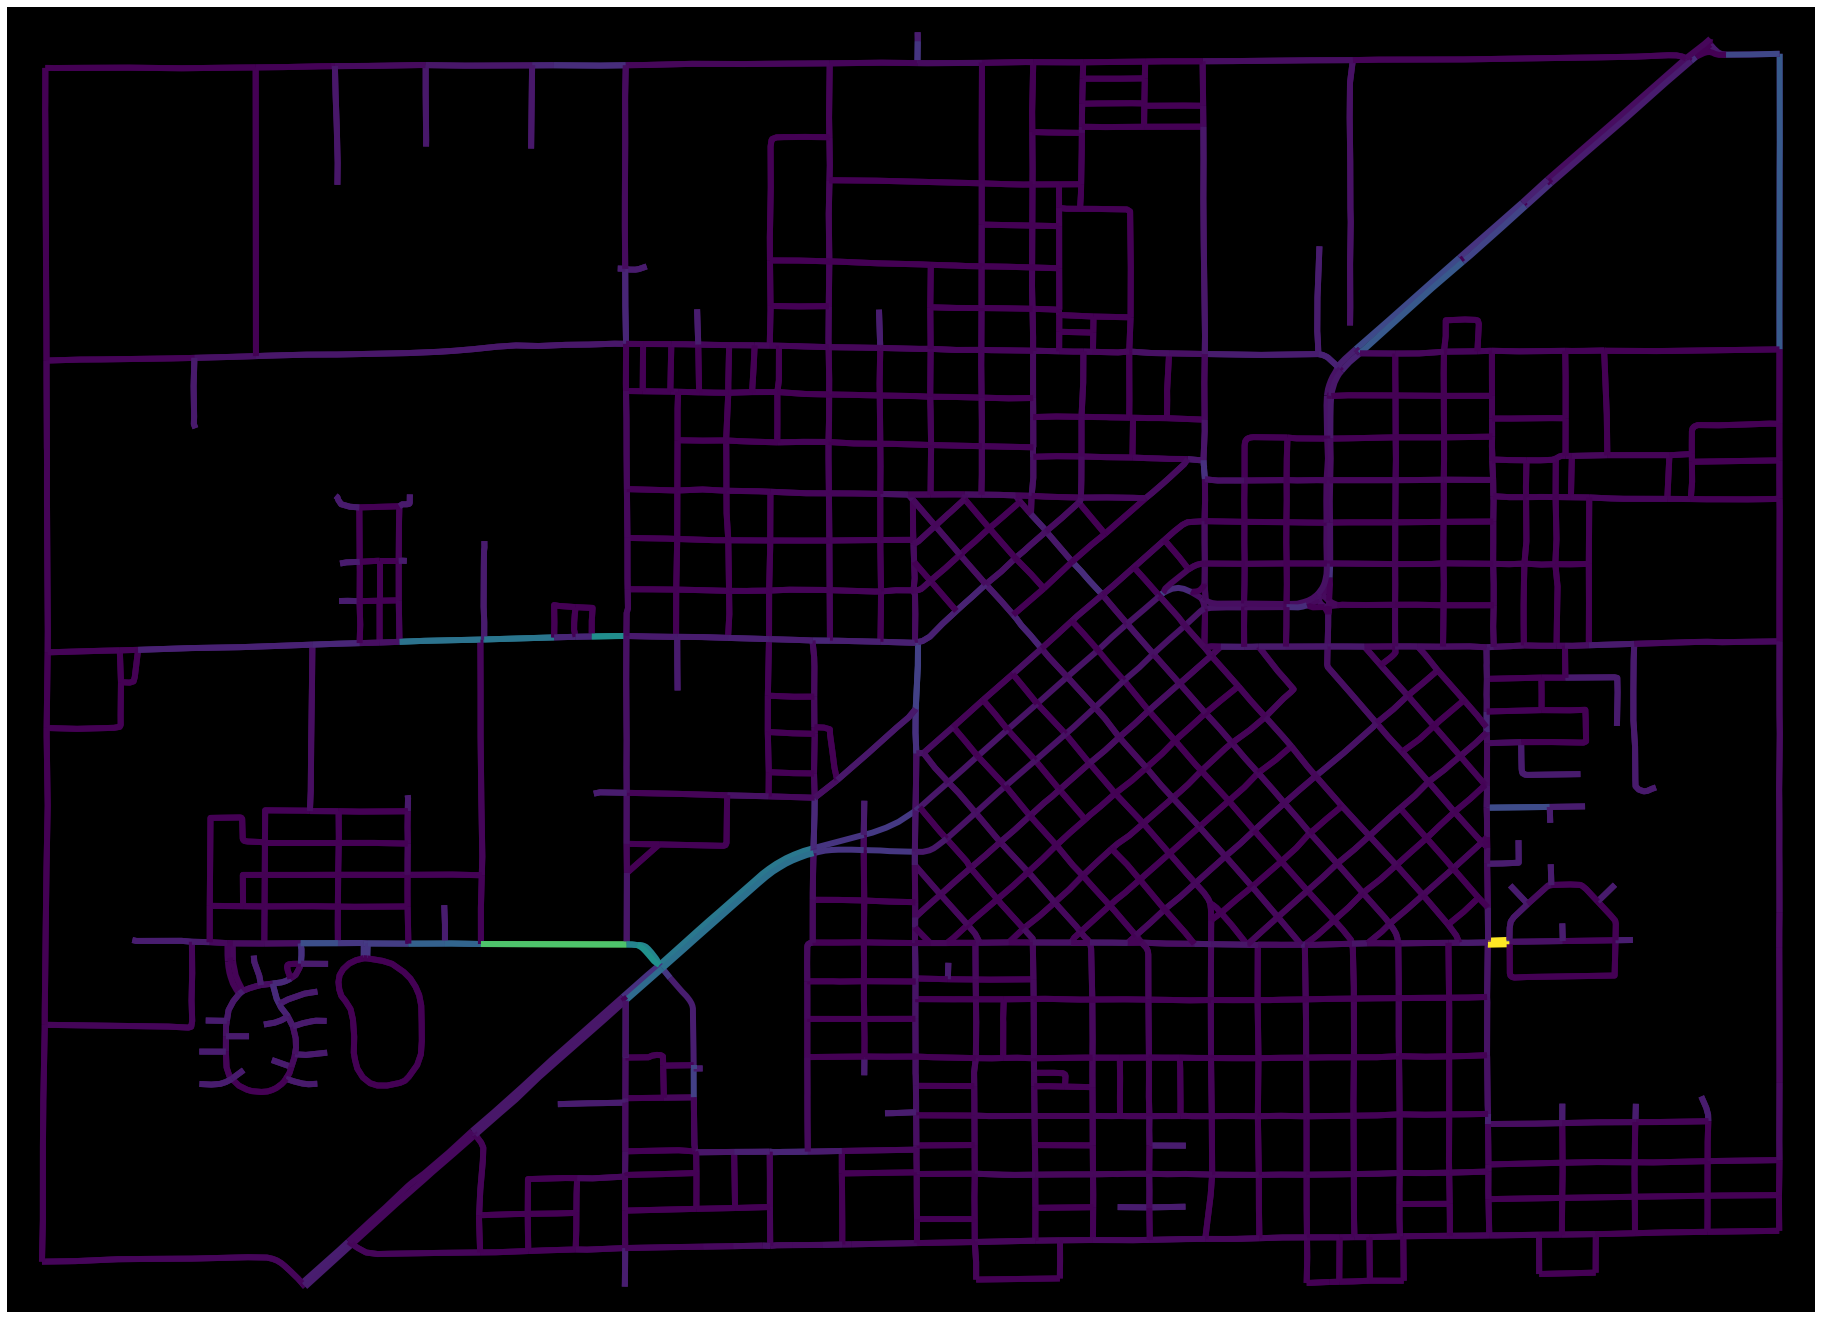

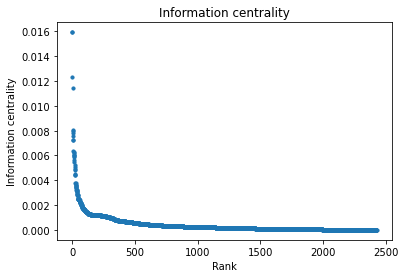

In [26]:
# load data from a binary pickle file 
fname = cent_dir + 'ic_original.pkl'
rf = open(fname,"rb")
ic = pickle.load(rf)
rf.close()

nx.set_edge_attributes(G, ic, "information_centrality")

ic_edge_col = ox.plot.get_edge_colors_by_attr(G, "information_centrality", cmap='viridis', start=0, stop=1, na_color='none')
ic_fig, ic_ax = ox.plot_graph(G, figsize=(40,24), node_color='b', node_size=0,
                                edge_linewidth=6, edge_color=ic_edge_col, show=False, close=False, bgcolor='black')
"""
# Add a legend
cmap = plt.cm.get_cmap('viridis')
norm = plt.Normalize(vmin=min(ic.values()), vmax=max(ic.values()))
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cb = ic_fig.colorbar(sm, fraction=0.05, pad=0.04, orientation='horizontal')
cb.set_label('Information centrality', fontsize = 20)
cb.ax.tick_params(labelsize=20)

ic_fig.suptitle(t='Information centrality in original network', y=0.93, size=40)
"""

plt.show()
plt.close('all')


ic_vals = sorted(ic.values(), reverse=True)
x = [i for i in range(0, len(ic_vals))]

plt.scatter(x, ic_vals, s=10)
plt.title('Information centrality')
plt.xlabel('Rank')
plt.ylabel('Information centrality')

plt.show()
plt.close('all')

In [15]:
# Compute the efficiency of the simplified graph (before cutting any edge)
path_len = nx.shortest_path_length(G1, weight='length')
num_node = G1.number_of_nodes()

eff_simple = 0
for src, len_dic in path_len:
    for dst in len_dic:
        if src!= dst:
            eu_d = eucDis_dic[(src, dst)]
            d = len_dic[dst]
            eff_simple += (eu_d/d) / (num_node *(num_node-1))
            
print('Efficiency of simplified graph:', eff_simple)

Efficiency of simplified graph: 0.8254370225573078


In [16]:
# Measure edge information centrality of the simplified graph
info_cent(eff_simple, G1)

Compute information centrality in the input graph with 2165 edges
Working on edge 1
Estimated time cost to finish: 6074.194043874741 seconds
Working on edge 2
Working on edge 3
Working on edge 4
Working on edge 5
Working on edge 6
Working on edge 7
Working on edge 8
Working on edge 9
Working on edge 10
Working on edge 11
Working on edge 12
Working on edge 13
Working on edge 14
Working on edge 15
Working on edge 16
Working on edge 17
Working on edge 18
Working on edge 19
Working on edge 20
Working on edge 21
Working on edge 22
Working on edge 23
Working on edge 24
Working on edge 25
Working on edge 26
Working on edge 27
Working on edge 28
Working on edge 29
Working on edge 30
Working on edge 31
Working on edge 32
Working on edge 33
Working on edge 34
Working on edge 35
Working on edge 36
Working on edge 37
Working on edge 38
Working on edge 39
Working on edge 40
Working on edge 41
Working on edge 42
Working on edge 43
Working on edge 44
Working on edge 45
Working on edge 46
Working on e

In [17]:
# define dictionary
ic_simple = nx.get_edge_attributes(G1, 'info_cent')

# create a binary pickle file 
f = open("./centrality_measures/Portales/ic_simplified.pkl","wb")
pickle.dump(ic_simple,f)

# close file
f.close()

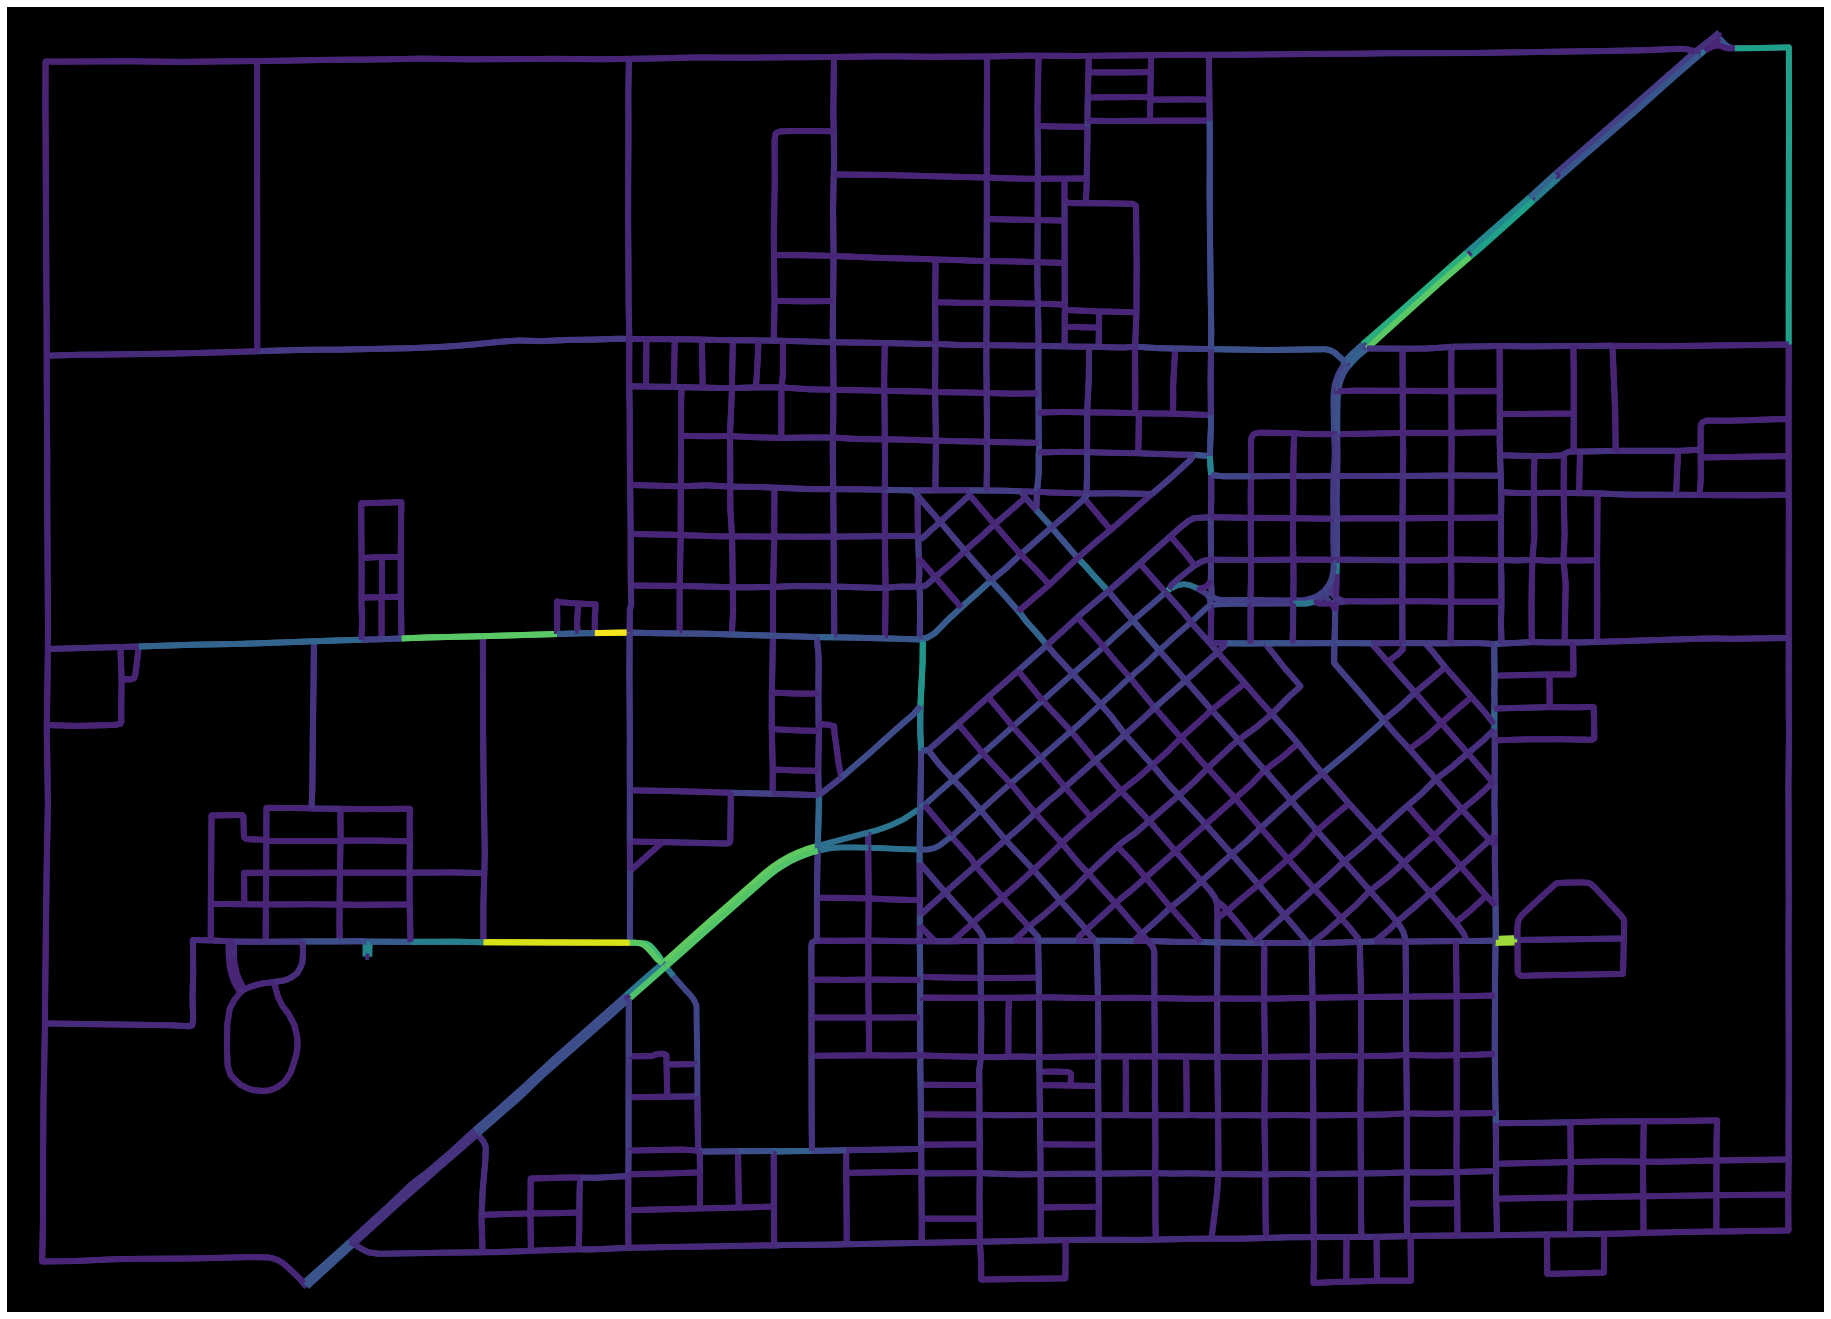

"\nic_vals = sorted(ic.values(), reverse=True)\nx = [i for i in range(0, len(ic_vals))]\n\nplt.scatter(x, ic_vals, s=10)\nplt.title('Betweenness centrality')\nplt.xlabel('Rank')\nplt.ylabel('Betweenness centrality')\n\nplt.show()\nplt.close('all')\n"

In [27]:
# load data from a binary pickle file 
fname = cent_dir + 'ic_simplified.pkl'
rf = open(fname,"rb")
ic = pickle.load(rf)
rf.close()

nx.set_edge_attributes(G1, ic, "information_centrality")

ic_edge_col = ox.plot.get_edge_colors_by_attr(G1, "information_centrality", cmap='viridis', start=0.1, stop=1, na_color='none')
ic_fig, ic_ax = ox.plot_graph(G1, figsize=(40,24), node_color='b', node_size=0,
                                edge_linewidth=6, edge_color=ic_edge_col, show=False, close=False, bgcolor='k')
"""
# Add a legend
cmap = plt.cm.get_cmap('viridis')
norm = plt.Normalize(vmin=min(ic.values()), vmax=max(ic.values()))
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cb = ic_fig.colorbar(sm, fraction=0.05, pad=0.04, orientation='horizontal')
cb.set_label('Information centrality', fontsize = 20)
cb.ax.tick_params(labelsize=20)

ic_fig.suptitle(t='Information centrality in simplified network', y=0.93, size=40)
"""
plt.show()
plt.close('all')
"""
ic_vals = sorted(ic.values(), reverse=True)
x = [i for i in range(0, len(ic_vals))]

plt.scatter(x, ic_vals, s=10)
plt.title('Betweenness centrality')
plt.xlabel('Rank')
plt.ylabel('Betweenness centrality')

plt.show()
plt.close('all')
"""

In [18]:
# Estimate efficiency of "original" graph using "simplified" graph and "aggr_node_num" attribute (before cutting any edge)
path_len = nx.shortest_path_length(G1, weight='length')
num_node = G.number_of_nodes()

eff_org_est = 0
for src, len_dic in path_len:
    aggr_src = G1.nodes[src]['aggr_node_num']
    for dst in len_dic:
        if src!= dst:
            eu_d = eucDis_dic[(src, dst)]
            d = len_dic[dst]
            
            # assume each src and dst node is a cluster, not a single node
            aggr_dst = G1.nodes[dst]['aggr_node_num']
            sigma = (eu_d/d) * aggr_src * aggr_dst
            
            # accumulate efficiency
            eff_org_est += sigma / (num_node *(num_node-1))
            
print('Estimated efficiency of original graph using simplified graph and aggr_node_num:', eff_org_est)

Estimated efficiency of original graph using simplified graph and aggr_node_num: 0.8218047177300655


In [19]:
# Define a function that estimate info. cent. in the original graph using simplified graph with aggr_node_num attribute
def modified_info_cent(org_G_eff, simplified_G, original_G):
    count=1
    
    num_node = original_G.number_of_nodes()
    num_edge = simplified_G.number_of_edges()
    
    print('Compute information centrality in the input graph with', num_edge, 'edges')
    total_start_time = time.time()
    
    for u,v,k in simplified_G.edges:
        print('Working on edge', count)
        start_time = time.time()
        
        cut_G = simplified_G.copy()
        cut_G.remove_edge(u,v,k)
        
        path_len = nx.shortest_path_length(cut_G, weight='length')

        cut_G_eff = 0
        for src, len_dic in path_len:
            aggr_src = cut_G.nodes[src]['aggr_node_num']
            for dst in len_dic:
                if src!= dst:
                    eu_d = eucDis_dic[(src, dst)]
                    d = len_dic[dst]
                    
                    # assume each src and dst node is a cluster, not a single node
                    aggr_dst = cut_G.nodes[dst]['aggr_node_num']
                    sigma = (eu_d/d) * aggr_src * aggr_dst

                    # accumulate efficiency
                    cut_G_eff += sigma / (num_node *(num_node-1))
        simplified_G.edges[(u,v,k)]['mod_info_cent'] = (org_G_eff - cut_G_eff) / org_G_eff
        
        end_time = time.time()
        if count == 1:
            elapsed_time = end_time - start_time
            print('Estimated time cost to finish:', elapsed_time * num_edge, 'seconds')
        count += 1
        
    total_end_time = time.time()
    total_elapsed_time = total_end_time - total_start_time
    
    print('Elapsed time for the computation: ', total_elapsed_time, 'seconds')

In [20]:
# Measure edge information centrality of the original graph
modified_info_cent(eff_org_est, G1, G)

Compute information centrality in the input graph with 2165 edges
Working on edge 1
Estimated time cost to finish: 6696.2220096588135 seconds
Working on edge 2
Working on edge 3
Working on edge 4
Working on edge 5
Working on edge 6
Working on edge 7
Working on edge 8
Working on edge 9
Working on edge 10
Working on edge 11
Working on edge 12
Working on edge 13
Working on edge 14
Working on edge 15
Working on edge 16
Working on edge 17
Working on edge 18
Working on edge 19
Working on edge 20
Working on edge 21
Working on edge 22
Working on edge 23
Working on edge 24
Working on edge 25
Working on edge 26
Working on edge 27
Working on edge 28
Working on edge 29
Working on edge 30
Working on edge 31
Working on edge 32
Working on edge 33
Working on edge 34
Working on edge 35
Working on edge 36
Working on edge 37
Working on edge 38
Working on edge 39
Working on edge 40
Working on edge 41
Working on edge 42
Working on edge 43
Working on edge 44
Working on edge 45
Working on edge 46
Working on 

In [21]:
# define dictionary
ic_simple_with_aggr_num = nx.get_edge_attributes(G1, 'mod_info_cent')

# create a binary pickle file 
f = open("./centrality_measures/Portales/ic_simplified_with_aggr_num.pkl","wb")
pickle.dump(ic_simple_with_aggr_num, f)

# close file
f.close()

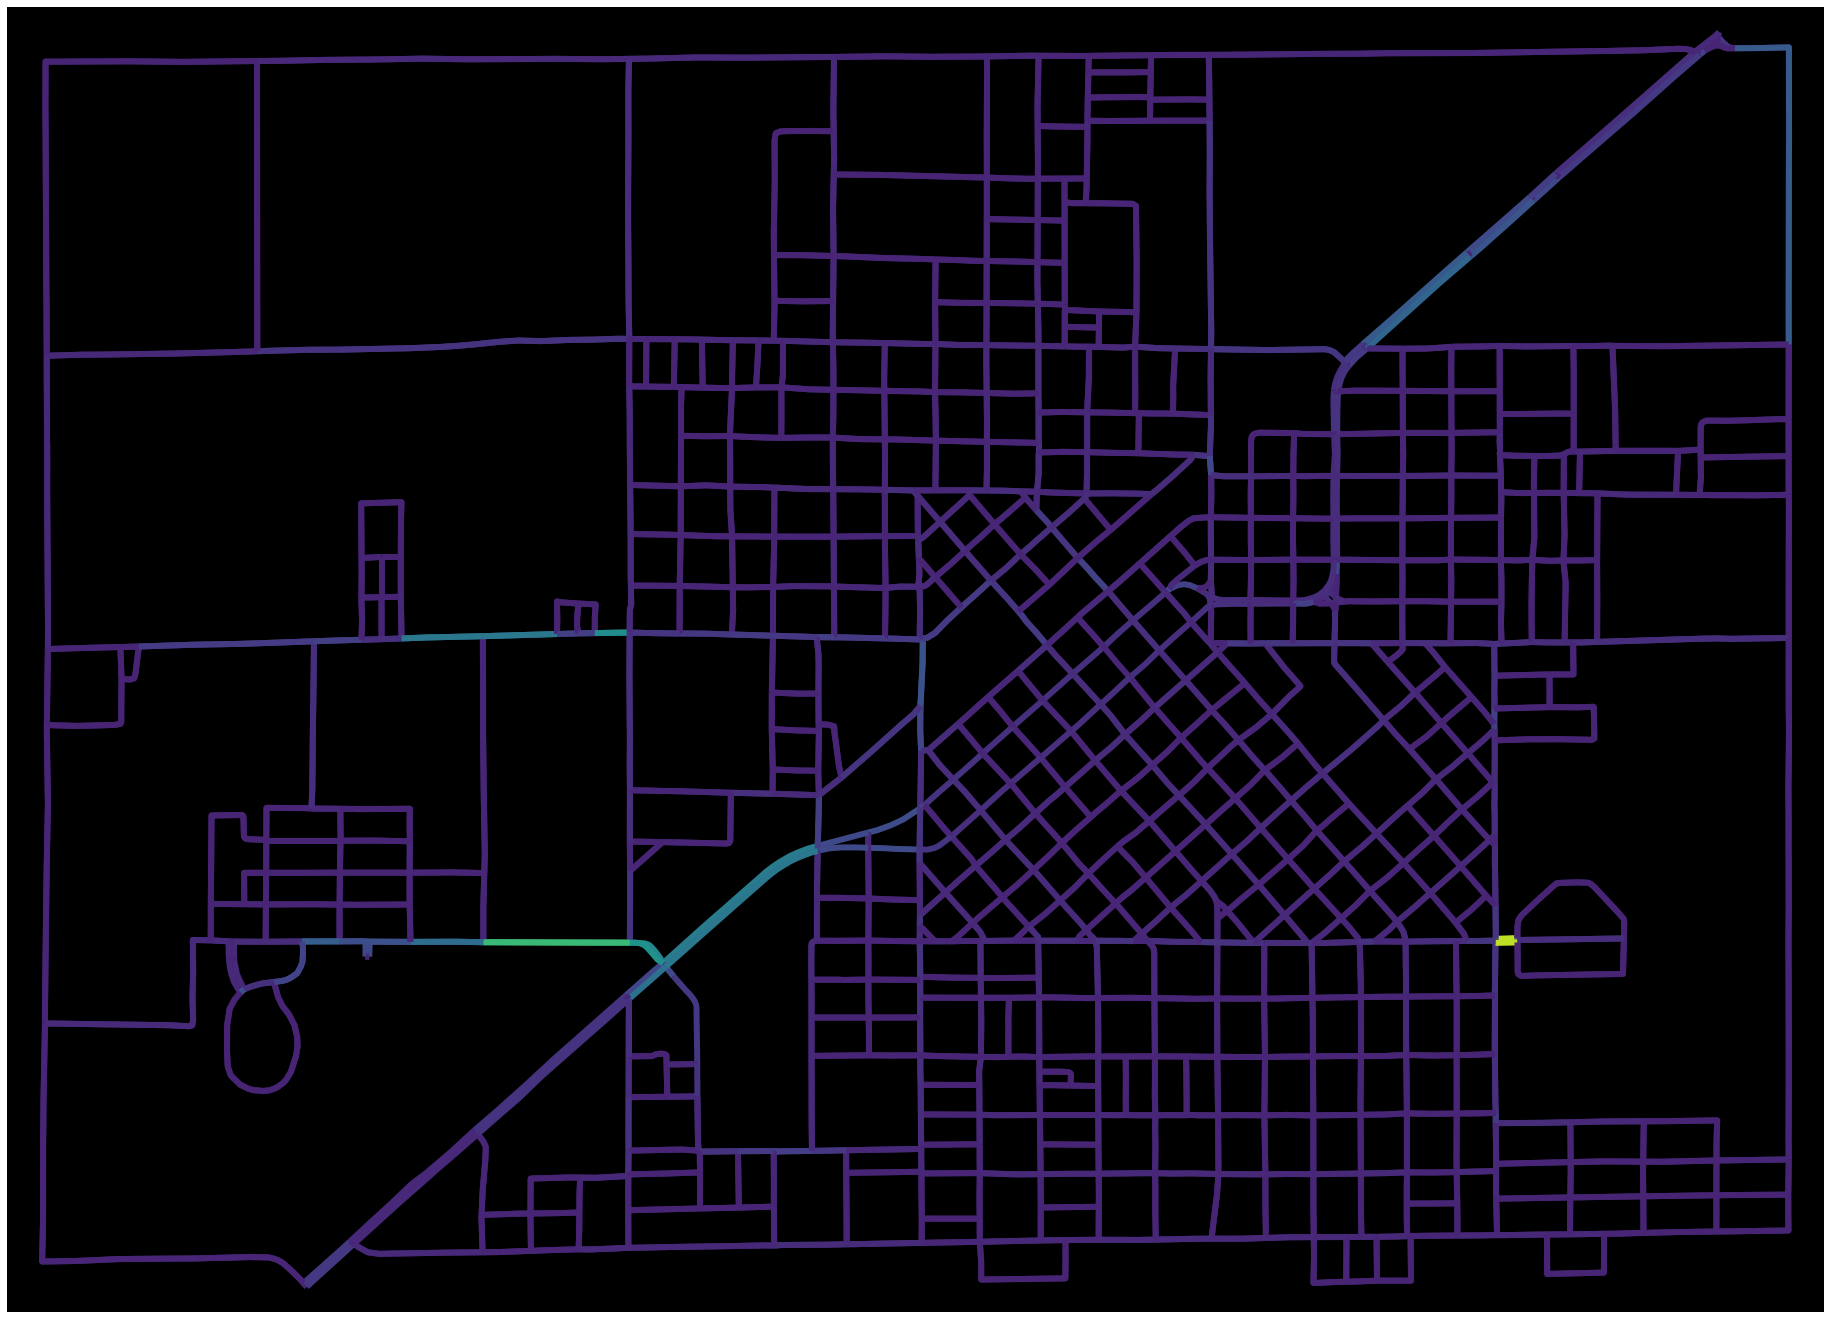

"\nic_vals = sorted(ic.values(), reverse=True)\nx = [i for i in range(0, len(ic_vals))]\n\nplt.scatter(x, ic_vals, s=10)\nplt.title('Betweenness centrality')\nplt.xlabel('Rank')\nplt.ylabel('Betweenness centrality')\n\nplt.show()\nplt.close('all')\n"

In [28]:
# load data from a binary pickle file 
fname = cent_dir + 'ic_simplified_with_aggr_num.pkl'
rf = open(fname,"rb")
ic = pickle.load(rf)
rf.close()

nx.set_edge_attributes(G1, ic, "information_centrality")

ic_edge_col = ox.plot.get_edge_colors_by_attr(G1, "information_centrality", cmap='viridis', start=0.1, stop=0.9, na_color='none')
ic_fig, ic_ax = ox.plot_graph(G1, figsize=(40,24), node_color='b', node_size=0,
                                edge_linewidth=6, edge_color=ic_edge_col, show=False, close=False, bgcolor='k')
"""
# Add a legend
cmap = plt.cm.get_cmap('viridis')
norm = plt.Normalize(vmin=min(ic.values()), vmax=max(ic.values()))
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cb = ic_fig.colorbar(sm, fraction=0.05, pad=0.04, orientation='horizontal')
cb.set_label('Information centrality', fontsize = 20)
cb.ax.tick_params(labelsize=20)

ic_fig.suptitle(t='Information centrality in simplified network (w/ aggr_num)', y=0.93, size=40)
"""
plt.show()
plt.close('all')
"""
ic_vals = sorted(ic.values(), reverse=True)
x = [i for i in range(0, len(ic_vals))]

plt.scatter(x, ic_vals, s=10)
plt.title('Betweenness centrality')
plt.xlabel('Rank')
plt.ylabel('Betweenness centrality')

plt.show()
plt.close('all')
"""

In [23]:
path_len = nx.shortest_path_length(G_wo_res, weight='length')
num_node = G_wo_res.number_of_nodes()

# Compute the efficiency of the original graph (before cutting any edge)
eff_wo_res = 0
for src, len_dic in path_len:
    for dst in len_dic:
        if src!= dst:
            eu_d = eucDis_dic[(src, dst)]
            d = len_dic[dst]
            eff_wo_res += (eu_d/d) / (num_node *(num_node-1))
            
print(eff_wo_res)

0.7584638627222672


In [24]:
# Measure edge information centrality of the simplified graph
info_cent(eff_wo_res, G_wo_res)

Compute information centrality in the input graph with 821 edges
Working on edge 1
Estimated time cost to finish: 545.355037689209 seconds
Working on edge 2
Working on edge 3
Working on edge 4
Working on edge 5
Working on edge 6
Working on edge 7
Working on edge 8
Working on edge 9
Working on edge 10
Working on edge 11
Working on edge 12
Working on edge 13
Working on edge 14
Working on edge 15
Working on edge 16
Working on edge 17
Working on edge 18
Working on edge 19
Working on edge 20
Working on edge 21
Working on edge 22
Working on edge 23
Working on edge 24
Working on edge 25
Working on edge 26
Working on edge 27
Working on edge 28
Working on edge 29
Working on edge 30
Working on edge 31
Working on edge 32
Working on edge 33
Working on edge 34
Working on edge 35
Working on edge 36
Working on edge 37
Working on edge 38
Working on edge 39
Working on edge 40
Working on edge 41
Working on edge 42
Working on edge 43
Working on edge 44
Working on edge 45
Working on edge 46
Working on edg

In [25]:
# define dictionary
ic_res_omitted = nx.get_edge_attributes(G_wo_res, 'info_cent')

# create a binary pickle file 
f = open("./centrality_measures/Portales/ic_res_omitted.pkl","wb")
pickle.dump(ic_res_omitted,f)

# close file
f.close()

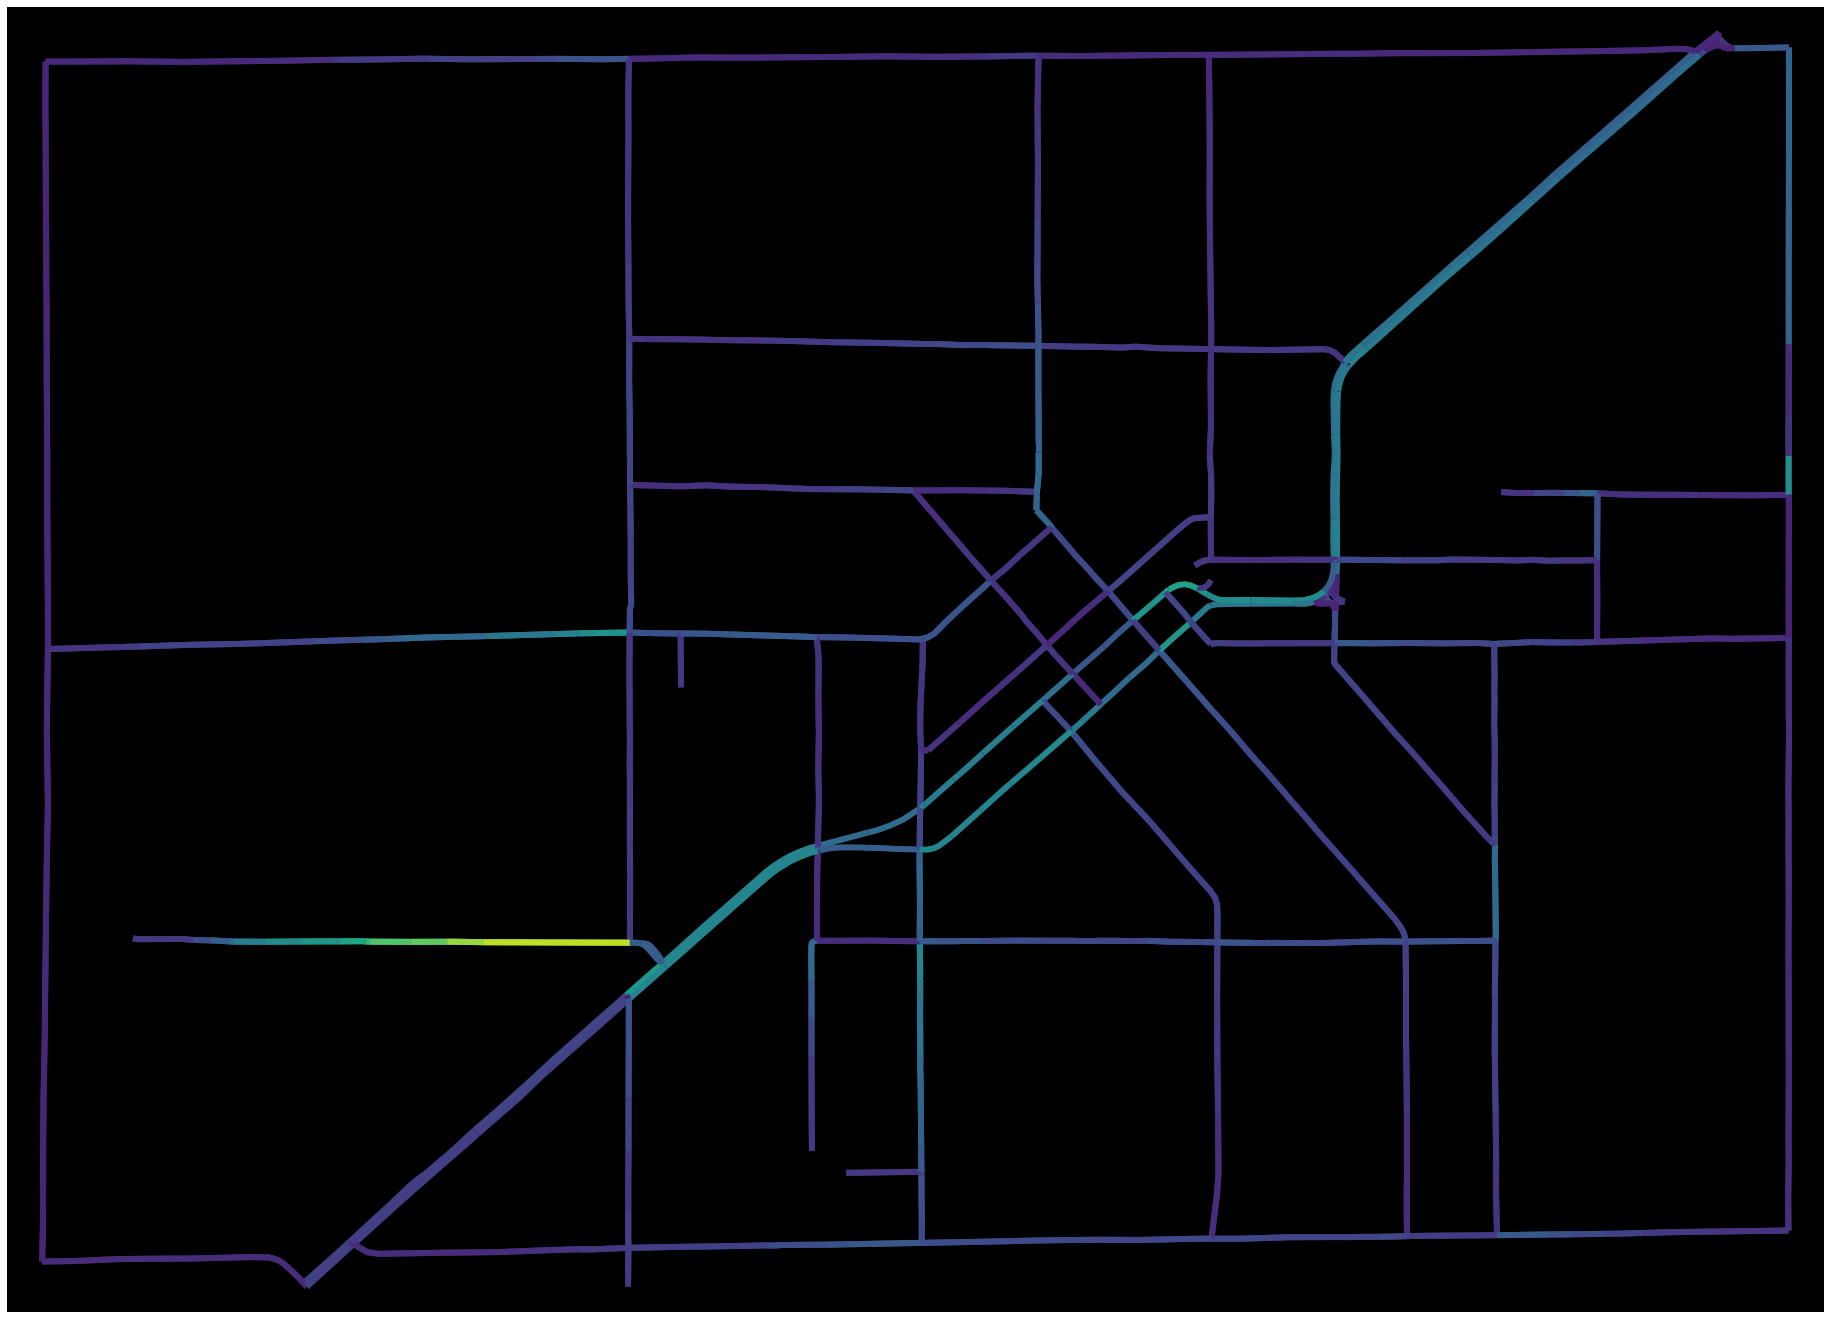

"\nic_vals = sorted(ic.values(), reverse=True)\nx = [i for i in range(0, len(ic_vals))]\n\nplt.scatter(x, ic_vals, s=10)\nplt.title('Betweenness centrality')\nplt.xlabel('Rank')\nplt.ylabel('Betweenness centrality')\n\nplt.show()\nplt.close('all')\n"

In [29]:
# load data from a binary pickle file 
fname = cent_dir + 'ic_res_omitted.pkl'
rf = open(fname,"rb")
ic = pickle.load(rf)
rf.close()

nx.set_edge_attributes(G_wo_res, ic, "information_centrality")

ic_edge_col = ox.plot.get_edge_colors_by_attr(G_wo_res, "information_centrality", cmap='viridis', start=0.1, stop=0.9, na_color='none')
ic_fig, ic_ax = ox.plot_graph(G_wo_res, figsize=(40,24), node_color='b', node_size=0,
                                edge_linewidth=6, edge_color=ic_edge_col, show=False, close=False, bgcolor='k')
"""
# Add a legend
cmap = plt.cm.get_cmap('viridis')
norm = plt.Normalize(vmin=min(ic.values()), vmax=max(ic.values()))
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cb = ic_fig.colorbar(sm, fraction=0.05, pad=0.04, orientation='horizontal')
cb.set_label('Information centrality', fontsize = 20)
cb.ax.tick_params(labelsize=20)

ic_fig.suptitle(t='Information centrality in simplified network (w/ aggr_num)', y=0.93, size=40)
"""
plt.show()
plt.close('all')
"""
ic_vals = sorted(ic.values(), reverse=True)
x = [i for i in range(0, len(ic_vals))]

plt.scatter(x, ic_vals, s=10)
plt.title('Betweenness centrality')
plt.xlabel('Rank')
plt.ylabel('Betweenness centrality')

plt.show()
plt.close('all')
"""

In [30]:
# load data from a binary pickle file 
fname = cent_dir + 'ic_original.pkl'
rf = open(fname,"rb")
ic_org = pickle.load(rf)
rf.close()

# load data from a binary pickle file 
fname = cent_dir + 'ic_simplified.pkl'
rf = open(fname,"rb")
ic_simple = pickle.load(rf)
rf.close()

# load data from a binary pickle file 
fname = cent_dir + 'ic_simplified_with_aggr_num.pkl'
rf = open(fname,"rb")
ic_simple_aggr = pickle.load(rf)
rf.close()

def get_ic_for_simple_graph(org_ic_dic, simple_G, edge):
    u,v,k = edge
    edge_data = simple_G.get_edge_data(u,v,k)
    edge_information_centrality = 0
    
    if 'consolidated_edges' in edge_data:
        """ # average values for consolidated edges
        for edge_segment in edge_data['consolidated_edges']:
            edge_information_centrality += org_ic_dic[edge_segment]
        edge_information_centrality = edge_information_centrality / len(edge_data['consolidated_edges'])
        """
        # maximum value for consolidated edges
        consolidated_edge_vals = []
        for edge_segment in edge_data['consolidated_edges']:
            consolidated_edge_vals.append(org_ic_dic[edge_segment])
        edge_information_centrality = max(consolidated_edge_vals)
    else:
        edge_information_centrality = org_ic_dic[edge]
    
    return edge_information_centrality

ic_data = {edge: [] for edge in G1.edges(keys=True)}

for edge in ic_data:
    ic_data[edge].append(get_ic_for_simple_graph(ic_org, G1, edge))
    ic_data[edge].append(ic_simple[edge])
    ic_data[edge].append(ic_simple_aggr[edge])

ic_df = pd.DataFrame.from_dict(ic_data, orient='index', columns=['org', 'simple', 'simple_aggr'])
display(ic_df)

org    simple  simple_aggr
(143349350, 143349364, 0)   0.000248  0.000304     0.000248
(143349350, 143383314, 0)   0.000482  0.000596     0.000496
(143349350, 143462244, 0)   0.000805  0.000930     0.000812
(143349364, 143349350, 0)   0.000560  0.000700     0.000575
(143349364, 143447714, 0)   0.000459  0.000556     0.000459
...                              ...       ...          ...
(3238913059, 143461315, 0)  0.000091  0.000112     0.000094
(4134309989, 143351985, 0)  0.000039  0.000048     0.000039
(4134309989, 143351970, 0)  0.000091  0.000105     0.000093
(4134309989, 143352236, 0)  0.001345  0.001212     0.001381
(4134309989, 143351813, 0)  0.001186  0.001101     0.001209

[2165 rows x 3 columns]

In [31]:
ic_df.corr(method='pearson')

org    simple  simple_aggr
org          1.000000  0.908307     0.990118
simple       0.908307  1.000000     0.914722
simple_aggr  0.990118  0.914722     1.000000

In [32]:
ic_df.corr(method='spearman')

org    simple  simple_aggr
org          1.000000  0.940235     0.969846
simple       0.940235  1.000000     0.971973
simple_aggr  0.969846  0.971973     1.000000

In [33]:
# load data from a binary pickle file 
fname = cent_dir + 'ic_original.pkl'
rf = open(fname,"rb")
ic_org = pickle.load(rf)
rf.close()

fname = cent_dir + 'ic_res_omitted.pkl'
rf = open(fname,"rb")
ic_res_omitted = pickle.load(rf)
rf.close()

ic_data = {edge: [] for edge in G_wo_res.edges(keys=True)}

for edge in ic_data:
    ic_data[edge].append(ic_org[edge])
    ic_data[edge].append(ic_res_omitted[edge])

ic_df = pd.DataFrame.from_dict(ic_data, orient='index', columns=['org', 'res_omitted'])
display(ic_df)

org  res_omitted
(143349350, 143462244, 0)    0.000805     0.011927
(143349364, 143447714, 0)    0.000459     0.016047
(143349368, 143349364, 0)    0.000731     0.015658
(143349370, 143447714, 0)    0.000025     0.002395
(143349374, 143462253, 0)    0.000107     0.001510
...                               ...          ...
(3641572207, 143461931, 0)   0.001293     0.006150
(3641572207, 3641572205, 0)  0.001143     0.002309
(3641572207, 143352236, 0)   0.001221     0.006579
(4134309989, 143352236, 0)   0.001345     0.007166
(4134309989, 143351813, 0)   0.001186     0.007622

[821 rows x 2 columns]

In [34]:
ic_df.corr(method='pearson')

org  res_omitted
org          1.000000     0.559792
res_omitted  0.559792     1.000000

In [35]:
ic_df.corr(method='spearman')

org  res_omitted
org          1.000        0.523
res_omitted  0.523        1.000

In [63]:
## straightness centrality, weight as edge length ##

# dictionary for euclidean distance between two nodes
# if it is already computed for information centrality, skip this cell
eucDis_dic = {}

for src in G.nodes:
    for dst in G.nodes:
        if src != dst:
            pair = (src, dst)
            if pair not in eucDis_dic:
                src_x = G.nodes[src]['x']
                src_y = G.nodes[src]['y']
                src_coord = (src_y, src_x) # lat, long
                
                dst_x = G.nodes[dst]['x']
                dst_y = G.nodes[dst]['y']
                dst_coord = (dst_y, dst_x) # lat, long
                
                eu_d = geopy.distance.distance(src_coord, dst_coord).m
                
                r_pair = (dst, src)
                eucDis_dic[pair] = eu_d
                eucDis_dic[r_pair] = eu_d

In [64]:
# Compute straightness centrality in the original network
path_len = nx.shortest_path_length(G, weight='length')
num_node = G.number_of_nodes()

# Compute the straightness centrality of each node
for src, len_dic in path_len:
    straightness = 0
    for dst in len_dic:
        if src!= dst:
            euc_dist = eucDis_dic[(src, dst)]
            net_dist = len_dic[dst]
            straightness = straightness + (euc_dist / net_dist)
    straightness = straightness / (num_node - 1)
    
    G.nodes[src]['straightness'] = straightness

In [65]:
# define dictionary
sc_original = nx.get_node_attributes(G, 'straightness')

# create a binary pickle file 
f = open("./centrality_measures/Portales/sc_original.pkl","wb")
pickle.dump(sc_original, f)

# close file
f.close()

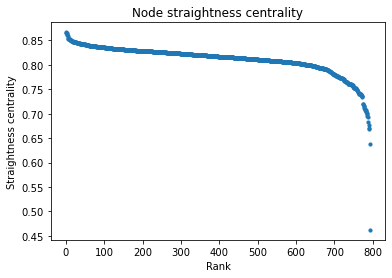

In [72]:
# load data from a binary pickle file 
fname = cent_dir + 'sc_original.pkl'
rf = open(fname,"rb")
sc = pickle.load(rf)
rf.close()

sc_vals = sorted(sc.values(), reverse=True)
x = [i for i in range(0, len(sc_vals))]

plt.scatter(x, sc_vals, s=10)
plt.title('Node straightness centrality')
plt.xlabel('Rank')
plt.ylabel('Straightness centrality')

plt.show()
plt.close('all')

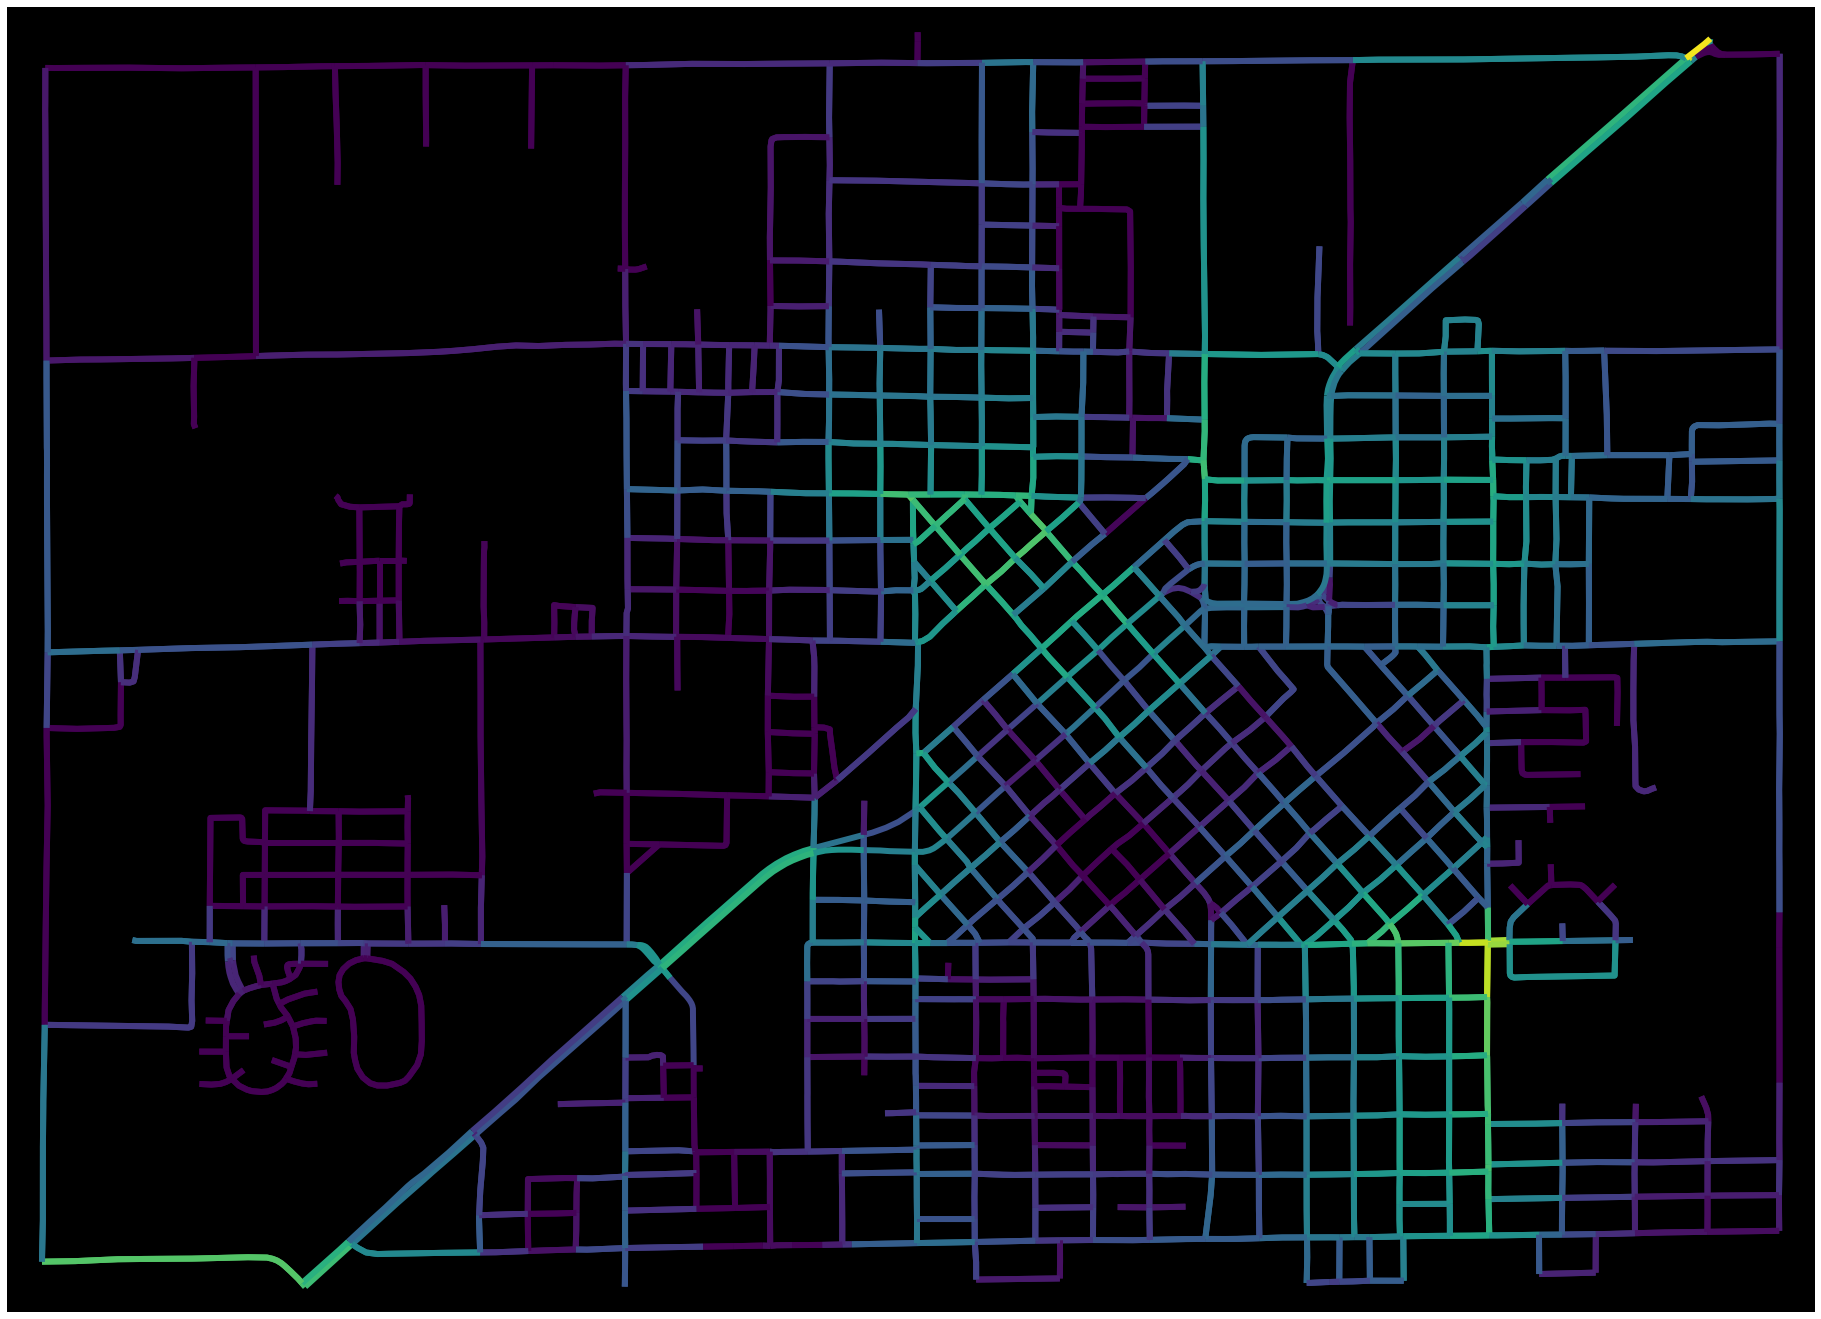

In [73]:
outlier_criterion = np.percentile(list(sc.values()), 25)
for key in sc:
    if sc[key] < outlier_criterion:
        sc[key] = outlier_criterion

for edge in G.edges(keys=True):
    u,v,k = edge
    u_sc = sc[u]
    v_sc = sc[v]
    edge_sc = (u_sc + v_sc) / 2
    G.edges[edge]['straightness_centrality'] = edge_sc
    
# Plot a map that represents the eigenvector centrality of each node
ec = ox.plot.get_edge_colors_by_attr(G, "straightness_centrality", cmap='viridis', start=0, stop=1, na_color='none')
sc_fig, sc_ax = ox.plot_graph(G, figsize=(40,24), node_color='b', node_size=0,
                                edge_linewidth=6, edge_color=ec, show=False, close=False, bgcolor='black')
"""
sc_fig.suptitle(t='Straightness centrality', y=0.93, size=40)

edge_sc = nx.get_edge_attributes(G, 'straightness_centrality')

# Add a legend
cmap = plt.cm.get_cmap('viridis')
norm = plt.Normalize(vmin=min(edge_sc.values()), vmax=max(edge_sc.values()))
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cb = sc_fig.colorbar(sm, fraction=0.05, pad=0.04, orientation='horizontal')
cb.ax.tick_params(labelsize=20)
"""
plt.show()
plt.close('all')

In [77]:
# Compute straightness centrality in the original network
path_len = nx.shortest_path_length(G1, weight='length')
num_node = G1.number_of_nodes()

# Compute the straightness centrality of each node
for src, len_dic in path_len:
    straightness = 0
    for dst in len_dic:
        if src!= dst:
            euc_dist = eucDis_dic[(src, dst)]
            net_dist = len_dic[dst]
            straightness = straightness + (euc_dist / net_dist)
    straightness = straightness / (num_node - 1)
    
    G1.nodes[src]['straightness'] = straightness

In [78]:
# define dictionary
sc_simplified = nx.get_node_attributes(G1, 'straightness')

# create a binary pickle file 
f = open("./centrality_measures/Portales/sc_simplified.pkl","wb")
pickle.dump(sc_simplified, f)

# close file
f.close()

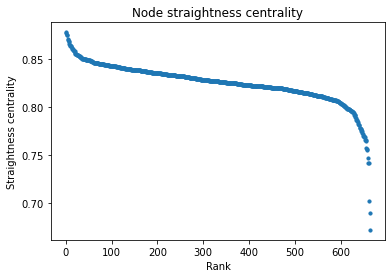

In [80]:
# load data from a binary pickle file 
fname = cent_dir + 'sc_simplified.pkl'
rf = open(fname,"rb")
sc = pickle.load(rf)
rf.close()

sc_vals = sorted(sc.values(), reverse=True)
x = [i for i in range(0, len(sc_vals))]

plt.scatter(x, sc_vals, s=10)
plt.title('Node straightness centrality')
plt.xlabel('Rank')
plt.ylabel('Straightness centrality')

plt.show()
plt.close('all')

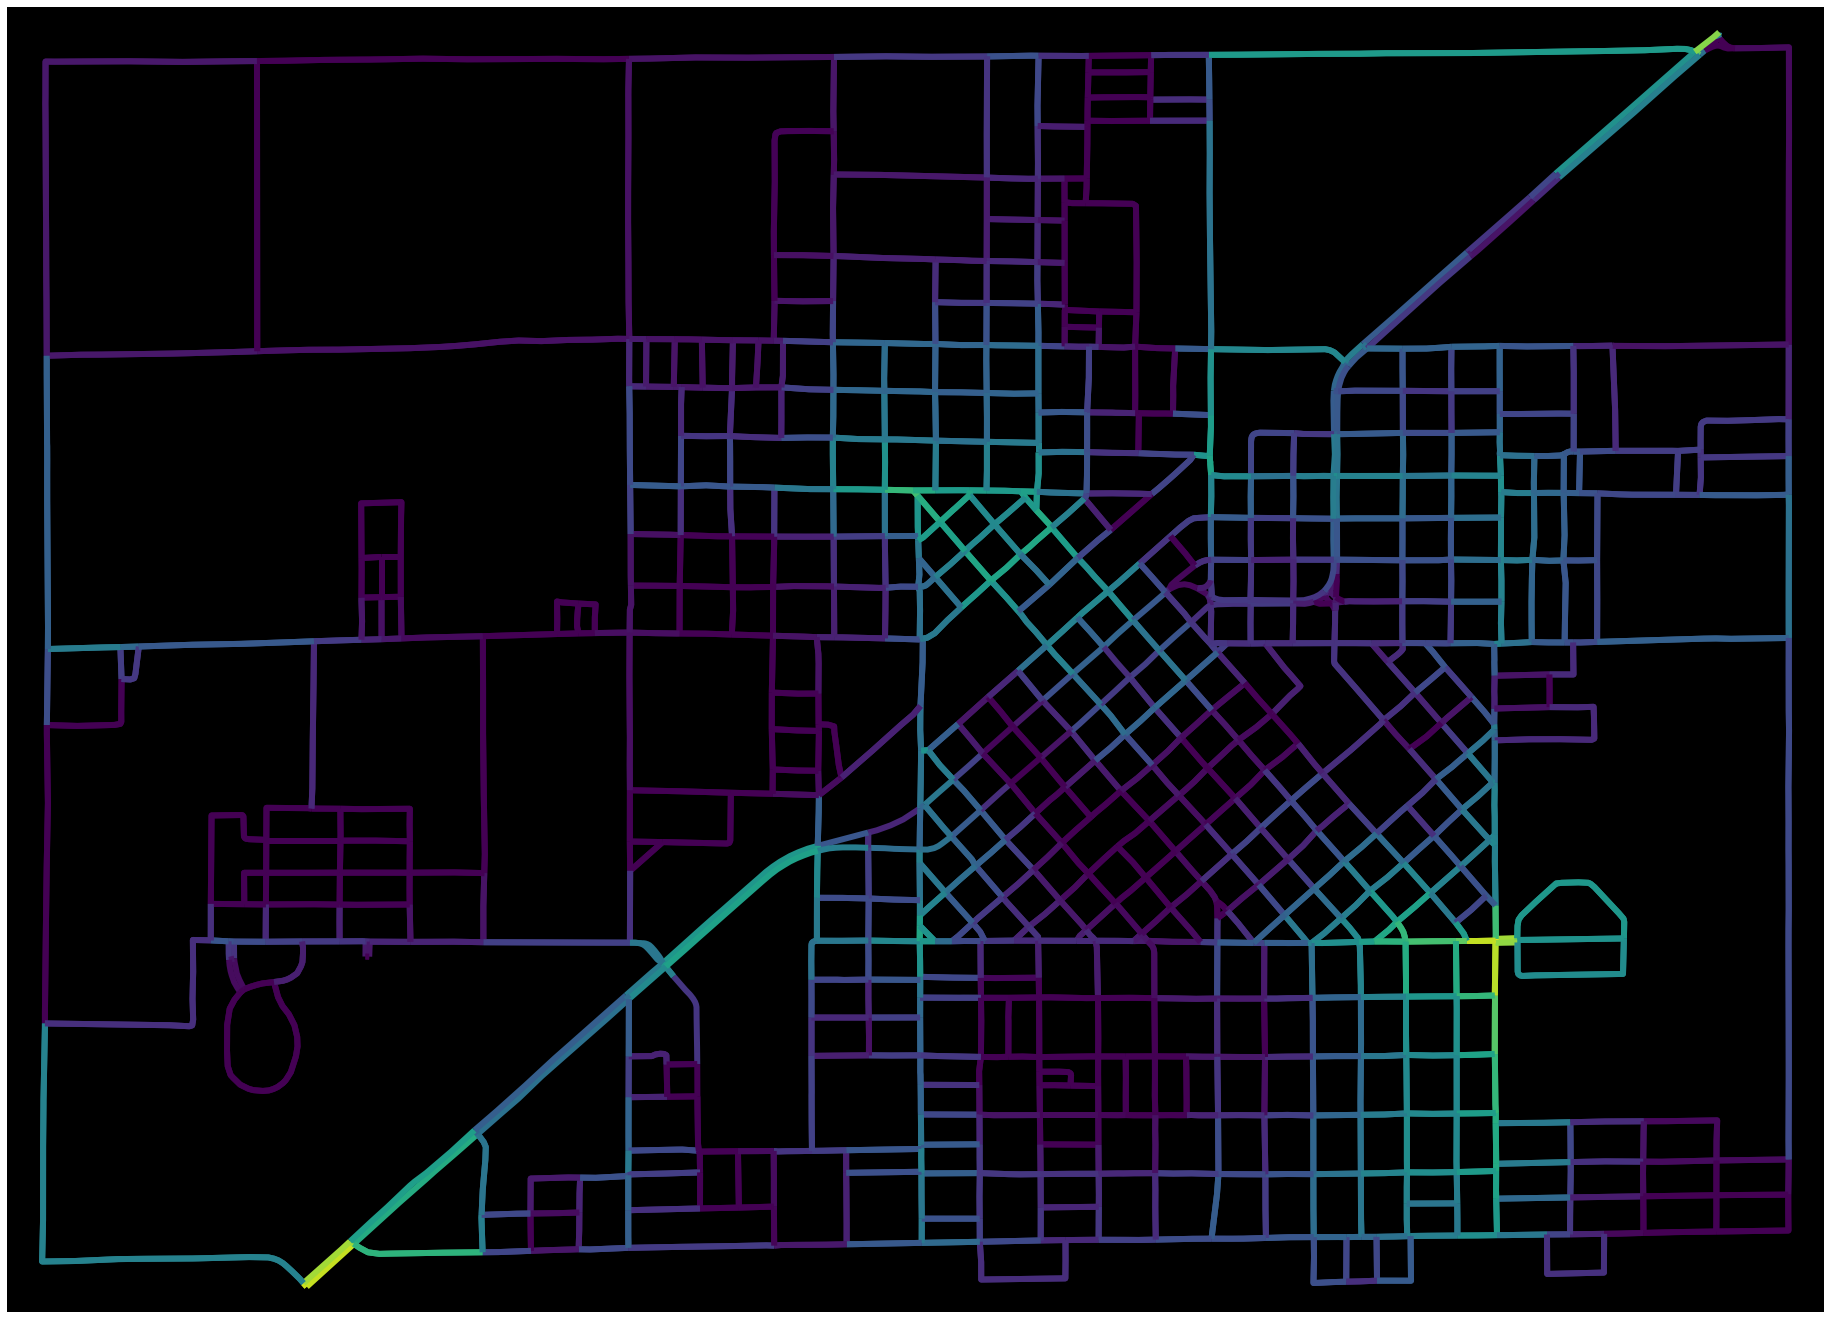

In [81]:
outlier_criterion = np.percentile(list(sc.values()), 25)
for key in sc:
    if sc[key] < outlier_criterion:
        sc[key] = outlier_criterion

for edge in G1.edges(keys=True):
    u,v,k = edge
    u_sc = sc[u]
    v_sc = sc[v]
    edge_sc = (u_sc + v_sc) / 2
    G1.edges[edge]['straightness_centrality'] = edge_sc
    
# Plot a map that represents the eigenvector centrality of each node
ec = ox.plot.get_edge_colors_by_attr(G1, "straightness_centrality", cmap='viridis', start=0, stop=1, na_color='none')
sc_fig, sc_ax = ox.plot_graph(G1, figsize=(40,24), node_color='b', node_size=0,
                                edge_linewidth=6, edge_color=ec, show=False, close=False, bgcolor='black')
"""
sc_fig.suptitle(t='Straightness centrality', y=0.93, size=40)

edge_sc = nx.get_edge_attributes(G1, 'straightness_centrality')

# Add a legend
cmap = plt.cm.get_cmap('viridis')
norm = plt.Normalize(vmin=min(edge_sc.values()), vmax=max(edge_sc.values()))
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cb = sc_fig.colorbar(sm, fraction=0.05, pad=0.04, orientation='horizontal')
cb.ax.tick_params(labelsize=20)
"""
plt.show()
plt.close('all')

In [82]:
# Estimate straightness centrality in the "original network" using the "simplified network" and "aggr_node_num"
path_len = nx.shortest_path_length(G1, weight='length')

# use the number of nodes in original network
num_node = G.number_of_nodes()

# Compute the straightness centrality of each node
for src, len_dic in path_len:
    straightness = 0
    aggr_src = G1.nodes[src]['aggr_node_num']
    for dst in len_dic:
        if src!= dst:
            euc_dist = eucDis_dic[(src, dst)]
            net_dist = len_dic[dst]
            
            aggr_dst = G1.nodes[dst]['aggr_node_num']
            sigma = (euc_dist / net_dist) * aggr_dst
            straightness = straightness + sigma
    straightness = straightness / (num_node - 1)
    
    G1.nodes[src]['straightness'] = straightness

In [83]:
# define dictionary
sc_simplified_with_aggr = nx.get_node_attributes(G1, 'straightness')

# create a binary pickle file 
f = open("./centrality_measures/Portales/sc_simplified_with_aggr_num.pkl","wb")
pickle.dump(sc_simplified_with_aggr, f)

# close file
f.close()

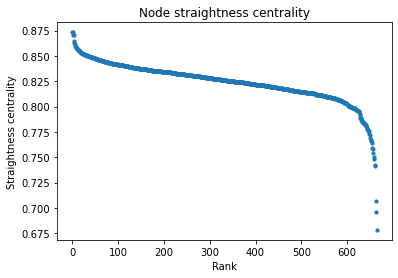

In [84]:
# load data from a binary pickle file 
fname = cent_dir + 'sc_simplified_with_aggr_num.pkl'
rf = open(fname,"rb")
sc = pickle.load(rf)
rf.close()

sc_vals = sorted(sc.values(), reverse=True)
x = [i for i in range(0, len(sc_vals))]

plt.scatter(x, sc_vals, s=10)
plt.title('Node straightness centrality')
plt.xlabel('Rank')
plt.ylabel('Straightness centrality')

plt.show()
plt.close('all')

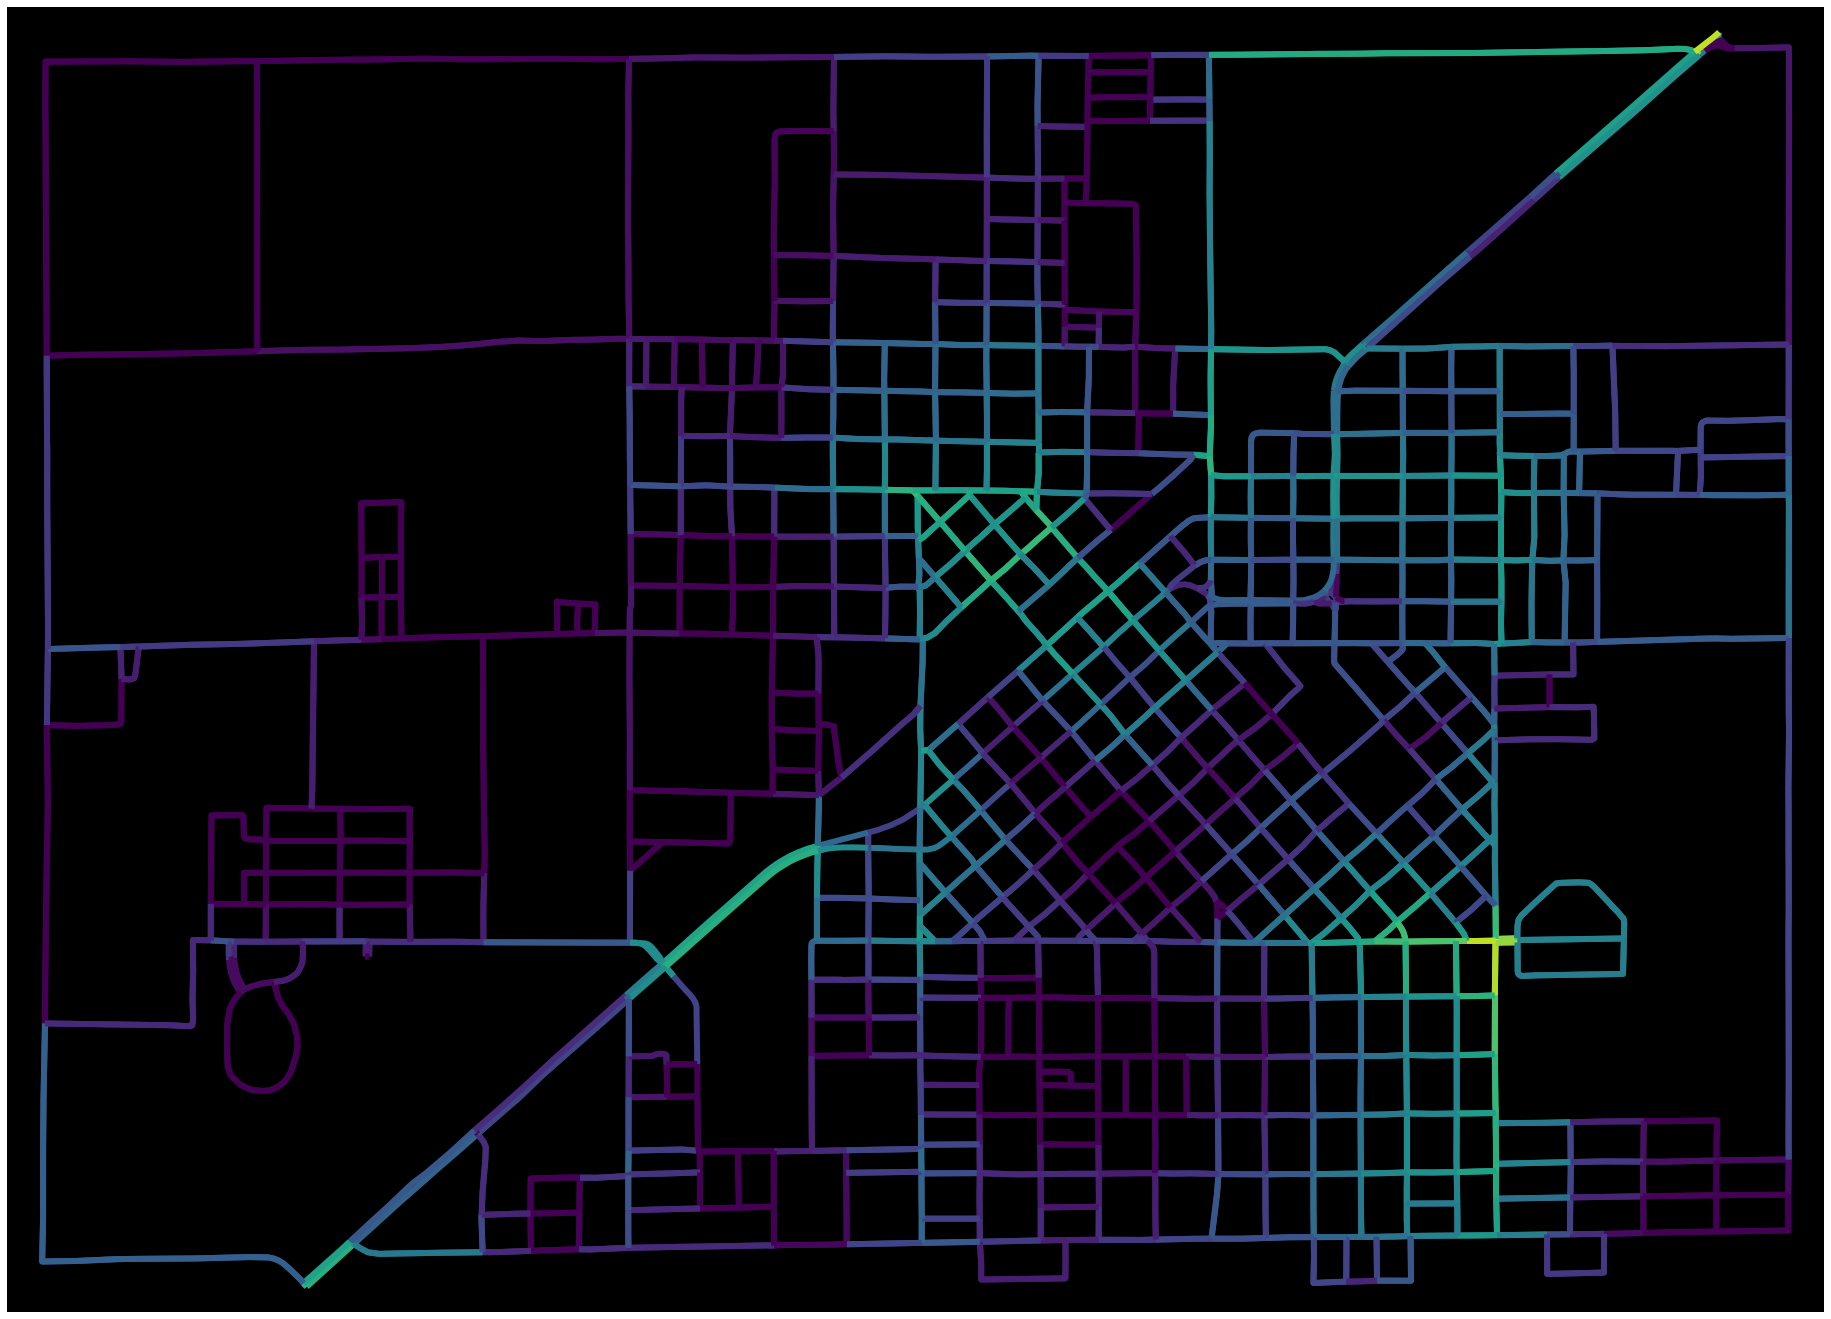

In [85]:
outlier_criterion = np.percentile(list(sc.values()), 25)
for key in sc:
    if sc[key] < outlier_criterion:
        sc[key] = outlier_criterion

for edge in G1.edges(keys=True):
    u,v,k = edge
    u_sc = sc[u]
    v_sc = sc[v]
    edge_sc = (u_sc + v_sc) / 2
    G1.edges[edge]['straightness_centrality'] = edge_sc

# Plot a map that represents the eigenvector centrality of each node
ec = ox.plot.get_edge_colors_by_attr(G1, "straightness_centrality", cmap='viridis', start=0, stop=1, na_color='none')
sc_fig, sc_ax = ox.plot_graph(G1, figsize=(40,24), node_color='b', node_size=0,
                                edge_linewidth=6, edge_color=ec, show=False, close=False, bgcolor='black')
"""
sc_fig.suptitle(t='Straightness centrality', y=0.93, size=40)

edge_sc = nx.get_edge_attributes(G1, 'straightness_centrality')

# Add a legend
cmap = plt.cm.get_cmap('viridis')
norm = plt.Normalize(vmin=min(edge_sc.values()), vmax=max(edge_sc.values()))
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cb = sc_fig.colorbar(sm, fraction=0.05, pad=0.04, orientation='horizontal')
cb.ax.tick_params(labelsize=20)
"""
plt.show()
plt.close('all')

In [86]:
# Compute straightness centrality in the original network
path_len = nx.shortest_path_length(G_wo_res, weight='length')
num_node = G_wo_res.number_of_nodes()

# Compute the straightness centrality of each node
for src, len_dic in path_len:
    straightness = 0
    for dst in len_dic:
        if src!= dst:
            euc_dist = eucDis_dic[(src, dst)]
            net_dist = len_dic[dst]
            straightness = straightness + (euc_dist / net_dist)
    straightness = straightness / (num_node - 1)
    
    G_wo_res.nodes[src]['straightness'] = straightness

In [88]:
# define dictionary
sc_res_omitted = nx.get_node_attributes(G_wo_res, 'straightness')

# create a binary pickle file 
f = open("./centrality_measures/Portales/sc_res_omitted.pkl","wb")
pickle.dump(sc_res_omitted, f)

# close file
f.close()

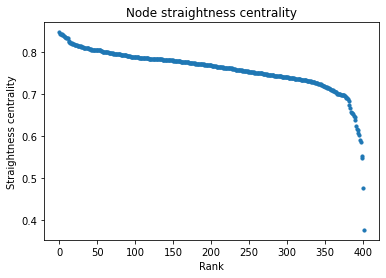

In [89]:
# load data from a binary pickle file 
fname = cent_dir + 'sc_res_omitted.pkl'
rf = open(fname,"rb")
sc = pickle.load(rf)
rf.close()

sc_vals = sorted(sc.values(), reverse=True)
x = [i for i in range(0, len(sc_vals))]

plt.scatter(x, sc_vals, s=10)
plt.title('Node straightness centrality')
plt.xlabel('Rank')
plt.ylabel('Straightness centrality')

plt.show()
plt.close('all')

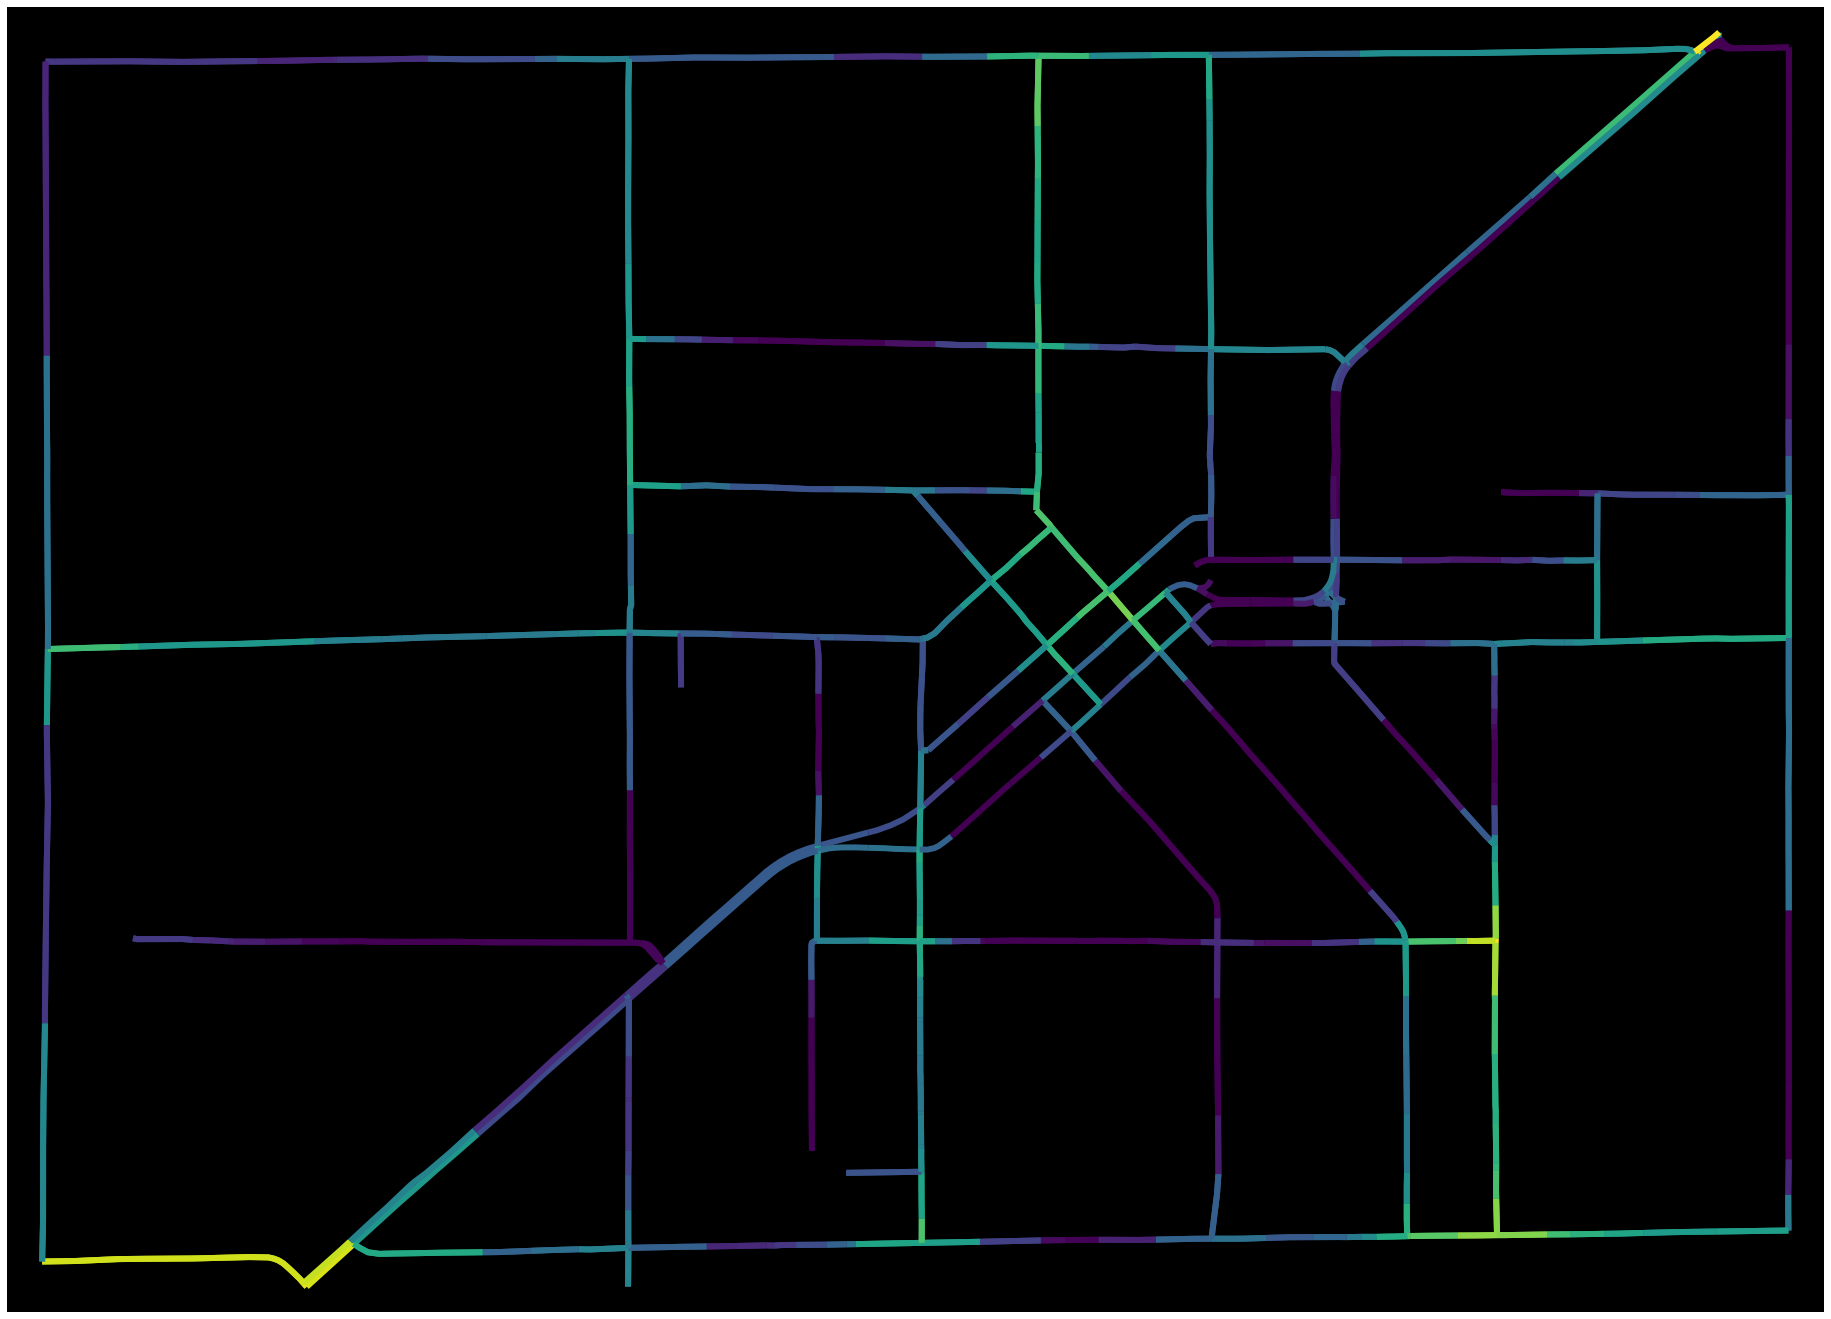

In [90]:
outlier_criterion = np.percentile(list(sc.values()), 25)
for key in sc:
    if sc[key] < outlier_criterion:
        sc[key] = outlier_criterion

for edge in G_wo_res.edges(keys=True):
    u,v,k = edge
    u_sc = sc[u]
    v_sc = sc[v]
    edge_sc = (u_sc + v_sc) / 2
    G_wo_res.edges[edge]['straightness_centrality'] = edge_sc

# Plot a map that represents the eigenvector centrality of each node
ec = ox.plot.get_edge_colors_by_attr(G_wo_res, "straightness_centrality", cmap='viridis', start=0, stop=1, na_color='none')
sc_fig, sc_ax = ox.plot_graph(G_wo_res, figsize=(40,24), node_color='b', node_size=0,
                                edge_linewidth=6, edge_color=ec, show=False, close=False, bgcolor='black')
"""
sc_fig.suptitle(t='Straightness centrality', y=0.93, size=40)

edge_sc = nx.get_edge_attributes(G1, 'straightness_centrality')

# Add a legend
cmap = plt.cm.get_cmap('viridis')
norm = plt.Normalize(vmin=min(edge_sc.values()), vmax=max(edge_sc.values()))
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cb = sc_fig.colorbar(sm, fraction=0.05, pad=0.04, orientation='horizontal')
cb.ax.tick_params(labelsize=20)
"""
plt.show()
plt.close('all')

In [91]:
# load data from a binary pickle file 
fname = cent_dir + 'sc_original.pkl'
rf = open(fname,"rb")
sc_org = pickle.load(rf)
rf.close()

# load data from a binary pickle file 
fname = cent_dir + 'sc_simplified.pkl'
rf = open(fname,"rb")
sc_simple = pickle.load(rf)
rf.close()

# load data from a binary pickle file 
fname = cent_dir + 'sc_simplified_with_aggr_num.pkl'
rf = open(fname,"rb")
sc_simple_aggr = pickle.load(rf)
rf.close()

sc_data = {node: [] for node in G1.nodes()}

for node in sc_data:
    sc_data[node].append(sc_org[node])
    sc_data[node].append(sc_simple[node])
    sc_data[node].append(sc_simple_aggr[node])

sc_df = pd.DataFrame.from_dict(sc_data, orient='index', columns=['org', 'simple', 'simple_aggr'])
display(sc_df)

org    simple  simple_aggr
143349350   0.823348  0.823919     0.829549
143349364   0.820681  0.820247     0.826847
143349368   0.825897  0.827068     0.832232
143349370   0.825507  0.826673     0.831791
143349374   0.831247  0.833178     0.837460
...              ...       ...          ...
3238901510  0.833065  0.844999     0.840142
3238901513  0.832104  0.843935     0.841580
3238913058  0.839542  0.852342     0.846251
3238913059  0.831657  0.844190     0.838483
4134309989  0.807517  0.815031     0.813429

[665 rows x 3 columns]

In [92]:
sc_df.corr(method='pearson')

org    simple  simple_aggr
org          1.000000  0.980044     0.997801
simple       0.980044  1.000000     0.978478
simple_aggr  0.997801  0.978478     1.000000

In [93]:
sc_df.corr(method='spearman')

org    simple  simple_aggr
org          1.000000  0.963984     0.996931
simple       0.963984  1.000000     0.961740
simple_aggr  0.996931  0.961740     1.000000

In [94]:
# load data from a binary pickle file 
fname = cent_dir + 'sc_original.pkl'
rf = open(fname,"rb")
sc_org = pickle.load(rf)
rf.close()

fname = cent_dir + 'sc_res_omitted.pkl'
rf = open(fname,"rb")
sc_res_omitted = pickle.load(rf)
rf.close()

sc_data = {node: [] for node in G_wo_res.nodes()}

for node in sc_data:
    sc_data[node].append(sc_org[node])
    sc_data[node].append(sc_res_omitted[node])

sc_df = pd.DataFrame.from_dict(sc_data, orient='index', columns=['org', 'res_omitted'])
display(sc_df)

org  res_omitted
143349350   0.823348     0.612935
143349364   0.820681     0.729782
143349368   0.825897     0.725162
143349370   0.825507     0.730363
143349374   0.831247     0.725791
...              ...          ...
3238913058  0.839542     0.800199
3238913059  0.831657     0.787171
3641572205  0.735801     0.705076
3641572207  0.807012     0.775436
4134309989  0.807517     0.761587

[402 rows x 2 columns]

In [95]:
sc_df.corr(method='pearson')

org  res_omitted
org          1.000000     0.360834
res_omitted  0.360834     1.000000

In [96]:
sc_df.corr(method='spearman')

org  res_omitted
org          1.000000     0.443301
res_omitted  0.443301     1.000000